# Notebook overview

The goal of this notebook is to use different algorithms to develop the scoring model for our credit problem.

Four classification algorithms were evaluated and compared:

0. DummyClassifier (baseline)
1. LogisticRegression
2. RandomForestClassifier
3. LightGBM
4. XGBoost

For each of the algorithms, except for the Dummy Classifier, the training and tuning process is organised in the following steps:

1. Set up a default configuration to act as the model's baseline.
2. Choose the best class balancing method.
3. Choose the optimal preprocessing options.
4. Fine-tune model parameters.

All the training results were logged to MLFlow for a better visualization.

Once the best performing model was determined, the feature importance was analysed with the help of the SHAP library.

# Imports
## Libraries

In [437]:
import pandas as pd
import numpy as np
from numpy import sqrt, argmax
import matplotlib.pyplot as plt
import seaborn as sns
import gc, warnings, os, time, sys
import mlflow
import importlib
from scipy.stats import loguniform
import shap
import joblib
from hyperopt import hp, tpe, fmin, Trials

# custom classes
import pipelines
import data_preprocessing as process
import transformers

importlib.reload(process)
importlib.reload(transformers)
importlib.reload(pipelines)

from pipelines import PIPELINES

# sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, classification_report, f1_score, fbeta_score, roc_curve, RocCurveDisplay, confusion_matrix, recall_score, precision_score
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter('ignore', category=FutureWarning)
#warnings.simplefilter('ignore', category=ConvergenceWarning)

pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.4f}'.format

# Pipeline

The model pipeline is constructed automatically based on a configuration dictionary of the following shape:

```
CONFIG = {
    'preprocessing': {
        'should_fill_na': True|False,
        'num_imputer': imputer method (SimpleImputer(strategy='median'))
        'cat_imputer': imputer method (SimpleImputer(strategy='median')),
        'should_scale': True|False,
        'scaler': scaler method (StandardScaler())
        'should_remove_outliers': True|False,
        'iqr_factor': 1.5,
        'should_normalize_columns': True|False,
        'should_normalize_distribution': True|False,
        'should_downcast': True|False,
        'should_select_features': True|False,
        'features_to_keep': [],
        'use_bureau_and_balance': True|False,
        'use_previous_applications': True|False,
        'use_pos_cash_balance': True|False,
        'use_installments_payments': True|False,
        'use_credit_card_balance': True|False,
    },
    'balancing': {
        'should_oversample': True|False,
        'with_categorical': True|False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': True|False,
        'use_random_grid': True|False,
        'cv_splits': 5,
        'param_grid': {}, # params for the grid search if use_cv is True
        'params': {}, # model parameters if use_cv is False
    }
}
```

### Custom score function

Credit decision and management is a complex and challenging process, in which many factors involved affect the calculation of the misclassification costs, they depend on each individual case and are likely to change over time as the economy evolves.

The confusion matrix presents the combinations of the number of actual and predicted observations in a dataset and is a good tool to estimate their ratio:

**True Positives (TP):** Customers identified as risky and who actually had payment difficulties. <br/>
**True Negatives (TN):** Customers identified as safe and who really didn't have payment issues. <br/>
**False Positive (FP):** Customers identified as risky but who actually don't have payment difficulties. <br/>
**False Negative (FN):** Customers identified as safe but who did have payment issues. <br/>

We can distinguish 2 Error Types, which affect the profitability and credit losses of the company:

- **Type I Error**, False Positives: customers predicted as potential defaulters but did not default, they affect profitability as they represent potential clients that are lost. <br/>
- **Type II Erro**, False Negatives: customers predicted as not defaulter and who actually defaulted, they can cause an important money loss for the company. 

It is generally believed that the misclassification costs associated with Type II errors (bad credit misclassified as good credit) are much higher than the costs associated with Type I errors (good credit misclassified as bad credit). Some researchers reported that the ratio of misclassification costs is 5:1. However, the use of this relative cost ratio can be extended, in terms of sensitivity analysis, to higher cost ratios (i.e. 7:1, 10:1 etc) as noted by [1][2].

There is no clear consensus as to which cost ratio should be used, therefore it should be done by the domain expert. 
For this project, we will use the recommended ratio of 10:1 where False Negatives will be given more weight as we want to minimize their number. We will also use it as a beta parameter to calculate the F beta score.

Research papers quoted:

*[1] Abdou, H., Pointon, J. Credit scoring and decision-making in Egyptian public sector banks. International Journal of Managerial Finance 5 (4): 391-406., 2009*

*[2] Bakker Daniel, Odundo, Nyakinda J, Paul Samuel, Performance Evaluation Criteria of Credit Scoring Models for Commercial Lenders. International Journal of Mathematics Trends and Technology (IJMTT) – Volume 65 Issue 7 - July 2019*

In [2]:
def get_cost_ratio_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    score = 10 * fn + fp

    return score / y_true.size

cost_ratio_scorer = make_scorer(get_cost_ratio_score, greater_is_better=False)

### Threshold moving

The default threshold for interpreting probabilities to class labels is 0.5, however, for the data with a high class imbalance, the default threshold can result in poor performance.

There are different ways to calculate the best threshold:

1. The **Geometric Mean** or **G-Mean** is a metric for imbalanced classification that, if optimized, will seek a balance between Recall and the specificity.

`G-Mean = sqrt(Recall * Specificity)`
One approach would be to test the model with each threshold returned from the call roc_auc_score() and select the threshold with the largest G-Mean value.

2. the Youden’s **J statistic**, which is calculated as:<br/>
`J = Recall + Specificity – 1`

Given that we have Recall (TPR) and the complement of the specificity (FPR), we can calculate it as: <br/>
`J = Recall + (1 – FalsePositiveRate) – 1`

Which we can restate as:<br/>
`J = TruePositiveRate – FalsePositiveRate`

3. Threshold tuning: testing a score function against a set of thresholds and choose the threshold having the best score

We will use the **J statistic** as it is the simplest and fastest approach.

In [3]:
def get_best_threshold(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    
    # get the best threshold using J-statistic
    J_statistic = tpr - fpr
    j_index = argmax(J_statistic)
    
    return (j_index, round(thresholds[j_index], 2))

### Logging functions

In [12]:
def display_scores(y_true, y_pred, y_pred_proba, name=''):
    auc = round(roc_auc_score(y_true, y_pred_proba), 2)
    
    metrics = {
        'AUC': auc,
        'Cost ratio score': round(get_cost_ratio_score(y_true, y_pred), 2),
        'Recall': round(recall_score(y_true, y_pred), 2),
        'Precision': round(precision_score(y_true, y_pred), 2),
        'F1 score': round(f1_score(y_true, y_pred), 2),
        'F beta_10': round(fbeta_score(y_true, y_pred, beta=10), 2),
        'Accuracy': round(accuracy_score(y_true, y_pred, normalize=True), 2),
    }
    
    print('-------------------------')

    for metric_name in metrics:
        print(f'{metric_name}: {metrics[metric_name]}')
        mlflow.log_metric(metric_name, metrics[metric_name])

    # Classification report
    print('Classification report:')
    print(f'{classification_report(y_true, y_pred, zero_division=0)}')

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    
    # get the best threshold
    (j_index, threshold) = get_best_threshold(y_true, y_pred_proba)
    print(f'Best Threshold: {threshold}')

    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, linestyle='-', linewidth=2, label=name)
    plt.scatter(fpr[j_index], tpr[j_index], marker='o', color='black', label='Best')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
    print('-------------------------')

Log parameters to MLFlow:

In [6]:
def log_model_params(params):
    for param_name in params:
        param_name_to_log = param_name.replace('classifier__', '')
        mlflow.log_param(param_name_to_log, params[param_name])

In [7]:
def display_cv_results(cv_results):
    params_df = pd.DataFrame(cv_results["params"])
    params_df.columns = params_df.columns.str.replace('classifier__', '')
    
    cv_results_df = pd.concat([
        pd.DataFrame(cv_results["mean_test_score"], columns=["Cost ratio score"]), params_df], axis=1)

    print(cv_results_df)

### Training

The training function will expect a pipeline name, a configuration dictionary defined above, the dev_mode (if True, take a sample, if False, take the whole dataset).

In [8]:
def train(pipeline_name, config, dev_mode=True, should_save_model=False):
    print('Training the model')
    time_start = time.time()

    data = process.load_application(dev_mode)

    X = data.drop(process.TARGET_COLUMN, axis=1)
    y = data[process.TARGET_COLUMN]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                          y,
                                                          test_size=0.2,
                                                          random_state=42,
                                                          shuffle=False)

    print('Train shape: {}'.format(X_train.shape))
    print('Valid shape: {}'.format(y_train.shape))

    pipeline = PIPELINES[pipeline_name](config=config, dev_mode=dev_mode)

    print('Start pipeline fit and transform')
    
    model_params = config['model_params']

    if model_params['use_cv']:
        cv = StratifiedKFold(n_splits=model_params['cv_splits'], shuffle=False)

        grid_search = None

        if model_params['use_random_grid']:
            grid_search = RandomizedSearchCV(estimator=pipeline, 
                                   param_distributions=model_params['param_grid'], 
                                   n_iter=100,
                                   cv=cv, 
                                   n_jobs=-1, 
                                   scoring=cost_ratio_scorer,
                                   verbose=0)
        else:
            grid_search = GridSearchCV(estimator=pipeline, 
                                   param_grid=model_params['param_grid'], 
                                   cv=cv, 
                                   n_jobs=-1, 
                                   scoring=cost_ratio_scorer,
                                   verbose=0)
    
        grid_search.fit(X_train, y_train)

        # mlflow log 
        log_model_params(grid_search.best_params_)
        print(f'Best score: {grid_search.best_score_} with params: {grid_search.best_params_}')
        
        # print grid search results
        display_cv_results(grid_search.cv_results_)
        
        # predict with the fitted grid search
        y_pred = grid_search.predict(X_test)
        y_pred_proba = grid_search.predict_proba(X_test)[::,1]

        display_scores(y_test, y_pred, y_pred_proba, name=pipeline_name)

        # calc the best threshold
        (j_index, threshold) = get_best_threshold(y_test, y_pred_proba)
        print('Running predictions with the best threshold')
        y_pred_threshold = (grid_search.predict_proba(X_test)[:, 1] >= threshold).astype(int) 
        display_scores(y_test, y_pred_threshold, y_pred_proba, name=pipeline_name)

    else:
        pipeline.fit(X_train, y_train)
        
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[::,1]
        display_scores(y_test, y_pred, y_pred_proba, name=pipeline_name)

        # calc the best threshold
        (j_index, threshold) = get_best_threshold(y_test, y_pred_proba)
        print('Running predictions with the best threshold')
        y_pred_threshold = (pipeline.predict_proba(X_test)[:, 1] >= threshold).astype(int) 
        
        log_model_params(model_params['params'])
        display_scores(y_test, y_pred_threshold, y_pred_proba, name=pipeline_name)

        model = pipeline.named_steps["classifier"]
        
        if should_save_model:
            filename = f'./model/pipeline_{pipeline_name}_model.pkl'
            joblib.dump(model, filename)
            
        mlflow.sklearn.log_model(model, pipeline_name)
    
    exec_time = round((time.time() - time_start), 2)
    print(f'execution time: {exec_time} seconds \n')

# Experiments
## Dummy classifier

Dummy Classifier serves as a simple baseline to compare against more complex classifiers, it makes predictions that ignore the input features and returns the most frequent class label in our case. It is based on the philosophy that any analytic approach for a classification problem should be better than a random guessing approach.

In [10]:
# Set the experiment
mlflow.set_experiment("Dummy Classifier")

# Track models automatically
mlflow.sklearn.autolog()

2024/01/07 08:19:27 INFO mlflow.tracking.fluent: Experiment with name 'Dummy Classifier' does not exist. Creating a new experiment.


2024/01/07 08:21:00 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
2024/01/07 08:21:00 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/07 08:21:02 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/07 08:21:03 WARNING mlflow.data.pandas_dataset: F

-------------------------
AUC: 0.5
Cost ratio score: 0.79
Recall: 0.0
Precision: 0.0
F1 score: 0.0
F beta_10: 0.0
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.00      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

Best Threshold: inf


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


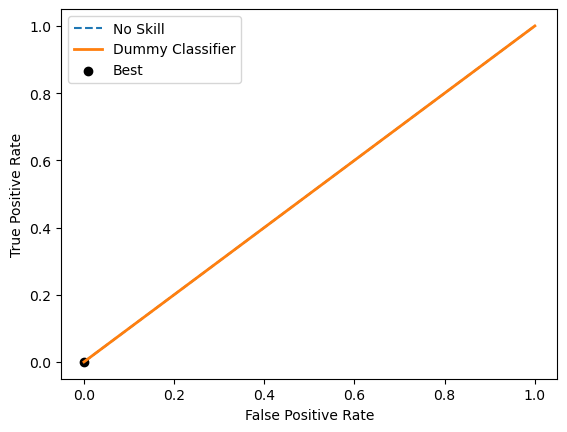

-------------------------


In [13]:
with mlflow.start_run(run_name = 'dummy_classifier_most_frequent'):
    data = process.load_application(dev_mode=False)
    
    X = data.drop(process.TARGET_COLUMN, axis=1)
    y = data[process.TARGET_COLUMN]
    
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                          y,
                                                          test_size=0.2,
                                                          random_state=42,
                                                          shuffle=False)
    
    
    dummy_model = PIPELINES['dummy'](config={'strategy': 'most_frequent'})
    dummy_model.fit(X_train, y_train)
            
    y_pred = dummy_model.predict(X_test)
    y_pred_proba = dummy_model.predict_proba(X_test)[::,1]
    display_scores(y_test, y_pred, y_pred_proba, name='Dummy Classifier')

mlflow.end_run()

As expected, we obtained a really high Accuracy of 0.92 that corresponds to the percentage of our majority class, and the AUC of 0.5 that is obtained by randomly guessing the labels.

## Logistic Regression

Logistic regression is a statistical method for binary classification. It models the relationship between a dependent binary variable and  independent variables by estimating the probability of the binary outcome. It uses a logistic function to transform linear combinations of the independent variables, making it suitable for predicting probabilities and classifying data into two categories based on a threshold.

We will start with the most simple configuration.

In [14]:
# Set the experiment
mlflow.set_experiment("Logistic Regression")

# Track models automatically
mlflow.sklearn.autolog()

### Baseline

We will start by training a Logistic Regression model with default parameters and minimum preprocessing configuration (filling missing values and one hot encoding for the categorical features, otherwise the model won't work).

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 08:25:17 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/07 08:25:54 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/07 08:25:57 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/07 08:25:58 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values ha

-------------------------
AUC: 0.64
Cost ratio score: 0.79
Recall: 0.0
Precision: 0.0
F1 score: 0.0
F beta_10: 0.0
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.00      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

Best Threshold: 0.07


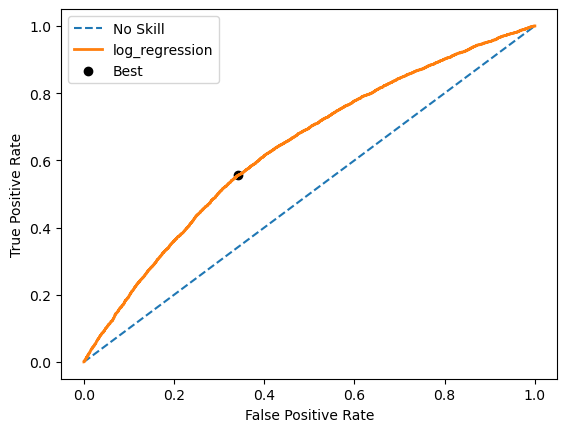

-------------------------
Running predictions with the best threshold


2024/01/07 08:25:59 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.64
Cost ratio score: 0.67
Recall: 0.57
Precision: 0.12
F1 score: 0.2
F beta_10: 0.55
Accuracy: 0.64
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.64      0.76     56619
           1       0.12      0.57      0.20      4884

    accuracy                           0.64     61503
   macro avg       0.53      0.61      0.48     61503
weighted avg       0.88      0.64      0.72     61503

Best Threshold: 0.07


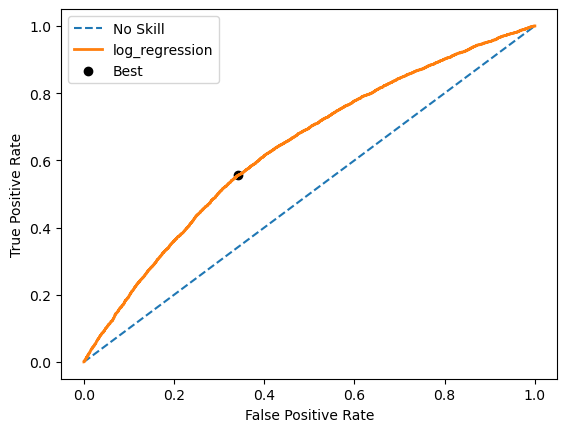

-------------------------
execution time: 48.38 seconds 



In [15]:
baseline_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': False,
        'should_select_features': False,
        'features_to_keep': [],
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'C': 1.0,
            'penalty': 'l2',
            'solver': 'lbfgs',
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'log_regression_baseline'):
    train('log_regression', config=baseline_config, dev_mode=False)

mlflow.end_run()

### Class balancing configuration
We will test 2 techniques to deal with class imbalance:
1. Oversampling the minority class in the training dataset prior to fitting a model with SMOTE and SMOTE-NC techniques. SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. SMOTE-NC is a version of SMOTE adapted for datasets containing both numerical and categorical features.
2. Class weights: assign higher weights to the samples of the minority class and lower weights to the majority class during the training process, this will allow the model to reduce bias towards the majority class.

#### SMOTE

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 08:26:20 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/01/07 08:26:20 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/01/07 08:26:20 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/01/07 08:26:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.63
Cost ratio score: 0.79
Recall: 0.83
Precision: 0.09
F1 score: 0.17
F beta_10: 0.77
Accuracy: 0.33
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.29      0.45     56619
           1       0.09      0.83      0.17      4884

    accuracy                           0.33     61503
   macro avg       0.52      0.56      0.31     61503
weighted avg       0.88      0.33      0.42     61503

Best Threshold: 0.57


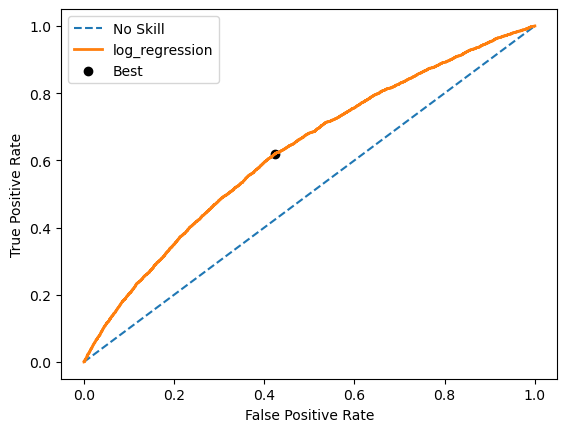

-------------------------
Running predictions with the best threshold


2024/01/07 08:27:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
AUC: 0.63
Cost ratio score: 0.69
Recall: 0.61
Precision: 0.11
F1 score: 0.19
F beta_10: 0.59
Accuracy: 0.58
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.58      0.72     56619
           1       0.11      0.61      0.19      4884

    accuracy                           0.58     61503
   macro avg       0.53      0.60      0.45     61503
weighted avg       0.88      0.58      0.68     61503

Best Threshold: 0.57


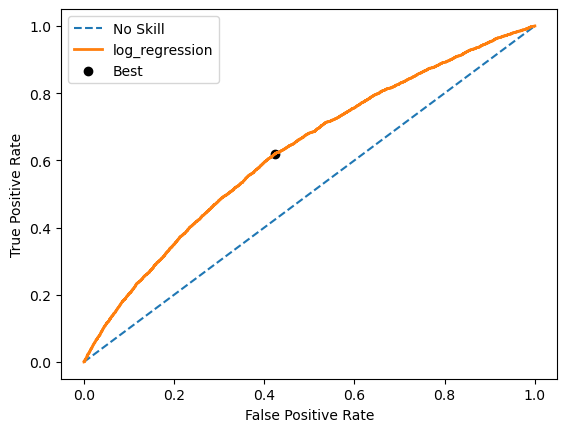

-------------------------
execution time: 69.79 seconds 



In [16]:
smote_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': False,
        'should_select_features': False,
        'features_to_keep': [],
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'C': 1.0,
            'penalty': 'l2',
            'solver': 'lbfgs',
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'log_regression_smote'):
    train('log_regression', config=smote_config, dev_mode=False)

mlflow.end_run()

#### SMOTE-NC

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 08:28:05 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/01/07 08:28:05 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/01/07 08:28:05 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/01/07 08:30:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.63
Cost ratio score: 0.78
Recall: 0.84
Precision: 0.09
F1 score: 0.17
F beta_10: 0.77
Accuracy: 0.33
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.29      0.44     56619
           1       0.09      0.84      0.17      4884

    accuracy                           0.33     61503
   macro avg       0.52      0.56      0.30     61503
weighted avg       0.88      0.33      0.42     61503

Best Threshold: 0.57


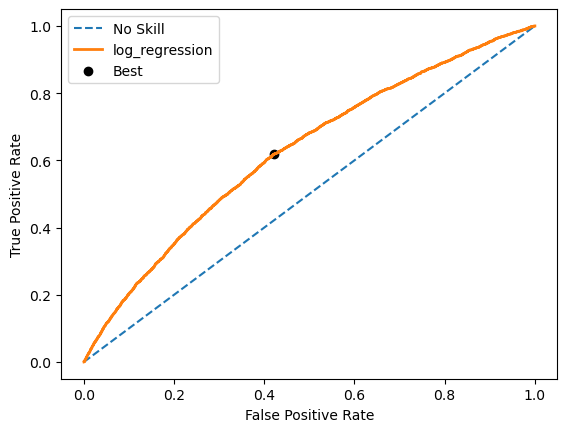

-------------------------
Running predictions with the best threshold


2024/01/07 08:31:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
AUC: 0.63
Cost ratio score: 0.69
Recall: 0.62
Precision: 0.11
F1 score: 0.19
F beta_10: 0.59
Accuracy: 0.58
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.58      0.72     56619
           1       0.11      0.62      0.19      4884

    accuracy                           0.58     61503
   macro avg       0.53      0.60      0.46     61503
weighted avg       0.88      0.58      0.68     61503

Best Threshold: 0.57


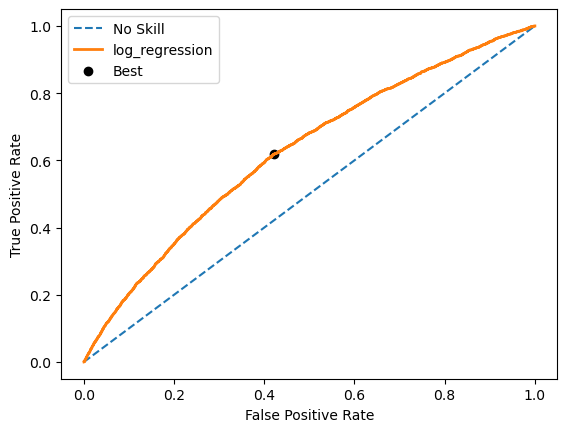

-------------------------
execution time: 209.96 seconds 



In [17]:
smotenc_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': False,
        'should_select_features': False,
        'features_to_keep': [],
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': True
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'C': 1.0,
            'penalty': 'l2',
            'solver': 'lbfgs',
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'log_regression_smotenc'):
    train('log_regression', config=smotenc_config, dev_mode=False)

mlflow.end_run()

#### Class weights

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 08:31:55 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/07 08:32:29 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/07 08:32:32 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/07 08:32:33 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values ha

-------------------------
AUC: 0.63
Cost ratio score: 0.78
Recall: 0.83
Precision: 0.09
F1 score: 0.17
F beta_10: 0.77
Accuracy: 0.34
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.29      0.45     56619
           1       0.09      0.83      0.17      4884

    accuracy                           0.34     61503
   macro avg       0.52      0.56      0.31     61503
weighted avg       0.88      0.34      0.43     61503

Best Threshold: 0.57


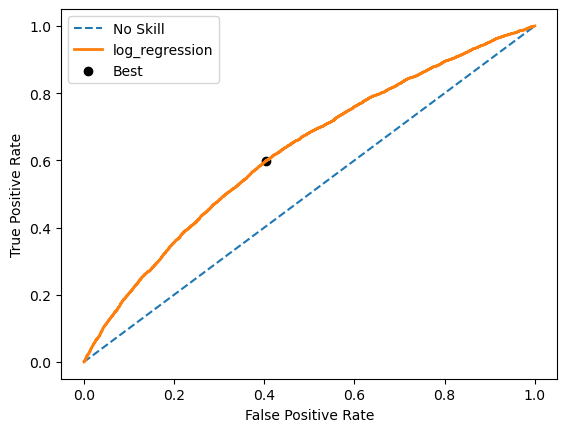

-------------------------
Running predictions with the best threshold


2024/01/07 08:32:34 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.63
Cost ratio score: 0.69
Recall: 0.58
Precision: 0.11
F1 score: 0.19
F beta_10: 0.56
Accuracy: 0.61
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.61      0.74     56619
           1       0.11      0.58      0.19      4884

    accuracy                           0.61     61503
   macro avg       0.53      0.60      0.47     61503
weighted avg       0.88      0.61      0.70     61503

Best Threshold: 0.57


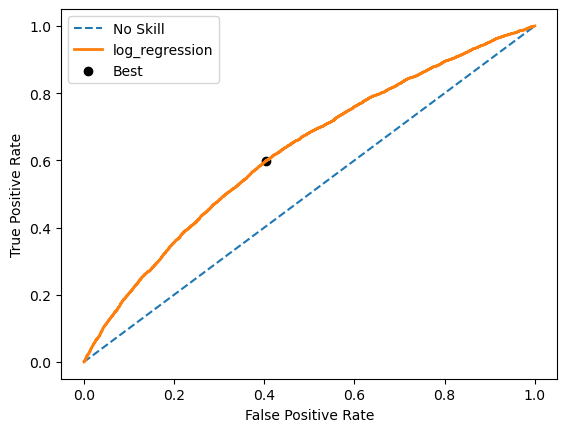

-------------------------
execution time: 45.3 seconds 



In [18]:
class_weights_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': False,
        'should_select_features': False,
        'features_to_keep': [],
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'C': 1.0,
            'penalty': 'l2',
            'solver': 'lbfgs',
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'log_regression_class_weights'):
    train('log_regression', config=class_weights_config, dev_mode=False)

mlflow.end_run()

**Observations**

SMOTE and SMOTE-NC performed better than class weights configuration, and both have the same scores. SMOTE however took less time than SMOTE-NC, so we will keep SMOTE for the further training.

### Feature engineering

We will train the model with different set of features and feature engineering.

#### Credit history
Add previous applications information, bureau and balance.

Set to True:

'use_bureau_and_balance': True <br/>
'use_previous_applications': True

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 08:39:33 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/01/07 08:39:33 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/01/07 08:39:33 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/01/07 08:40:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.66
Cost ratio score: 0.72
Recall: 0.81
Precision: 0.1
F1 score: 0.18
F beta_10: 0.76
Accuracy: 0.41
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.37      0.54     56619
           1       0.10      0.81      0.18      4884

    accuracy                           0.41     61503
   macro avg       0.53      0.59      0.36     61503
weighted avg       0.89      0.41      0.51     61503

Best Threshold: 0.59


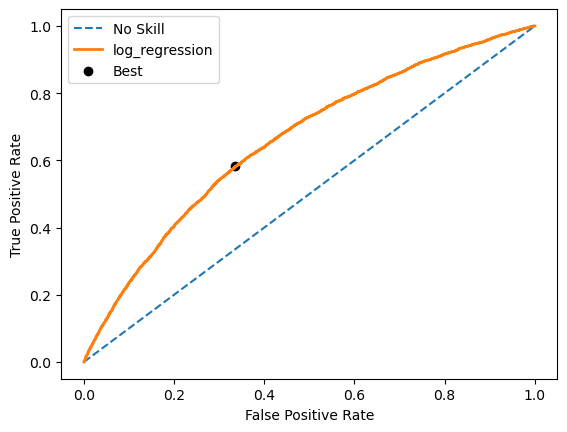

-------------------------
Running predictions with the best threshold


2024/01/07 08:44:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
AUC: 0.66
Cost ratio score: 0.64
Recall: 0.58
Precision: 0.13
F1 score: 0.21
F beta_10: 0.56
Accuracy: 0.65
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.66      0.78     56619
           1       0.13      0.58      0.21      4884

    accuracy                           0.65     61503
   macro avg       0.54      0.62      0.50     61503
weighted avg       0.88      0.65      0.73     61503

Best Threshold: 0.59


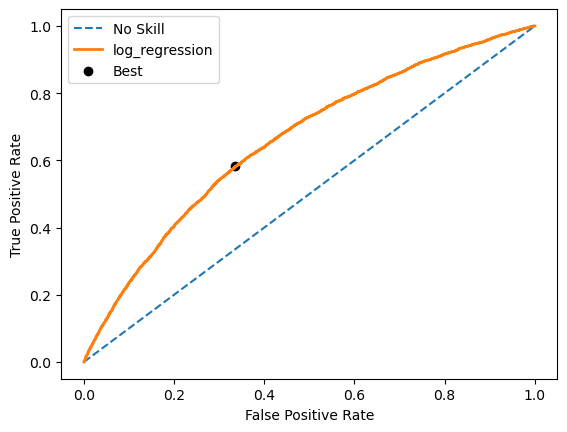

-------------------------
execution time: 335.89 seconds 



In [19]:
credit_history_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': False,
        'should_select_features': False,
        'features_to_keep': [],
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'C': 1.0,
            'penalty': 'l2',
            'solver': 'lbfgs',
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'log_regression_credit_history'):
    train('log_regression', config=credit_history_config, dev_mode=False)

mlflow.end_run()

#### All datasets

Activate other datasets

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 08:46:03 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/01/07 08:46:03 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/01/07 08:46:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/01/07 08:46:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.58
Cost ratio score: 0.78
Recall: 0.08
Precision: 0.11
F1 score: 0.1
F beta_10: 0.08
Accuracy: 0.88
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     56619
           1       0.11      0.08      0.10      4884

    accuracy                           0.88     61503
   macro avg       0.52      0.51      0.51     61503
weighted avg       0.86      0.88      0.87     61503

Best Threshold: 0.48


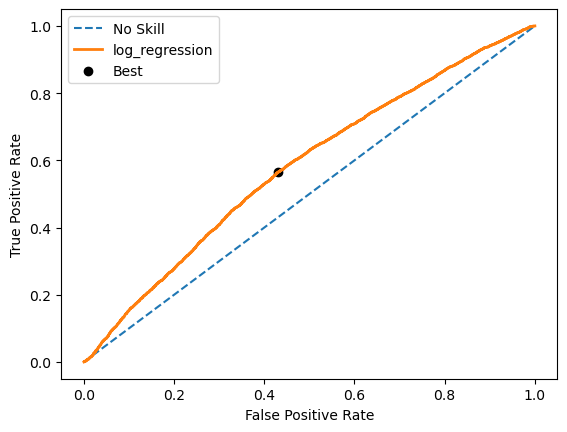

-------------------------
Running predictions with the best threshold


2024/01/07 08:47:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
AUC: 0.58
Cost ratio score: 0.75
Recall: 0.58
Precision: 0.1
F1 score: 0.17
F beta_10: 0.56
Accuracy: 0.55
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.55      0.69     56619
           1       0.10      0.58      0.17      4884

    accuracy                           0.55     61503
   macro avg       0.52      0.57      0.43     61503
weighted avg       0.87      0.55      0.65     61503

Best Threshold: 0.48


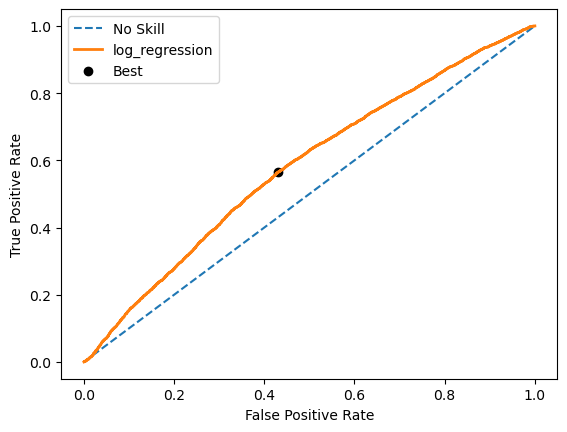

-------------------------
execution time: 123.45 seconds 



In [20]:
full_history_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': False,
        'should_select_features': False,
        'features_to_keep': [],
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'C': 1.0,
            'penalty': 'l2',
            'solver': 'lbfgs',
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'log_regression_full_history'):
    train('log_regression', config=full_history_config, dev_mode=False)

mlflow.end_run()

Adding more features did not improve the Cost Ratio Score but decreased the AUC.

#### Selected features

Train with the features selected during feature optimization. 

In [21]:
best_features = [
    'FLAG_DOCUMENT_3',
    'FLAG_OWN_CAR',
    'PREV_CNT_PAYMENT_MEAN',
    'CC_AMT_BALANCE_MIN',
    'OWN_CAR_AGE',
    'BUREAU_DAYS_CREDIT_ENDDATE_MAX',
    'PREV_DAYS_DECISION_MIN',
    'PREV_AMT_ANNUITY_MIN',
    'BUREAU_AMT_CREDIT_SUM_MAX',
    'AMT_CREDIT',
    'CODE_GENDER_F',
    'DAYS_BIRTH',
    'INSTAL_PAYMENT_DIFF_MEAN',
    'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN',
    'INSTAL_DPD_MAX',
    'DAYS_EMPLOYED',
    'NAME_FAMILY_STATUS_Married',
    'DAYS_LAST_PHONE_CHANGE',
    'POS_MONTHS_BALANCE_MAX',
    'REFUSED_AMT_APPLICATION_MIN',
    'REGION_RATING_CLIENT',
    'ORGANIZATION_TYPE_Self-employed',
    'BUREAU_AMT_CREDIT_SUM_DEBT_MEAN',
    'BUREAU_DAYS_CREDIT_MAX',
    'NAME_EDUCATION_TYPE_Higher education'
]

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 08:49:25 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/01/07 08:49:25 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/01/07 08:49:25 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


-------------------------
AUC: 0.59
Cost ratio score: 0.75
Recall: 0.51
Precision: 0.1
F1 score: 0.17
F beta_10: 0.49
Accuracy: 0.6
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.61      0.74     56619
           1       0.10      0.51      0.17      4884

    accuracy                           0.60     61503
   macro avg       0.52      0.56      0.45     61503
weighted avg       0.87      0.60      0.69     61503

Best Threshold: 0.48


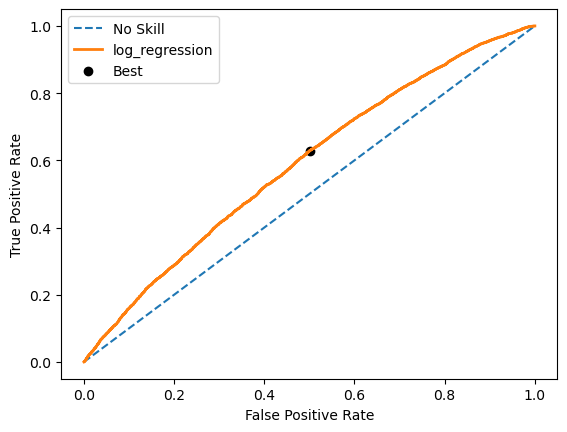

-------------------------
Running predictions with the best threshold
-------------------------
AUC: 0.59
Cost ratio score: 0.76
Recall: 0.64
Precision: 0.1
F1 score: 0.17
F beta_10: 0.6
Accuracy: 0.5
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.49      0.64     56619
           1       0.10      0.64      0.17      4884

    accuracy                           0.50     61503
   macro avg       0.52      0.56      0.41     61503
weighted avg       0.87      0.50      0.61     61503

Best Threshold: 0.48


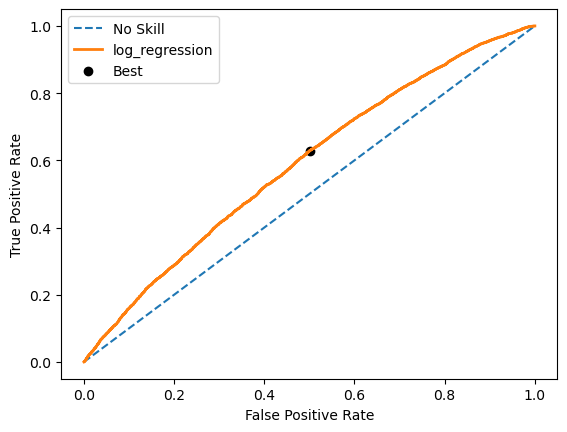

-------------------------
execution time: 83.36 seconds 



In [22]:
selected_features_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': False,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'C': 1.0,
            'penalty': 'l2',
            'solver': 'lbfgs',
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'log_regression_features'):
    train('log_regression', config=selected_features_config, dev_mode=False)

mlflow.end_run()

Providing a limited set of features slightly increased the Cost Ratio Score, but improved the Recall, AUC and Fbeta. Moreover, training went much faster and the model size decreased from 24.02KB to Size: 1.48KB.

### Preprocessing
We will train the model with different preprocessing techniques, like scaling, removing outliers, distribution normalization.


#### Downcasting

Downcasting will allow to decrease memory used by the features (see the Feature Optimization notebook for more details). It should not improve the model scores, the idea is to check if there are any improvements in model training time and size.

Activate `should_downcast` parameter.

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 08:52:37 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/01/07 08:52:37 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/01/07 08:52:37 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/01/07 08:52:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.59
Cost ratio score: 0.75
Recall: 0.51
Precision: 0.1
F1 score: 0.17
F beta_10: 0.49
Accuracy: 0.6
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.61      0.74     56619
           1       0.10      0.51      0.17      4884

    accuracy                           0.60     61503
   macro avg       0.52      0.56      0.45     61503
weighted avg       0.87      0.60      0.69     61503

Best Threshold: 0.48


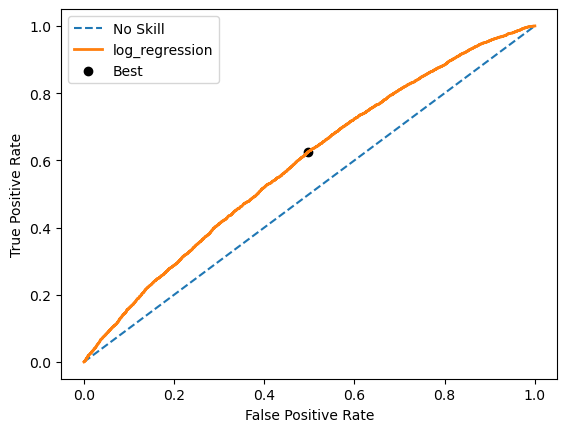

-------------------------
Running predictions with the best threshold


2024/01/07 08:52:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
AUC: 0.59
Cost ratio score: 0.76
Recall: 0.64
Precision: 0.1
F1 score: 0.17
F beta_10: 0.6
Accuracy: 0.5
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.49      0.64     56619
           1       0.10      0.64      0.17      4884

    accuracy                           0.50     61503
   macro avg       0.52      0.56      0.41     61503
weighted avg       0.87      0.50      0.61     61503

Best Threshold: 0.48


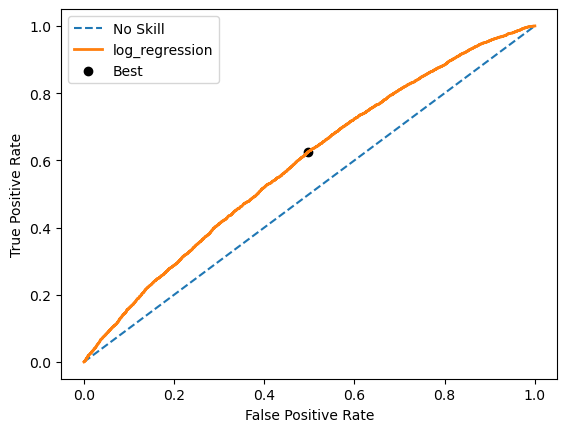

-------------------------
execution time: 89.52 seconds 



In [23]:
downcasting_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'C': 1.0,
            'penalty': 'l2',
            'solver': 'lbfgs',
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'log_regression_downcast'):
    train('log_regression', config=downcasting_config, dev_mode=False)

mlflow.end_run()

Unfortunately we don't observe any improvement in training time and in model size, we will still keep this feature however as it is a part of the dataset optimization.

#### Removing outliers

Activate `should_remove_outliers` and set `iqr_factor` to 1.5

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 08:54:55 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/01/07 08:54:55 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/01/07 08:54:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/01/07 08:54:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.62
Cost ratio score: 0.71
Recall: 0.52
Precision: 0.11
F1 score: 0.19
F beta_10: 0.5
Accuracy: 0.64
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.65      0.77     56619
           1       0.11      0.52      0.19      4884

    accuracy                           0.64     61503
   macro avg       0.53      0.58      0.48     61503
weighted avg       0.87      0.64      0.72     61503

Best Threshold: 0.47


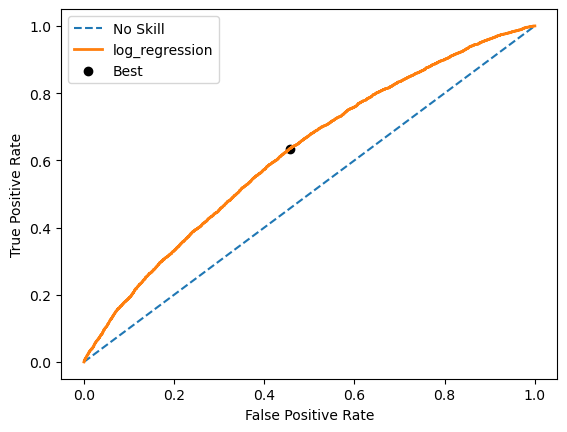

-------------------------
Running predictions with the best threshold


2024/01/07 08:55:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
AUC: 0.62
Cost ratio score: 0.71
Recall: 0.64
Precision: 0.11
F1 score: 0.18
F beta_10: 0.61
Accuracy: 0.55
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.54      0.69     56619
           1       0.11      0.64      0.18      4884

    accuracy                           0.55     61503
   macro avg       0.53      0.59      0.44     61503
weighted avg       0.88      0.55      0.65     61503

Best Threshold: 0.47


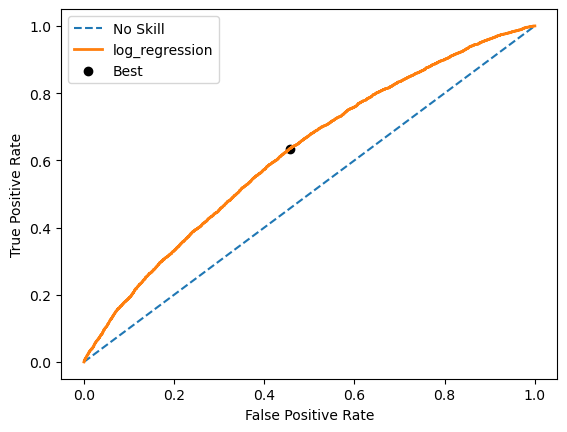

-------------------------
execution time: 89.81 seconds 



In [24]:
outliers_config1 = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'C': 1.0,
            'penalty': 'l2',
            'solver': 'lbfgs',
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'log_regression_outliers_1'):
    train('log_regression', config=outliers_config1, dev_mode=False)

mlflow.end_run()

Change IQR factor to 2.5

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 08:57:12 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/01/07 08:57:12 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/01/07 08:57:12 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/01/07 08:57:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.62
Cost ratio score: 0.71
Recall: 0.51
Precision: 0.11
F1 score: 0.18
F beta_10: 0.49
Accuracy: 0.64
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.65      0.77     56619
           1       0.11      0.51      0.18      4884

    accuracy                           0.64     61503
   macro avg       0.53      0.58      0.48     61503
weighted avg       0.87      0.64      0.72     61503

Best Threshold: 0.49


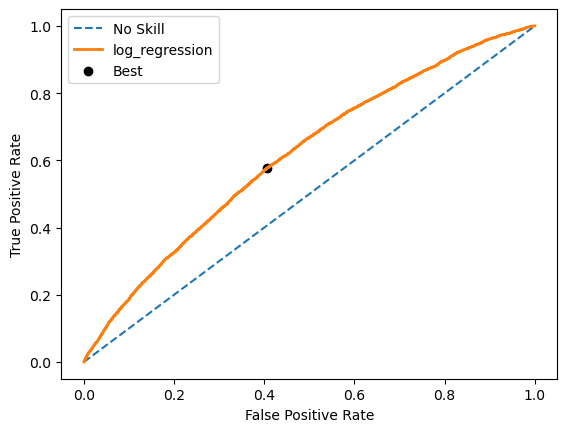

-------------------------
Running predictions with the best threshold


2024/01/07 08:57:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
AUC: 0.62
Cost ratio score: 0.71
Recall: 0.55
Precision: 0.11
F1 score: 0.18
F beta_10: 0.53
Accuracy: 0.61
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.61      0.74     56619
           1       0.11      0.55      0.18      4884

    accuracy                           0.61     61503
   macro avg       0.53      0.58      0.46     61503
weighted avg       0.87      0.61      0.70     61503

Best Threshold: 0.49


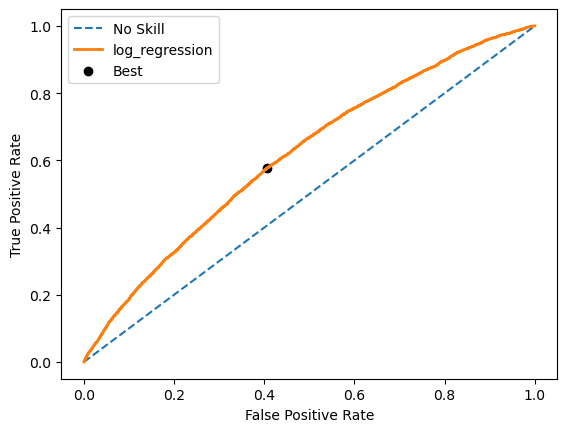

-------------------------
execution time: 87.16 seconds 



In [25]:
outliers_config2 = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 2.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'C': 1.0,
            'penalty': 'l2',
            'solver': 'lbfgs',
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'log_regression_outliers_2'):
    train('log_regression', config=outliers_config2, dev_mode=False)

mlflow.end_run()

Increasing IQR factor didn't affect the Cost Ratio score, slightly increased Accuracy but decreased other metrics (Fbeta score, Recall), so we will keep the 1.5 IQR factor.

#### Scaling
Activate `should_scale` parameter.

Try different scaling methods

**StandardScaler**

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 09:03:45 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/01/07 09:03:45 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/01/07 09:03:45 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/01/07 09:03:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.67
Cost ratio score: 0.63
Recall: 0.57
Precision: 0.13
F1 score: 0.22
F beta_10: 0.56
Accuracy: 0.67
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.68      0.79     56619
           1       0.13      0.57      0.22      4884

    accuracy                           0.67     61503
   macro avg       0.54      0.63      0.50     61503
weighted avg       0.88      0.67      0.75     61503

Best Threshold: 0.47


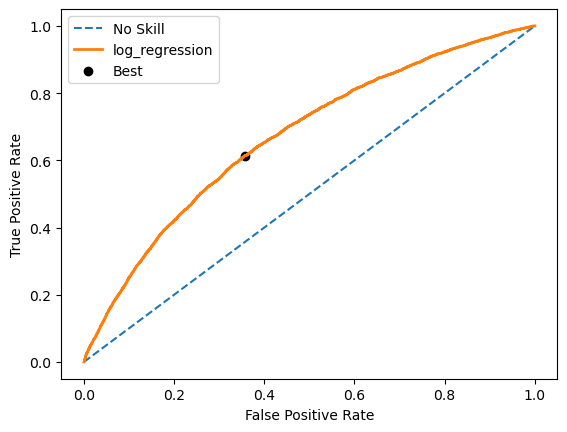

-------------------------
Running predictions with the best threshold


2024/01/07 09:03:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
AUC: 0.67
Cost ratio score: 0.64
Recall: 0.62
Precision: 0.13
F1 score: 0.21
F beta_10: 0.59
Accuracy: 0.64
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.64      0.76     56619
           1       0.13      0.62      0.21      4884

    accuracy                           0.64     61503
   macro avg       0.54      0.63      0.49     61503
weighted avg       0.89      0.64      0.72     61503

Best Threshold: 0.47


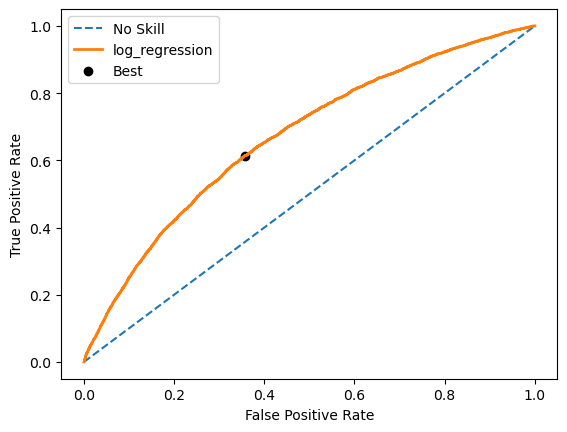

-------------------------
execution time: 93.89 seconds 



In [27]:
standard_scaler_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'C': 1.0,
            'penalty': 'l2',
            'solver': 'lbfgs',
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'log_regression_standard_scaler'):
    train('log_regression', config=standard_scaler_config, dev_mode=False)

mlflow.end_run()

**With MinMaxScaler**

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 09:05:27 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/01/07 09:05:27 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/01/07 09:05:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/01/07 09:05:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.69
Cost ratio score: 0.62
Recall: 0.65
Precision: 0.13
F1 score: 0.22
F beta_10: 0.62
Accuracy: 0.64
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.63      0.76     56619
           1       0.13      0.65      0.22      4884

    accuracy                           0.64     61503
   macro avg       0.54      0.64      0.49     61503
weighted avg       0.89      0.64      0.72     61503

Best Threshold: 0.51


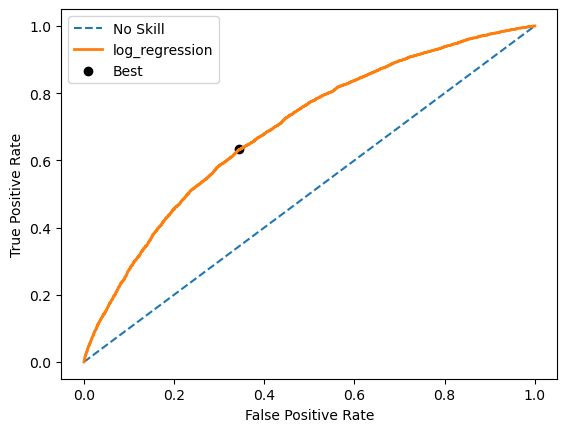

-------------------------
Running predictions with the best threshold


2024/01/07 09:05:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
AUC: 0.69
Cost ratio score: 0.61
Recall: 0.63
Precision: 0.14
F1 score: 0.22
F beta_10: 0.61
Accuracy: 0.65
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.65      0.78     56619
           1       0.14      0.63      0.22      4884

    accuracy                           0.65     61503
   macro avg       0.55      0.64      0.50     61503
weighted avg       0.89      0.65      0.73     61503

Best Threshold: 0.51


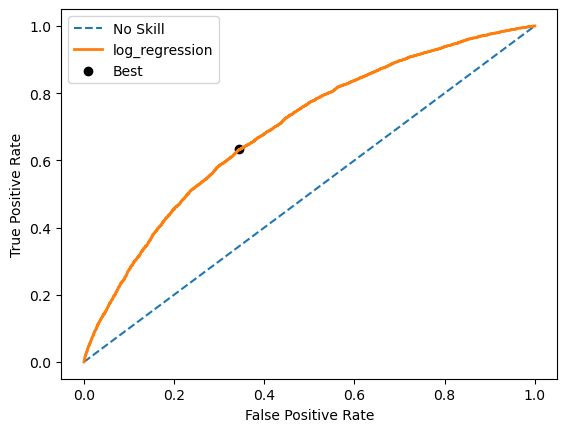

-------------------------
execution time: 95.08 seconds 



In [28]:
minmax_scaler_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': MinMaxScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'C': 1.0,
            'penalty': 'l2',
            'solver': 'lbfgs',
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'log_regression_minmax_scaler'):
    train('log_regression', config=minmax_scaler_config, dev_mode=False)

mlflow.end_run()

**Robust Scaler**

Robust Scaler is robust to outliers therefore we should disable the outliers parameter

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 09:07:20 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/01/07 09:07:20 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/01/07 09:07:20 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/01/07 09:07:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.66
Cost ratio score: 0.64
Recall: 0.55
Precision: 0.13
F1 score: 0.21
F beta_10: 0.53
Accuracy: 0.68
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.69      0.80     56619
           1       0.13      0.55      0.21      4884

    accuracy                           0.68     61503
   macro avg       0.54      0.62      0.50     61503
weighted avg       0.88      0.68      0.75     61503

Best Threshold: 0.48


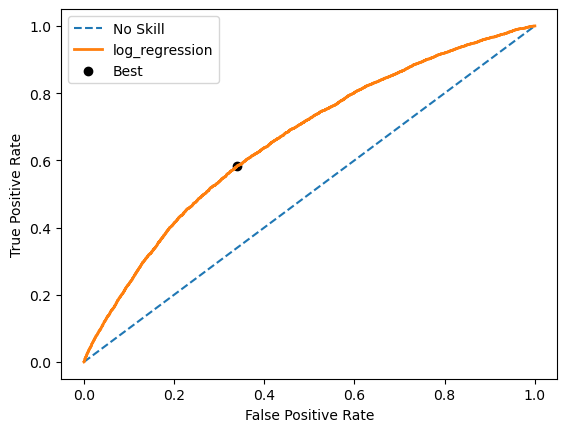

-------------------------
Running predictions with the best threshold


2024/01/07 09:07:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
AUC: 0.66
Cost ratio score: 0.64
Recall: 0.58
Precision: 0.13
F1 score: 0.21
F beta_10: 0.56
Accuracy: 0.65
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.66      0.78     56619
           1       0.13      0.58      0.21      4884

    accuracy                           0.65     61503
   macro avg       0.54      0.62      0.49     61503
weighted avg       0.88      0.65      0.73     61503

Best Threshold: 0.48


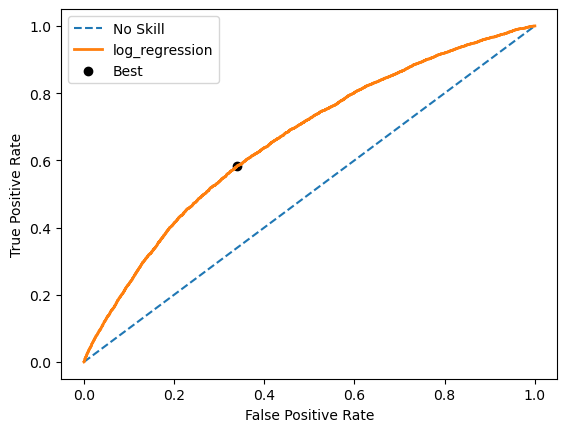

-------------------------
execution time: 85.96 seconds 



In [29]:
robust_scaler_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': RobustScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'C': 1.0,
            'penalty': 'l2',
            'solver': 'lbfgs',
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'log_regression_robust_scaler'):
    train('log_regression', config=robust_scaler_config, dev_mode=False)

mlflow.end_run()

Scaling numeric features hugely improved the model performance, the winner is MinMaxScaler which had a big impact on the Cost Ratio Score, keeping other metrics rather high. 

#### Normalize distribution

We will use the PowerTransformer (defined in the transformers file) to normalize the distribution of numeric features.

Activate `should_normalize_distribution` setting

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 09:10:39 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/01/07 09:10:39 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/01/07 09:10:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/01/07 09:10:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.69
Cost ratio score: 0.62
Recall: 0.63
Precision: 0.13
F1 score: 0.22
F beta_10: 0.61
Accuracy: 0.64
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.64      0.77     56619
           1       0.13      0.63      0.22      4884

    accuracy                           0.64     61503
   macro avg       0.54      0.64      0.49     61503
weighted avg       0.89      0.64      0.73     61503

Best Threshold: 0.47


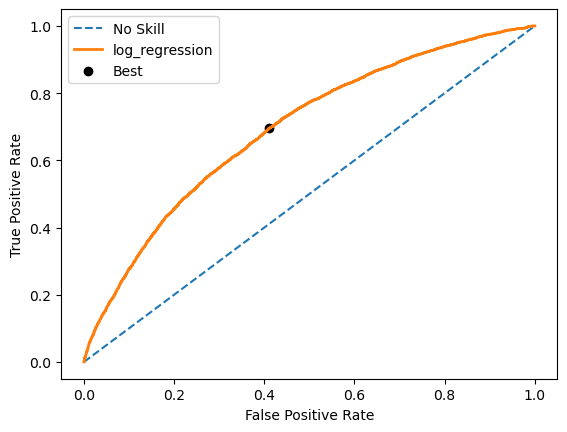

-------------------------
Running predictions with the best threshold


2024/01/07 09:10:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
AUC: 0.69
Cost ratio score: 0.62
Recall: 0.7
Precision: 0.13
F1 score: 0.21
F beta_10: 0.67
Accuracy: 0.6
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.59      0.73     56619
           1       0.13      0.70      0.21      4884

    accuracy                           0.60     61503
   macro avg       0.54      0.64      0.47     61503
weighted avg       0.89      0.60      0.69     61503

Best Threshold: 0.47


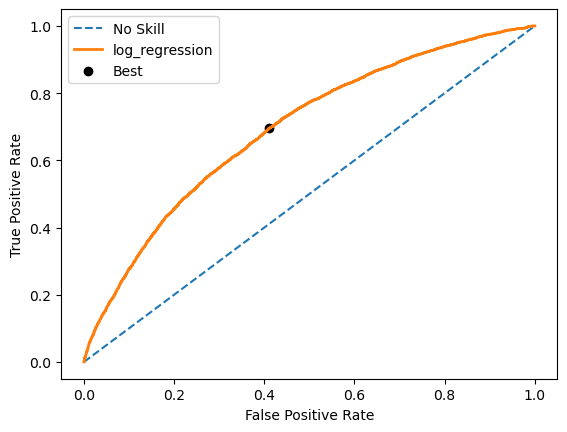

-------------------------
execution time: 126.29 seconds 



In [30]:
norm_dist_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': MinMaxScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': True,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'C': 1.0,
            'penalty': 'l2',
            'solver': 'lbfgs',
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'log_regression_norm_dist'):
    train('log_regression', config=norm_dist_config, dev_mode=False)

mlflow.end_run()

Normalizing distributin didn't help to improve the Cost Ratio Score, it slightly improved however the Recall and Fbeta, the AUC stayed the same. We won't use it in the next iterations.

So we will proceed with the following preprocessing options for the fine-tuning step:

- should_scale: True
- scaler: MinMaxScaler
- should_remove_outliers: True
- iqr_factor: 1.5
- should_normalize_distribution: False

### Fine-tuning

In this step we will use GridSearchCV and RandomizedSearchCV to find the optimal model parameters.

We will try to find the optimal combination of values for the following hyperparameters:

- **C:** inverse of regularization strength; must be a positive float, smaller values specify stronger regularization
- **penalty:** the norm of the penalty
- **solver:** algorithm to use in the optimization problem

#### GridSearchCV

Training the model
Train shape: (80000, 121)
Valid shape: (80000,)
Start pipeline fit and transform


2024/01/07 09:18:05 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100016                       -1634                    -128   
100053                       -2893                   -1764   
100054               ...`
2024/01/07 09:18:05 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
/Users/natche/Jupiter/Project 7/transformers.py:178: FutureWarning: Setting an item of incompatible dtype is deprec

Best score: -0.6674625000000001 with params: {'classifier__C': 0.08, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
    Cost ratio score      C penalty     solver
0            -0.6681 0.0800      l1  liblinear
1            -0.6675 0.0800      l1       saga
2            -0.6683 0.0800      l2  liblinear
3            -0.6677 0.0800      l2       saga
4            -0.6679 0.1000      l1  liblinear
5            -0.6676 0.1000      l1       saga
6            -0.6679 0.1000      l2  liblinear
7            -0.6678 0.1000      l2       saga
8            -0.6677 0.3000      l1  liblinear
9            -0.6678 0.3000      l1       saga
10           -0.6678 0.3000      l2  liblinear
11           -0.6678 0.3000      l2       saga


2024/01/07 09:19:38 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/07 09:19:38 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.64
Cost ratio score: 0.69
Recall: 0.61
Precision: 0.12
F1 score: 0.2
F beta_10: 0.59
Accuracy: 0.6
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.60      0.74     18342
           1       0.12      0.61      0.20      1658

    accuracy                           0.60     20000
   macro avg       0.53      0.61      0.47     20000
weighted avg       0.88      0.60      0.69     20000

Best Threshold: 0.5


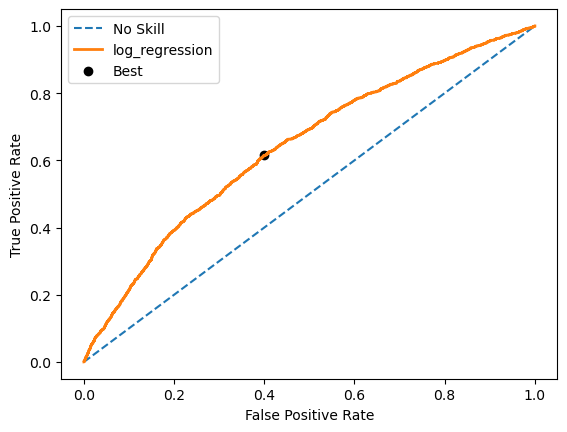

-------------------------
Running predictions with the best threshold


2024/01/07 09:19:39 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.64
Cost ratio score: 0.69
Recall: 0.61
Precision: 0.12
F1 score: 0.2
F beta_10: 0.59
Accuracy: 0.6
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.60      0.74     18342
           1       0.12      0.61      0.20      1658

    accuracy                           0.60     20000
   macro avg       0.53      0.61      0.47     20000
weighted avg       0.88      0.60      0.69     20000

Best Threshold: 0.5


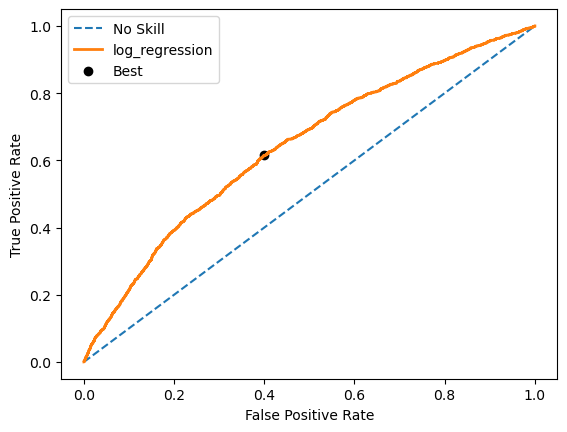

-------------------------
execution time: 97.91 seconds 



In [32]:
grid_search_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': MinMaxScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': True,
        'cv_splits': 5,
        'use_random_grid': False,
        'param_grid': {
            'classifier__C'      : [0.08, 0.1, 0.3], 
            'classifier__penalty': ['l1', 'l2'], 
            'classifier__solver' : ['liblinear', 'saga'],
        },
        'params': {}
    }
}

with mlflow.start_run(run_name = 'log_regression_grid_search'):
    train('log_regression', config=grid_search_config, dev_mode=True)

mlflow.end_run()

Fit the model with the parameters

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 09:25:08 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/01/07 09:25:08 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/01/07 09:25:08 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/01/07 09:25:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.69
Cost ratio score: 0.62
Recall: 0.65
Precision: 0.13
F1 score: 0.22
F beta_10: 0.62
Accuracy: 0.64
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.63      0.76     56619
           1       0.13      0.65      0.22      4884

    accuracy                           0.64     61503
   macro avg       0.54      0.64      0.49     61503
weighted avg       0.89      0.64      0.72     61503

Best Threshold: 0.5099999904632568


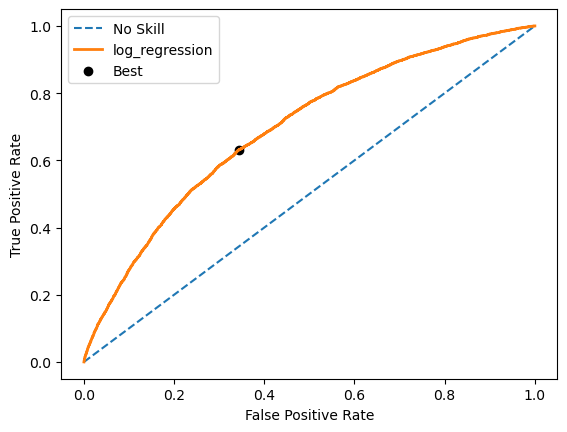

-------------------------
Running predictions with the best threshold


2024/01/07 09:25:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
AUC: 0.69
Cost ratio score: 0.61
Recall: 0.63
Precision: 0.14
F1 score: 0.22
F beta_10: 0.61
Accuracy: 0.65
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.65      0.78     56619
           1       0.14      0.63      0.22      4884

    accuracy                           0.65     61503
   macro avg       0.55      0.64      0.50     61503
weighted avg       0.89      0.65      0.73     61503

Best Threshold: 0.5099999904632568


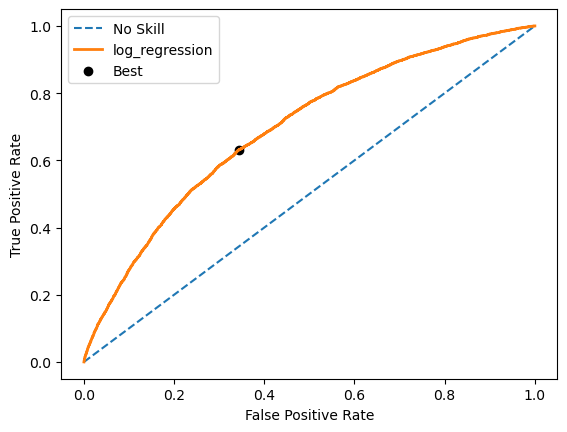

-------------------------
execution time: 94.35 seconds 



In [33]:
grid_search_best_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': MinMaxScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        'params': {
            'C': 0.08,
            'penalty': 'l1',
            'solver': 'saga',
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'log_regression_grid_search_best'):
    train('log_regression', config=grid_search_best_config, dev_mode=False)

mlflow.end_run()

#### RandomizedSearchCV

In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions.

Training the model
Train shape: (80000, 121)
Valid shape: (80000,)
Start pipeline fit and transform


2024/01/07 09:52:42 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100016                       -1634                    -128   
100053                       -2893                   -1764   
100054               ...`
2024/01/07 09:52:43 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use Gr

Best score: -0.666625 with params: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l1', 'classifier__C': 0.013000000000000001}
    Cost ratio score     solver penalty      C
0            -0.6672  liblinear      l1 0.0050
1            -0.6673       saga      l1 0.0050
2            -0.6690  liblinear      l2 0.0050
3            -0.6675       saga      l2 0.0050
4            -0.6667  liblinear      l1 0.0060
5            -0.6676       saga      l1 0.0060
6            -0.6691  liblinear      l2 0.0060
7            -0.6674       saga      l2 0.0060
8            -0.6672  liblinear      l1 0.0070
9            -0.6673       saga      l1 0.0070
10           -0.6690  liblinear      l2 0.0070
11           -0.6671       saga      l2 0.0070
12           -0.6671  liblinear      l1 0.0080
13           -0.6671       saga      l1 0.0080
14           -0.6680  liblinear      l2 0.0080
15           -0.6669       saga      l2 0.0080
16           -0.6670  liblinear      l1 0.0090
17           -0

2024/01/07 10:00:23 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/07 10:00:24 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.64
Cost ratio score: 0.69
Recall: 0.61
Precision: 0.12
F1 score: 0.2
F beta_10: 0.59
Accuracy: 0.61
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.60      0.74     18342
           1       0.12      0.61      0.20      1658

    accuracy                           0.61     20000
   macro avg       0.53      0.61      0.47     20000
weighted avg       0.88      0.61      0.69     20000

Best Threshold: 0.5


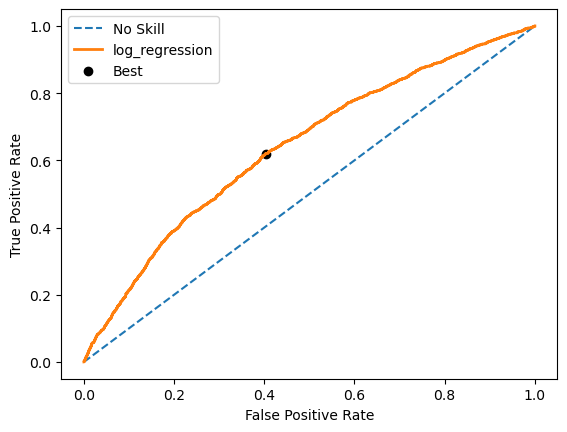

-------------------------
Running predictions with the best threshold


2024/01/07 10:00:24 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.64
Cost ratio score: 0.69
Recall: 0.61
Precision: 0.12
F1 score: 0.2
F beta_10: 0.59
Accuracy: 0.61
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.60      0.74     18342
           1       0.12      0.61      0.20      1658

    accuracy                           0.61     20000
   macro avg       0.53      0.61      0.47     20000
weighted avg       0.88      0.61      0.69     20000

Best Threshold: 0.5


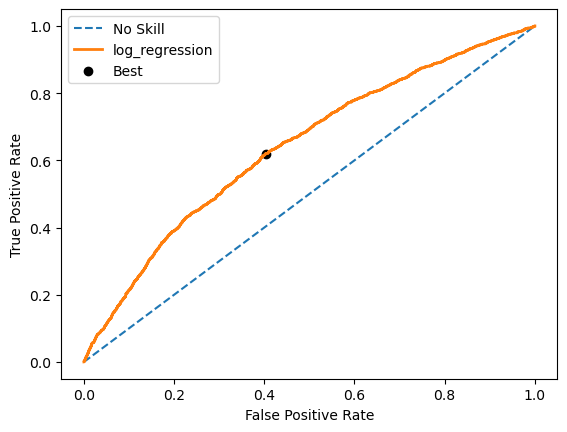

-------------------------
execution time: 466.29 seconds 



In [59]:
random_search_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': MinMaxScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': True,
        'cv_splits': 5,
        'use_random_grid': True,
        'param_grid': {
            'classifier__C'      : np.arange(0.005, 0.02, 0.001),
            'classifier__penalty': ['l1', 'l2'], 
            'classifier__solver' : ['liblinear', 'saga'],
        },
        'params': {}
    }
}

with mlflow.start_run(run_name = 'log_regression_random_search'):
    train('log_regression', config=random_search_config, dev_mode=True)

mlflow.end_run()

Fit the model with the best params.

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 10:02:49 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/01/07 10:02:49 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/01/07 10:02:49 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/01/07 10:02:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.69
Cost ratio score: 0.62
Recall: 0.65
Precision: 0.13
F1 score: 0.22
F beta_10: 0.62
Accuracy: 0.64
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.63      0.76     56619
           1       0.13      0.65      0.22      4884

    accuracy                           0.64     61503
   macro avg       0.54      0.64      0.49     61503
weighted avg       0.89      0.64      0.72     61503

Best Threshold: 0.51


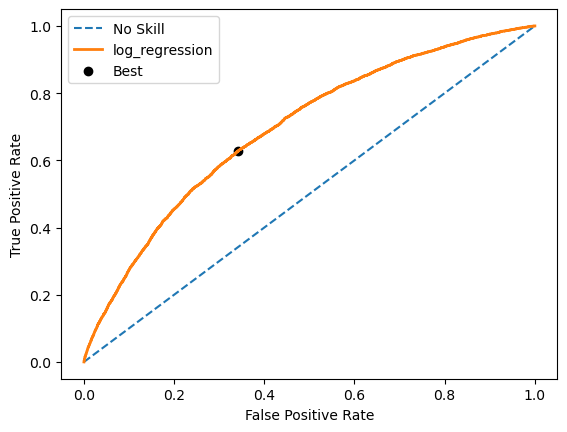

-------------------------
Running predictions with the best threshold


2024/01/07 10:03:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
AUC: 0.69
Cost ratio score: 0.61
Recall: 0.63
Precision: 0.14
F1 score: 0.22
F beta_10: 0.61
Accuracy: 0.65
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.65      0.78     56619
           1       0.14      0.63      0.22      4884

    accuracy                           0.65     61503
   macro avg       0.54      0.64      0.50     61503
weighted avg       0.89      0.65      0.73     61503

Best Threshold: 0.51


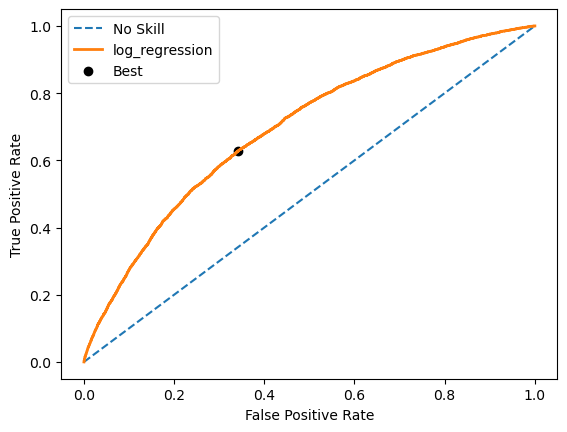

-------------------------
execution time: 100.44 seconds 



In [60]:
random_search_best_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': MinMaxScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        'params': {
            'C': 0.013,
            'penalty': 'l1',
            'solver': 'liblinear',
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'log_regression_random_search_best'):
    train('log_regression', config=random_search_best_config, dev_mode=False)

mlflow.end_run()

#### Results

GridSearchCV and RandomSearchCV gave different sets of parameters, but they performed exactly the same, we will keep the ones of the RandomSearchCV:

- 'C': 0.013
- 'penalty': 'l1'
- 'solver': 'liblinear'

<u>Scores:</u>

- Cost ratio score: 0.61
- AUC: 0.69
- F beta 10: 0.61
- F1 score: 0.22
- Recall: 0.63
- Accuracy: 0.65

## RandomForestClassifier

Random forest is an ensemble learning algorithm that uses a collection of decision trees to make predictions. Each decision tree is trained on a different subset of the data, and the predictions of all the trees are averaged to produce the final prediction. This makes random forest very robust to overfitting and able to handle complex relationships between the features and the target variable.

In [61]:
# Set the experiment
mlflow.set_experiment("Random Forest Classifier")

# Track models automatically
mlflow.sklearn.autolog()

### Baseline

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 10:06:45 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/07 10:08:43 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/07 10:08:47 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/07 10:08:49 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values ha

-------------------------
AUC: 0.71
Cost ratio score: 0.79
Recall: 0.0
Precision: 0.57
F1 score: 0.0
F beta_10: 0.0
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.57      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.75      0.50      0.48     61503
weighted avg       0.89      0.92      0.88     61503

Best Threshold: 0.16


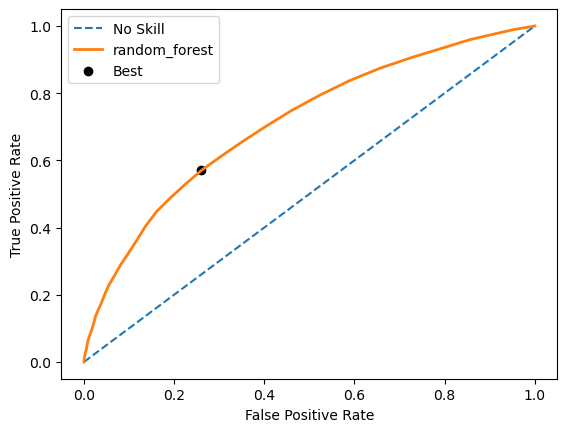

-------------------------
Running predictions with the best threshold


2024/01/07 10:08:51 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.71
Cost ratio score: 0.58
Recall: 0.57
Precision: 0.16
F1 score: 0.25
F beta_10: 0.56
Accuracy: 0.73
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.74      0.83     56619
           1       0.16      0.57      0.25      4884

    accuracy                           0.73     61503
   macro avg       0.56      0.65      0.54     61503
weighted avg       0.89      0.73      0.79     61503

Best Threshold: 0.16


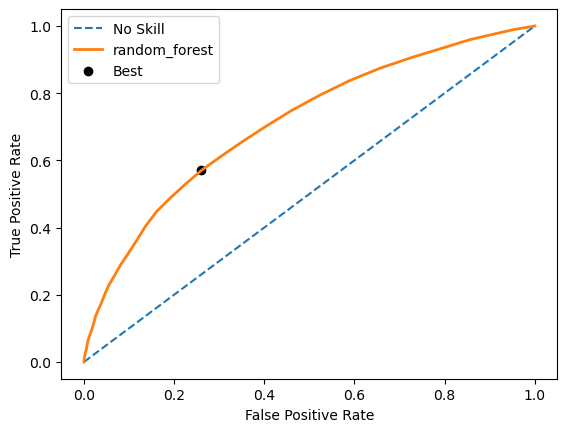

-------------------------
execution time: 132.83 seconds 



In [62]:
baseline_config_rfc = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': False,
        'should_select_features': False,
        'features_to_keep': [],
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'criterion': 'gini',
            'max_features': 'sqrt',
            'max_depth': None,
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'random_forest_baseline'):
    train('random_forest', config=baseline_config_rfc, dev_mode=False)

mlflow.end_run()

### Class balancing configuration

#### SMOTE

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 10:09:22 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/01/07 10:09:22 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/01/07 10:09:22 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/01/07 10:09:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.7
Cost ratio score: 0.79
Recall: 0.0
Precision: 0.0
F1 score: 0.0
F beta_10: 0.0
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.00      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

Best Threshold: 0.14


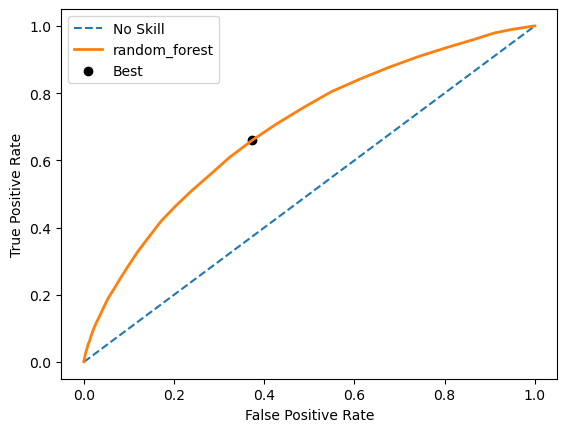

-------------------------
Running predictions with the best threshold


2024/01/07 10:12:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
AUC: 0.7
Cost ratio score: 0.61
Recall: 0.66
Precision: 0.13
F1 score: 0.22
F beta_10: 0.63
Accuracy: 0.63
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.63      0.76     56619
           1       0.13      0.66      0.22      4884

    accuracy                           0.63     61503
   macro avg       0.54      0.64      0.49     61503
weighted avg       0.89      0.63      0.71     61503

Best Threshold: 0.14


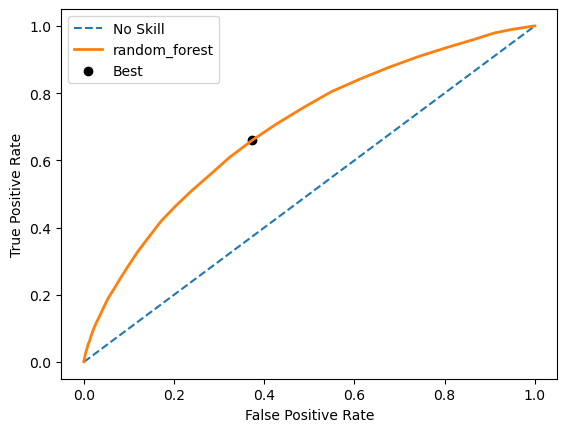

-------------------------
execution time: 218.86 seconds 



In [63]:
smote_config_rfc = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': False,
        'should_select_features': False,
        'features_to_keep': [],
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'criterion': 'gini',
            'max_features': 'sqrt',
            'max_depth': None,
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'random_forest_smote'):
    train('random_forest', config=smote_config_rfc, dev_mode=False)

mlflow.end_run()

#### SMOTE-NC

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 10:13:47 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/01/07 10:13:47 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/01/07 10:13:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/01/07 10:16:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.69
Cost ratio score: 0.79
Recall: 0.0
Precision: 0.23
F1 score: 0.01
F beta_10: 0.0
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.23      0.00      0.01      4884

    accuracy                           0.92     61503
   macro avg       0.58      0.50      0.48     61503
weighted avg       0.87      0.92      0.88     61503

Best Threshold: 0.17


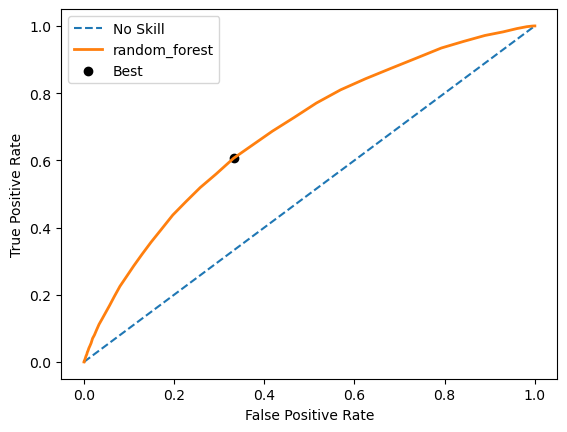

-------------------------
Running predictions with the best threshold


2024/01/07 10:20:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
AUC: 0.69
Cost ratio score: 0.62
Recall: 0.61
Precision: 0.14
F1 score: 0.22
F beta_10: 0.59
Accuracy: 0.66
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.67      0.79     56619
           1       0.14      0.61      0.22      4884

    accuracy                           0.66     61503
   macro avg       0.54      0.64      0.50     61503
weighted avg       0.89      0.66      0.74     61503

Best Threshold: 0.17


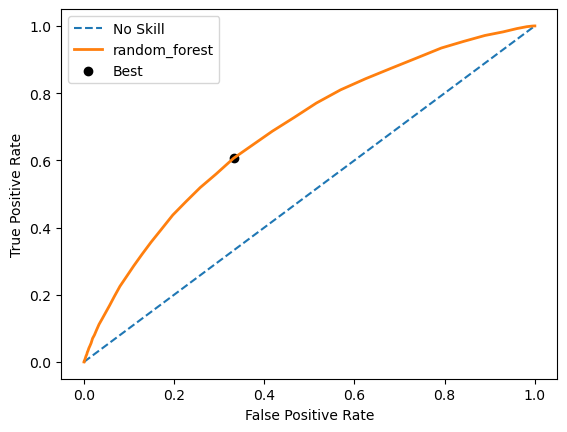

-------------------------
execution time: 393.94 seconds 



In [64]:
smotenc_config_rfc = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': False,
        'should_select_features': False,
        'features_to_keep': [],
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': True
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'criterion': 'gini',
            'max_features': 'sqrt',
            'max_depth': None,
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'random_forest_smotenc'):
    train('random_forest', config=smotenc_config_rfc, dev_mode=False)

mlflow.end_run()

#### Class weights

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 10:21:07 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/07 10:22:50 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/07 10:22:54 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/07 10:22:56 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values ha

-------------------------
AUC: 0.72
Cost ratio score: 0.79
Recall: 0.0
Precision: 0.5
F1 score: 0.0
F beta_10: 0.0
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.50      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.71      0.50      0.48     61503
weighted avg       0.89      0.92      0.88     61503

Best Threshold: 0.09


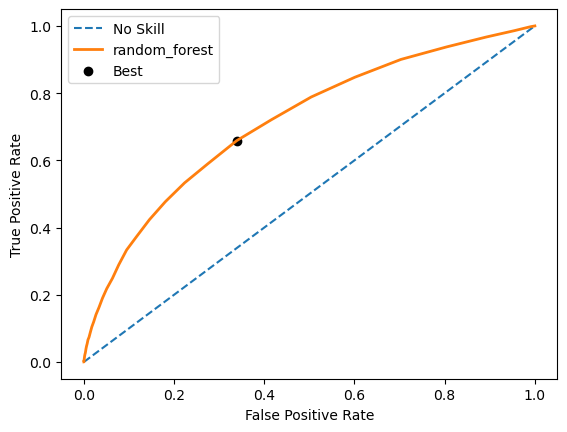

-------------------------
Running predictions with the best threshold


2024/01/07 10:22:59 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.72
Cost ratio score: 0.58
Recall: 0.66
Precision: 0.14
F1 score: 0.24
F beta_10: 0.64
Accuracy: 0.66
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.66      0.78     56619
           1       0.14      0.66      0.24      4884

    accuracy                           0.66     61503
   macro avg       0.55      0.66      0.51     61503
weighted avg       0.89      0.66      0.74     61503

Best Threshold: 0.09


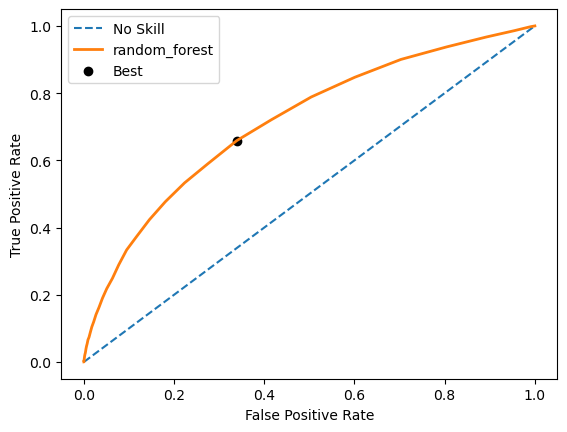

-------------------------
execution time: 118.52 seconds 



In [65]:
class_weights_config_rfc = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': False,
        'should_select_features': False,
        'features_to_keep': [],
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'criterion': 'gini',
            'max_features': 'sqrt',
            'max_depth': None,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'random_forest_class_weights'):
    train('random_forest', config=class_weights_config_rfc, dev_mode=False)

mlflow.end_run()

Among the 3 class balancing methods tested, the **class_weights** performed the best.

### Feature engineering

#### Credit history

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 10:26:50 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/07 10:26:51 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.72
Cost ratio score: 0.79
Recall: 0.0
Precision: 0.67
F1 score: 0.0
F beta_10: 0.0
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.67      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.79      0.50      0.48     61503
weighted avg       0.90      0.92      0.88     61503

Best Threshold: 0.09


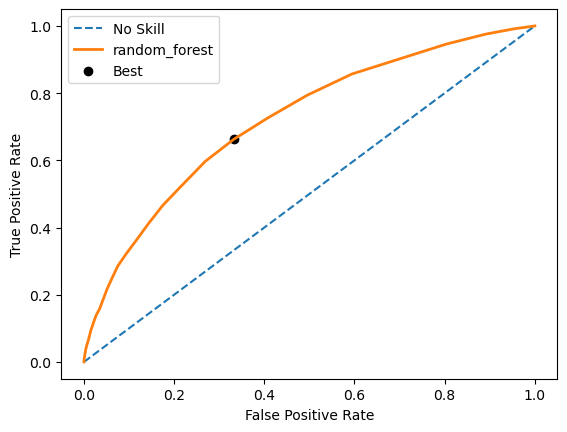

-------------------------
Running predictions with the best threshold


2024/01/07 10:30:32 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.72
Cost ratio score: 0.57
Recall: 0.66
Precision: 0.15
F1 score: 0.24
F beta_10: 0.64
Accuracy: 0.67
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     56619
           1       0.15      0.66      0.24      4884

    accuracy                           0.67     61503
   macro avg       0.55      0.67      0.51     61503
weighted avg       0.89      0.67      0.74     61503

Best Threshold: 0.09


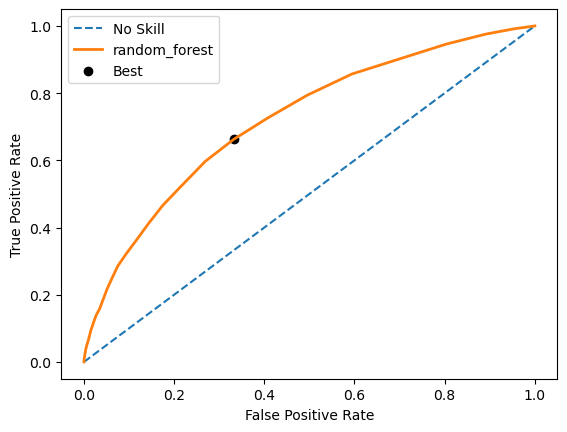

-------------------------
execution time: 245.53 seconds 



In [66]:
credit_history_config_rfc = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': False,
        'should_select_features': False,
        'features_to_keep': [],
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'criterion': 'gini',
            'max_features': 'sqrt',
            'max_depth': None,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'random_forest_credit_history'):
    train('random_forest', config=credit_history_config_rfc, dev_mode=False)

mlflow.end_run()

#### Full history

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 10:31:56 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/07 10:31:58 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.72
Cost ratio score: 0.79
Recall: 0.0
Precision: 0.86
F1 score: 0.0
F beta_10: 0.0
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.86      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.89      0.50      0.48     61503
weighted avg       0.92      0.92      0.88     61503

Best Threshold: 0.1


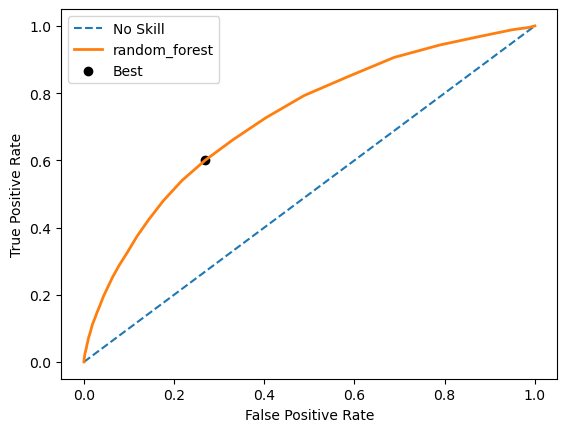

-------------------------
Running predictions with the best threshold


2024/01/07 10:36:01 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.72
Cost ratio score: 0.56
Recall: 0.6
Precision: 0.16
F1 score: 0.25
F beta_10: 0.58
Accuracy: 0.72
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.73      0.83     56619
           1       0.16      0.60      0.25      4884

    accuracy                           0.72     61503
   macro avg       0.56      0.67      0.54     61503
weighted avg       0.89      0.72      0.78     61503

Best Threshold: 0.1


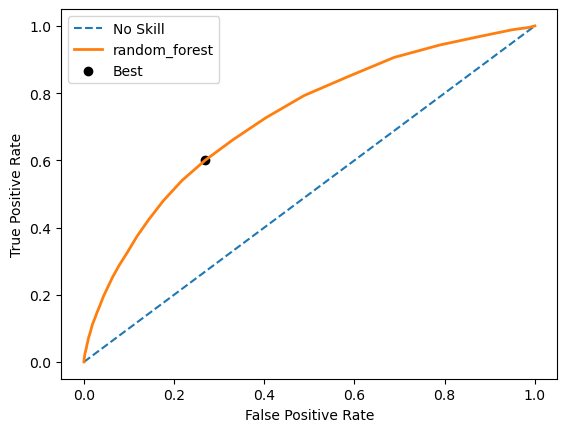

-------------------------
execution time: 298.66 seconds 



In [67]:
full_history_config_rfc = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': False,
        'should_select_features': False,
        'features_to_keep': [],
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'criterion': 'gini',
            'max_features': 'sqrt',
            'max_depth': None,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'random_forest_full_history'):
    train('random_forest', config=full_history_config_rfc, dev_mode=False)

mlflow.end_run()

#### Selected features

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 10:38:25 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/07 10:38:27 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.69
Cost ratio score: 0.79
Recall: 0.0
Precision: 0.62
F1 score: 0.0
F beta_10: 0.0
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.62      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.77      0.50      0.48     61503
weighted avg       0.90      0.92      0.88     61503

Best Threshold: 0.09


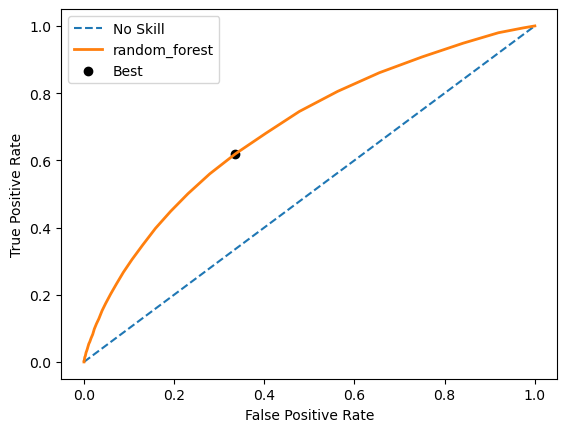

-------------------------
Running predictions with the best threshold


2024/01/07 10:40:39 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.69
Cost ratio score: 0.61
Recall: 0.62
Precision: 0.14
F1 score: 0.22
F beta_10: 0.6
Accuracy: 0.66
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.66      0.78     56619
           1       0.14      0.62      0.22      4884

    accuracy                           0.66     61503
   macro avg       0.55      0.64      0.50     61503
weighted avg       0.89      0.66      0.74     61503

Best Threshold: 0.09


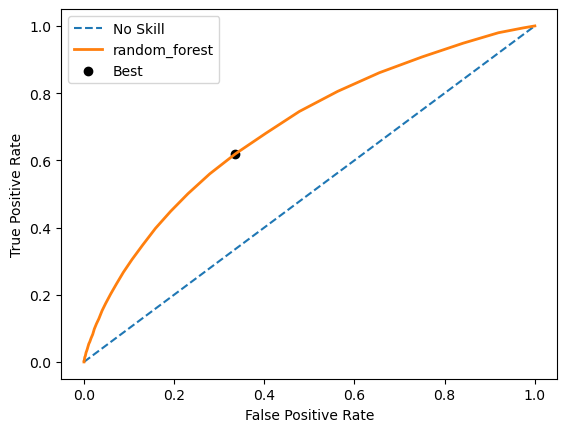

-------------------------
execution time: 186.55 seconds 



In [68]:
best_features_config_rfc = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': False,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'criterion': 'gini',
            'max_features': 'sqrt',
            'max_depth': None,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'random_forest_best_features'):
    train('random_forest', config=best_features_config_rfc, dev_mode=False)

mlflow.end_run()

### Preprocessing

We will activate `should_downcast` for all the following tests.

#### Removing outliers

Random Forest algorithms are known to be robust to outliers. Still, let's test how the outlier removal affects the scores.
Start with IQR factor set to 1.5.

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 10:42:32 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/07 10:42:34 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.68
Cost ratio score: 0.79
Recall: 0.0
Precision: 0.5
F1 score: 0.0
F beta_10: 0.0
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.50      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.71      0.50      0.48     61503
weighted avg       0.89      0.92      0.88     61503

Best Threshold: 0.09


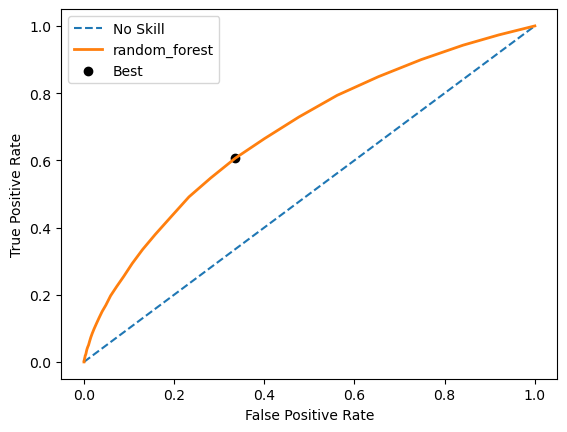

-------------------------
Running predictions with the best threshold


2024/01/07 10:44:55 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.68
Cost ratio score: 0.62
Recall: 0.61
Precision: 0.13
F1 score: 0.22
F beta_10: 0.59
Accuracy: 0.66
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.66      0.78     56619
           1       0.13      0.61      0.22      4884

    accuracy                           0.66     61503
   macro avg       0.54      0.64      0.50     61503
weighted avg       0.89      0.66      0.74     61503

Best Threshold: 0.09


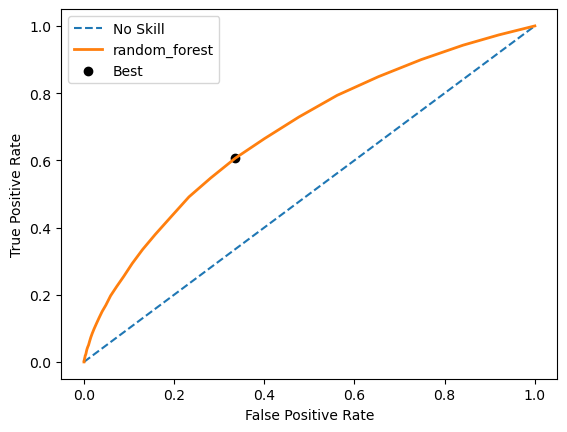

-------------------------
execution time: 197.8 seconds 



In [69]:
remove_outliers1_config_rfc = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'criterion': 'gini',
            'max_features': 'sqrt',
            'max_depth': None,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'random_forest_outliers_1'):
    train('random_forest', config=remove_outliers1_config_rfc, dev_mode=False)

mlflow.end_run()

Testing with IQR = 2.5

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 10:48:28 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/07 10:48:30 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.69
Cost ratio score: 0.79
Recall: 0.0
Precision: 0.6
F1 score: 0.0
F beta_10: 0.0
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.60      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.76      0.50      0.48     61503
weighted avg       0.90      0.92      0.88     61503

Best Threshold: 0.09


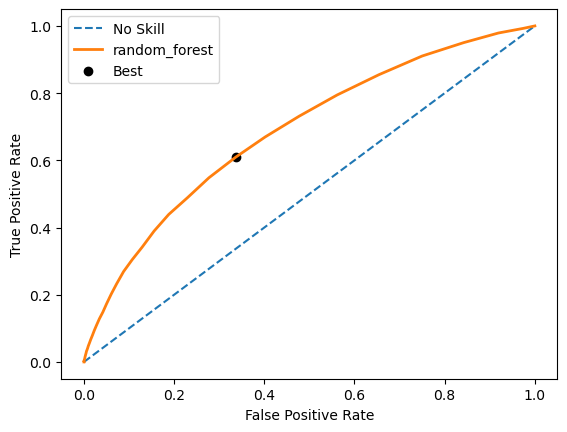

-------------------------
Running predictions with the best threshold


2024/01/07 10:50:54 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.69
Cost ratio score: 0.62
Recall: 0.61
Precision: 0.14
F1 score: 0.22
F beta_10: 0.59
Accuracy: 0.66
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.66      0.78     56619
           1       0.14      0.61      0.22      4884

    accuracy                           0.66     61503
   macro avg       0.54      0.64      0.50     61503
weighted avg       0.89      0.66      0.74     61503

Best Threshold: 0.09


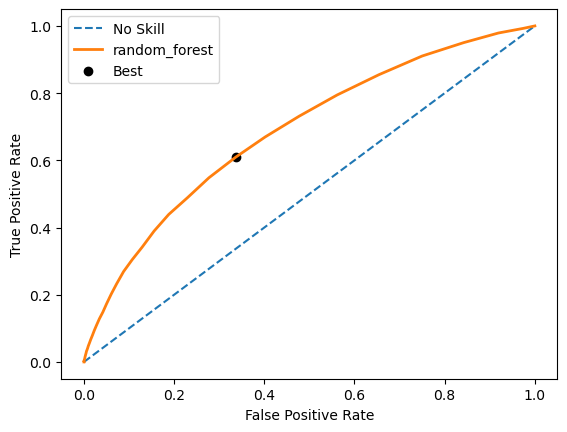

-------------------------
execution time: 202.13 seconds 



In [70]:
remove_outliers2_config_rfc = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 2.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'criterion': 'gini',
            'max_features': 'sqrt',
            'max_depth': None,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'random_forest_outliers_2'):
    train('random_forest', config=remove_outliers2_config_rfc, dev_mode=False)

mlflow.end_run()

Removing outliers degraded the Cost Ratio Score, so we will poursue our tests with outliers.

#### Scaling

**StandardScaler** 

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 10:54:12 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/07 10:54:14 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.69
Cost ratio score: 0.79
Recall: 0.0
Precision: 0.5
F1 score: 0.0
F beta_10: 0.0
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.50      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.71      0.50      0.48     61503
weighted avg       0.89      0.92      0.88     61503

Best Threshold: 0.08


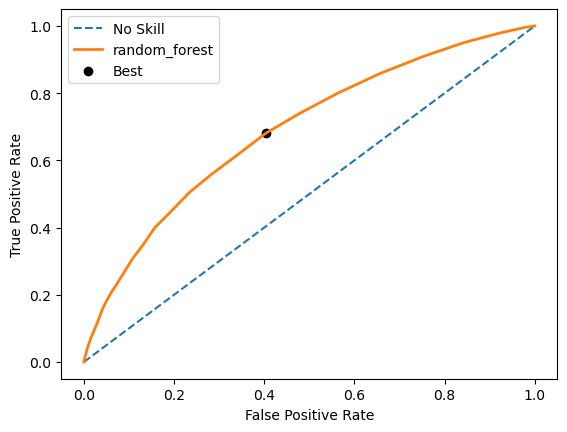

-------------------------
Running predictions with the best threshold


2024/01/07 10:56:35 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.69
Cost ratio score: 0.63
Recall: 0.68
Precision: 0.13
F1 score: 0.21
F beta_10: 0.65
Accuracy: 0.6
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.60      0.73     56619
           1       0.13      0.68      0.21      4884

    accuracy                           0.60     61503
   macro avg       0.54      0.64      0.47     61503
weighted avg       0.89      0.60      0.69     61503

Best Threshold: 0.08


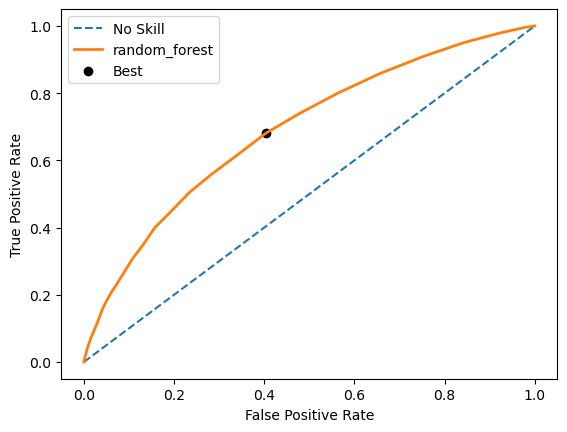

-------------------------
execution time: 194.22 seconds 



In [71]:
standard_scaler_config_rfc = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'criterion': 'gini',
            'max_features': 'sqrt',
            'max_depth': None,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'random_forest_standard_scaler'):
    train('random_forest', config=standard_scaler_config_rfc, dev_mode=False)

mlflow.end_run()

**MinMaxScaler**

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 10:58:26 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/07 10:58:28 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.69
Cost ratio score: 0.79
Recall: 0.0
Precision: 0.62
F1 score: 0.0
F beta_10: 0.0
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.62      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.77      0.50      0.48     61503
weighted avg       0.90      0.92      0.88     61503

Best Threshold: 0.09


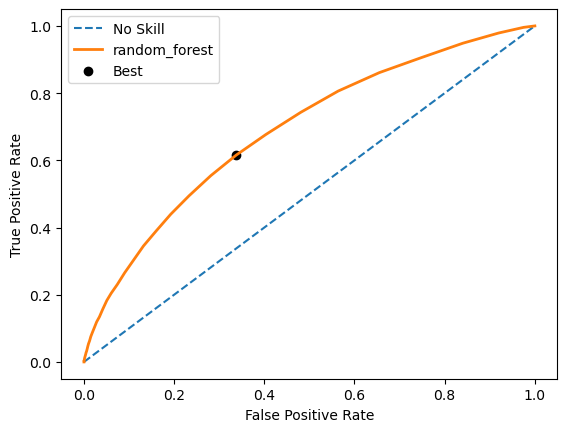

-------------------------
Running predictions with the best threshold


2024/01/07 11:00:52 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.69
Cost ratio score: 0.62
Recall: 0.62
Precision: 0.14
F1 score: 0.22
F beta_10: 0.59
Accuracy: 0.66
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.66      0.78     56619
           1       0.14      0.62      0.22      4884

    accuracy                           0.66     61503
   macro avg       0.54      0.64      0.50     61503
weighted avg       0.89      0.66      0.74     61503

Best Threshold: 0.09


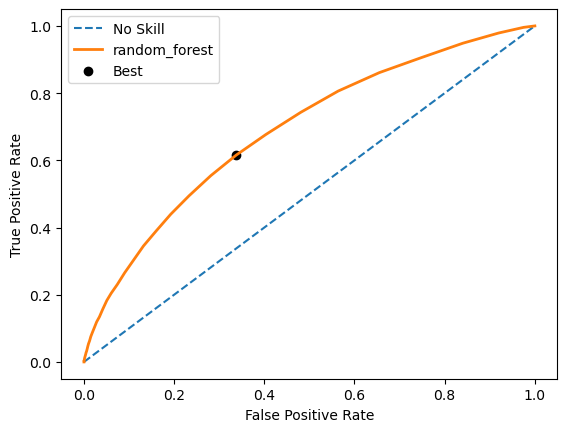

-------------------------
execution time: 199.27 seconds 



In [73]:
minmax_scaler_config_rfc = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': MinMaxScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'criterion': 'gini',
            'max_features': 'sqrt',
            'max_depth': None,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'random_forest_minmax_scaler'):
    train('random_forest', config=minmax_scaler_config_rfc, dev_mode=False)

mlflow.end_run()

**RobustScaler**

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 11:02:39 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/07 11:02:41 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.69
Cost ratio score: 0.79
Recall: 0.0
Precision: 0.5
F1 score: 0.0
F beta_10: 0.0
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.50      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.71      0.50      0.48     61503
weighted avg       0.89      0.92      0.88     61503

Best Threshold: 0.09


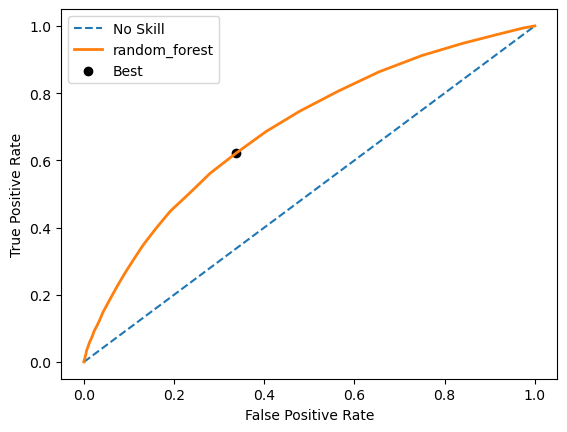

-------------------------
Running predictions with the best threshold


2024/01/07 11:05:07 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.69
Cost ratio score: 0.61
Recall: 0.62
Precision: 0.14
F1 score: 0.22
F beta_10: 0.6
Accuracy: 0.66
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.66      0.78     56619
           1       0.14      0.62      0.22      4884

    accuracy                           0.66     61503
   macro avg       0.55      0.64      0.50     61503
weighted avg       0.89      0.66      0.74     61503

Best Threshold: 0.09


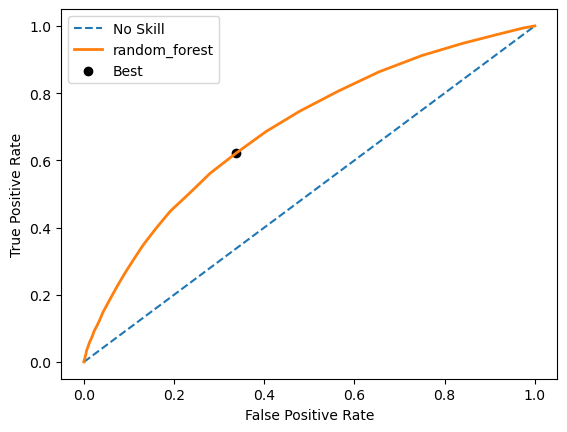

-------------------------
execution time: 201.92 seconds 



In [74]:
robust_scaler_config_rfc = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': RobustScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'criterion': 'gini',
            'max_features': 'sqrt',
            'max_depth': None,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'random_forest_robust_scaler'):
    train('random_forest', config=robust_scaler_config_rfc, dev_mode=False)

mlflow.end_run()

Scaling with StandardScaler and MinMaxScaler degraded the main score, while RobustScaler didn't have any effect.
Doing next steps without scaling.

#### Normalize distribution

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 11:10:35 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/07 11:10:36 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.69
Cost ratio score: 0.79
Recall: 0.0
Precision: 0.6
F1 score: 0.0
F beta_10: 0.0
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.60      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.76      0.50      0.48     61503
weighted avg       0.90      0.92      0.88     61503

Best Threshold: 0.1


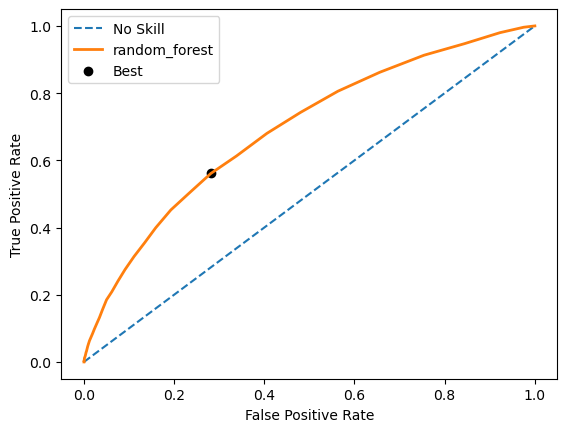

-------------------------
Running predictions with the best threshold


2024/01/07 11:13:39 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.69
Cost ratio score: 0.61
Recall: 0.56
Precision: 0.15
F1 score: 0.23
F beta_10: 0.55
Accuracy: 0.71
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     56619
           1       0.15      0.56      0.23      4884

    accuracy                           0.71     61503
   macro avg       0.55      0.64      0.53     61503
weighted avg       0.89      0.71      0.77     61503

Best Threshold: 0.1


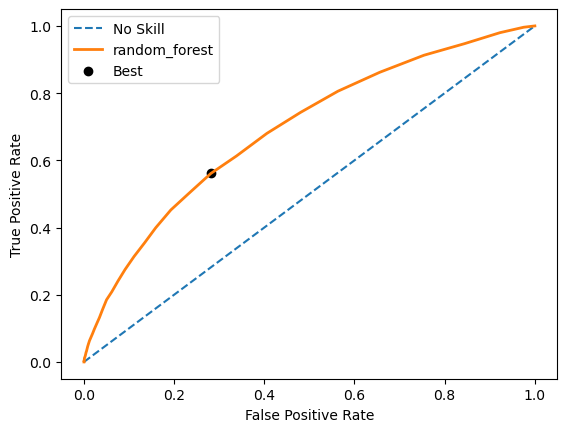

-------------------------
execution time: 237.62 seconds 



In [75]:
norm_dist_config_rfc = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': None,
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': True,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'criterion': 'gini',
            'max_features': 'sqrt',
            'max_depth': None,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'random_forest_norm_dist'):
    train('random_forest', config=norm_dist_config_rfc, dev_mode=False)

mlflow.end_run()

Normalizing distribution slightly increased Accuracy, but did not change the Cost Ratio score and AUC, and degraded F beta 10 and Recall.

We will keep the following preprocessing configuration for the fine-tuning step:

- should_scale: False
- should_remove_outliers: False
- should_normalize_distribution: False

### Fine-tuning

The following parameters will be optimized:

- **n_estimators:** the number of trees in the forest
- **criterion:** the function to measure the quality of a split
- **max_features:** the number of features to consider when looking for the best split
- **max_depth:** the maximum depth of the tree

#### GridSearchCV

Training the model
Train shape: (80000, 121)
Valid shape: (80000,)
Start pipeline fit and transform


2024/01/07 11:33:25 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cleaner', ApplicationCleaner()),
                                 ('feature_extractor',
                                  ApplicationFeaturesExtractor()),
                                 ('merge_bureau_and_balance',
                                  ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100016    ...`
2024/01/07 11:33:26 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by

Best score: -0.642775 with params: {'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': 8, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 100}
    Cost ratio score class_weight criterion  max_depth max_features  \
0                NaN     balanced      gini          6         auto   
1                NaN     balanced      gini          6         auto   
2                NaN     balanced      gini          6         auto   
3            -0.6483     balanced      gini          6         sqrt   
4            -0.6476     balanced      gini          6         sqrt   
..               ...          ...       ...        ...          ...   
67           -0.6640     balanced   entropy         13         sqrt   
68           -0.6647     balanced   entropy         13         sqrt   
69           -0.6638     balanced   entropy         13         log2   
70           -0.6640     balanced   entropy         13         log2   
71           

2024/01/07 11:40:22 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/07 11:40:23 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.65
Cost ratio score: 0.68
Recall: 0.53
Precision: 0.13
F1 score: 0.21
F beta_10: 0.52
Accuracy: 0.67
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.68      0.79     18342
           1       0.13      0.53      0.21      1658

    accuracy                           0.67     20000
   macro avg       0.54      0.61      0.50     20000
weighted avg       0.87      0.67      0.74     20000

Best Threshold: 0.49


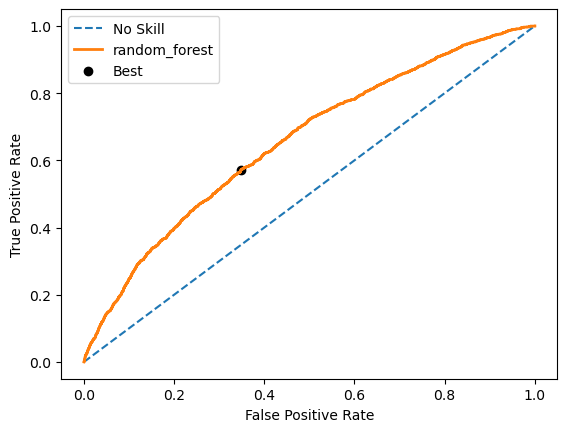

-------------------------
Running predictions with the best threshold


2024/01/07 11:40:23 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.65
Cost ratio score: 0.68
Recall: 0.56
Precision: 0.13
F1 score: 0.21
F beta_10: 0.54
Accuracy: 0.65
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.66      0.78     18342
           1       0.13      0.56      0.21      1658

    accuracy                           0.65     20000
   macro avg       0.54      0.61      0.49     20000
weighted avg       0.88      0.65      0.73     20000

Best Threshold: 0.49


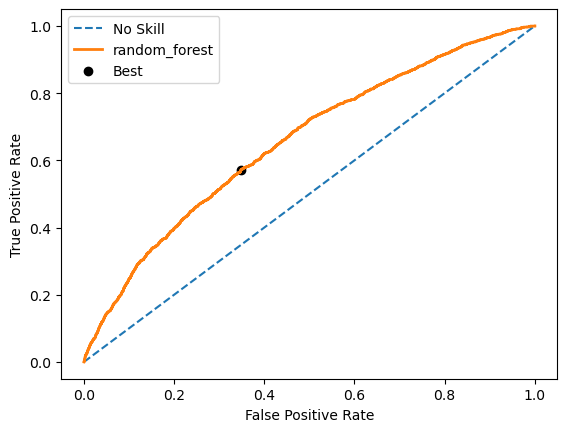

-------------------------
execution time: 422.87 seconds 



In [79]:
grid_search_config_rfc = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
       'random_state': 42,
        'use_cv': True,
        'cv_splits': 5,
        'use_random_grid': False,
        'param_grid': {
            'classifier__n_estimators': [80, 100, 120], 
            'classifier__criterion': ['gini', 'entropy'], 
            'classifier__max_features' : ['auto', 'sqrt', 'log2'],
            'classifier__max_depth' : [6, 8, 10, 13],
            'classifier__class_weight' : ['balanced']
        },
        'params': {}
    }
}

with mlflow.start_run(run_name = 'random_forest_grid_search'):
    train('random_forest', config=grid_search_config_rfc, dev_mode=True)

mlflow.end_run()

In [78]:
mlflow.end_run()

**GridSearch best config**

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 11:43:01 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/07 11:43:03 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.7
Cost ratio score: 0.6
Recall: 0.6
Precision: 0.14
F1 score: 0.23
F beta_10: 0.58
Accuracy: 0.68
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.69      0.80     56619
           1       0.14      0.60      0.23      4884

    accuracy                           0.68     61503
   macro avg       0.55      0.64      0.51     61503
weighted avg       0.89      0.68      0.75     61503

Best Threshold: 0.49


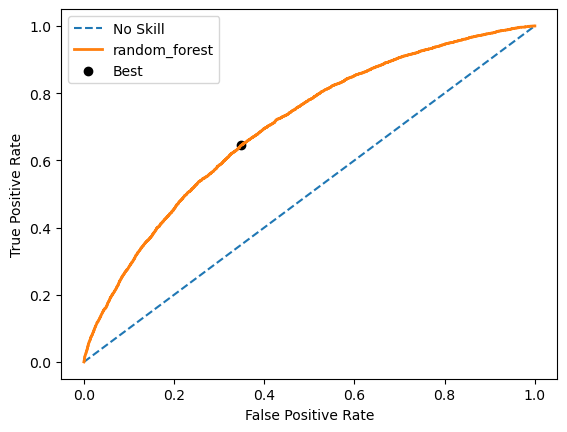

-------------------------
Running predictions with the best threshold


2024/01/07 11:44:33 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.7
Cost ratio score: 0.6
Recall: 0.64
Precision: 0.14
F1 score: 0.23
F beta_10: 0.61
Accuracy: 0.66
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.66      0.78     56619
           1       0.14      0.64      0.23      4884

    accuracy                           0.66     61503
   macro avg       0.55      0.65      0.50     61503
weighted avg       0.89      0.66      0.73     61503

Best Threshold: 0.49


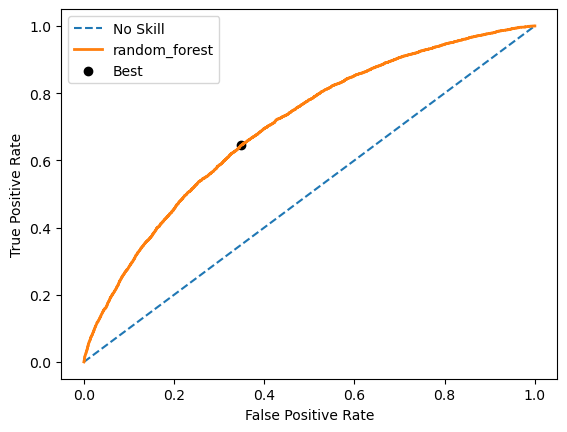

-------------------------
execution time: 144.11 seconds 



In [81]:
grid_search_best_config_rfc = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
       'random_state': 42,
        'use_cv': False,
        'params': {
            'n_estimators': 100,
            'criterion': 'gini',
            'max_features': 'sqrt',
            'max_depth': 8,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'random_forest_grid_search_best'):
    train('random_forest', config=grid_search_best_config_rfc, dev_mode=False)

mlflow.end_run()

Let's do a further refinement with RandomizedSearchCV

#### RandomizedSearchCV

Training the model
Train shape: (80000, 121)
Valid shape: (80000,)
Start pipeline fit and transform


2024/01/07 12:17:17 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cleaner', ApplicationCleaner()),
                                 ('feature_extractor',
                                  ApplicationFeaturesExtractor()),
                                 ('merge_bureau_and_balance',
                                  ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100016    ...`
2024/01/07 12:17:18 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use Gr

Best score: -0.642775 with params: {'classifier__n_estimators': 100, 'classifier__max_features': 'log2', 'classifier__max_depth': 8, 'classifier__criterion': 'gini', 'classifier__class_weight': 'balanced'}
    Cost ratio score  n_estimators max_features  max_depth criterion  \
0            -0.6446            80         log2          8      gini   
1            -0.6442            90         log2          8      gini   
2            -0.6428           100         log2          8      gini   
3            -0.6449           110         log2          8      gini   
4            -0.6446            80         sqrt          8      gini   
5            -0.6442            90         sqrt          8      gini   
6            -0.6428           100         sqrt          8      gini   
7            -0.6449           110         sqrt          8      gini   
8            -0.6549            80         None          8      gini   
9            -0.6532            90         None          8      gini   
10

2024/01/07 12:23:12 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/07 12:23:13 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.65
Cost ratio score: 0.68
Recall: 0.53
Precision: 0.13
F1 score: 0.21
F beta_10: 0.52
Accuracy: 0.67
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.68      0.79     18342
           1       0.13      0.53      0.21      1658

    accuracy                           0.67     20000
   macro avg       0.54      0.61      0.50     20000
weighted avg       0.87      0.67      0.74     20000

Best Threshold: 0.49


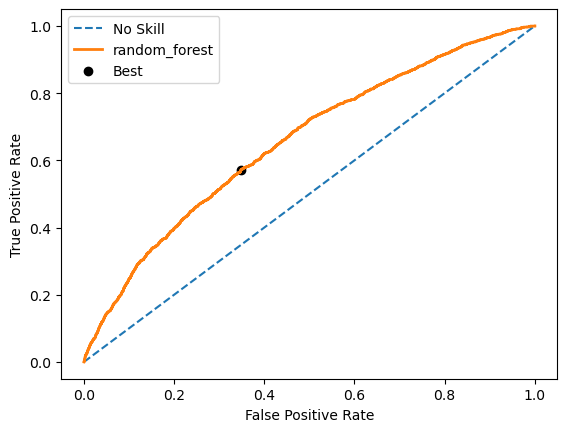

-------------------------
Running predictions with the best threshold


2024/01/07 12:23:14 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.65
Cost ratio score: 0.68
Recall: 0.56
Precision: 0.13
F1 score: 0.21
F beta_10: 0.54
Accuracy: 0.65
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.66      0.78     18342
           1       0.13      0.56      0.21      1658

    accuracy                           0.65     20000
   macro avg       0.54      0.61      0.49     20000
weighted avg       0.88      0.65      0.73     20000

Best Threshold: 0.49


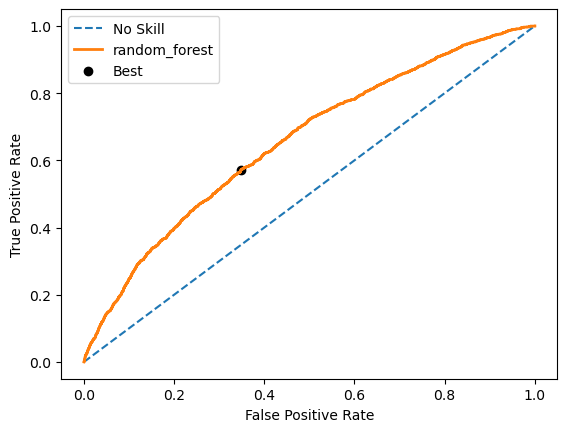

-------------------------
execution time: 361.74 seconds 



In [85]:
random_search_config_rfc = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
       'random_state': 42,
        'use_cv': True,
        'cv_splits': 5,
        'use_random_grid': True,
        'param_grid': {
            'classifier__n_estimators': [80, 90, 100, 110], 
            'classifier__criterion': ['gini'], 
            'classifier__max_features' : ['log2', 'sqrt', None],
            'classifier__max_depth' : [8, 9, 10, 11],
            'classifier__class_weight' : ['balanced']
        },
        'params': {}
    }
}

with mlflow.start_run(run_name = 'random_forest_random_search'):
    train('random_forest', config=random_search_config_rfc, dev_mode=True)

mlflow.end_run()

**RandomizedSearchCV best config**

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/07 12:26:48 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/07 12:26:49 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.7
Cost ratio score: 0.6
Recall: 0.6
Precision: 0.14
F1 score: 0.23
F beta_10: 0.58
Accuracy: 0.68
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.69      0.80     56619
           1       0.14      0.60      0.23      4884

    accuracy                           0.68     61503
   macro avg       0.55      0.64      0.51     61503
weighted avg       0.89      0.68      0.75     61503

Best Threshold: 0.49


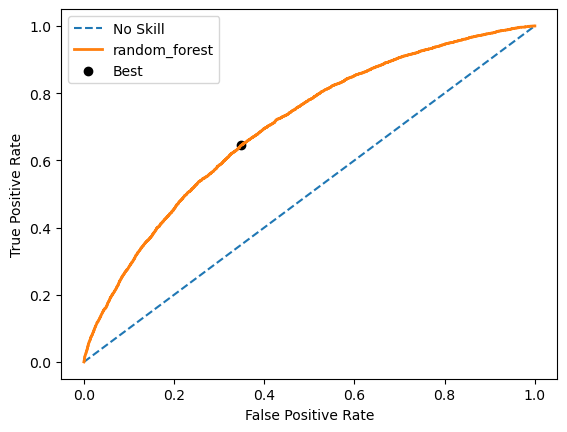

-------------------------
Running predictions with the best threshold


2024/01/07 12:28:21 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.7
Cost ratio score: 0.6
Recall: 0.64
Precision: 0.14
F1 score: 0.23
F beta_10: 0.61
Accuracy: 0.66
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.66      0.78     56619
           1       0.14      0.64      0.23      4884

    accuracy                           0.66     61503
   macro avg       0.55      0.65      0.50     61503
weighted avg       0.89      0.66      0.73     61503

Best Threshold: 0.49


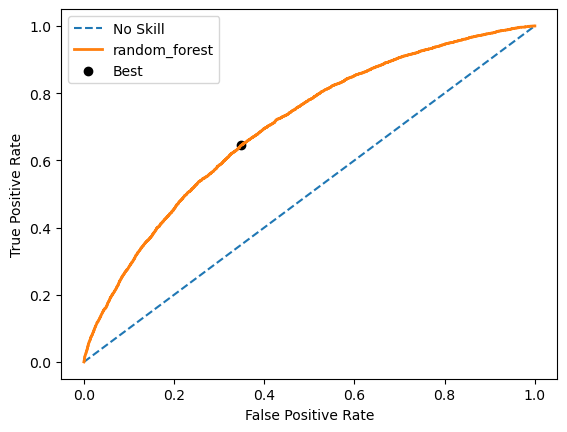

-------------------------
execution time: 142.62 seconds 



In [86]:
random_search_best_config_rfc = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
       'random_state': 42,
        'use_cv': False,
        'params': {
            'n_estimators': 100,
            'criterion': 'gini',
            'max_features': 'log2',
            'max_depth': 8,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'random_forest_random_search_best'):
    train('random_forest', config=random_search_best_config_rfc, dev_mode=False)

mlflow.end_run()

#### Results

GridSearchCV and RandomizedSearchCV gave very similar parameters, that gave similar scores.

<u>Optimal parameters:</u>
- n_estimators: 100
- criterion: 'gini'
- max_features: 'log2'
- max_depth: 8

<u>Threshold:</u> 0.49

<u>Metrics: </u>

- Cost ratio score: 0.6
- AUC: 0.7
- F beta_10: 0.61
- F1 score: 0.23
- Recall: 0.64
- Accuracy: 0.66

Overall, Random Forest Classifier performed slightly better that Logistic Regression

## LightGBM

LightGBM is a highly efficient gradient boosting framework that uses tree based learning algorithms. Gradient Boosting refers to a methodology in machine learning where an ensemble of weak learners is used to improve the model performance in terms of efficiency, accuracy, and interpretability

In [289]:
# Set the experiment
mlflow.set_experiment("LightGBM Classifier")

# Track models automatically
mlflow.sklearn.autolog()

### Baseline

LightGBM is able to handle missing values without imputation, by using special values to represent missing data in the tree.
We will disable `should_fill_na` for the baseline configuration.

One issue with LightGBM though is that we have to normalize the column names as the model does not accept certain characters, so we will set `should_normalize_columns` to True to transform all special characters to underscores.

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/08 09:37:58 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19941, number of negative: 226067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13192
[LightGBM] [Info] Number 

2024/01/08 09:38:14 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 09:38:16 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 09:38:17 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 09:38:19 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.77
Cost ratio score: 0.78
Recall: 0.02
Precision: 0.54
F1 score: 0.04
F beta_10: 0.02
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.54      0.02      0.04      4884

    accuracy                           0.92     61503
   macro avg       0.73      0.51      0.50     61503
weighted avg       0.89      0.92      0.89     61503

Best Threshold: 0.07


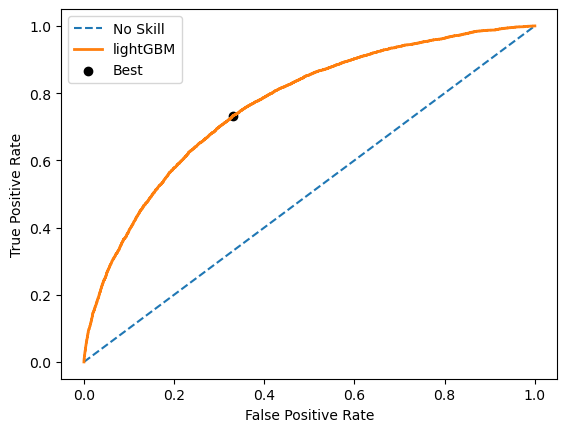

-------------------------
Running predictions with the best threshold
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 09:38:20 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.77
Cost ratio score: 0.52
Recall: 0.75
Precision: 0.16
F1 score: 0.26
F beta_10: 0.72
Accuracy: 0.66
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.65      0.78     56619
           1       0.16      0.75      0.26      4884

    accuracy                           0.66     61503
   macro avg       0.56      0.70      0.52     61503
weighted avg       0.90      0.66      0.74     61503

Best Threshold: 0.07


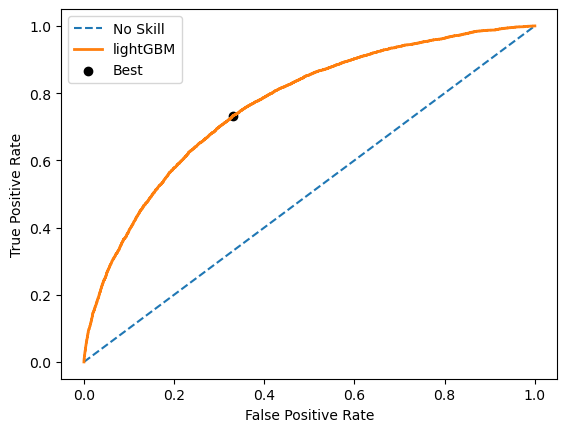

-------------------------


2024/01/08 09:38:22 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


execution time: 28.44 seconds 



In [91]:
baseline_config_lgbm = {
    'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': True,
        'should_normalize_distribution': False,
        'should_downcast': False,
        'should_select_features': False,
        'features_to_keep': [],
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'num_leaves': 31,
            'min_data_in_leaf': 20,
            'max_depth': -1,
            'learning_rate': 0.1,
            'colsample_bytree': 1.0,
            'subsample': 1.0,
            'lambda_l1': 0,
            'lambda_l2': 0,
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'LightGBM_baseline'):
    train('lightGBM', config=baseline_config_lgbm, dev_mode=False)

mlflow.end_run()

### Class balancing configuration

#### SMOTE

Although LightGBM can handle NaN values, SMOTE on the other hand, does not accept NaN values, therefore we have to enable `should_fill_na` option.

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/08 09:40:35 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/01/08 09:40:35 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/01/08 09:40:35 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 226067, number of negative: 226067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50249
[LightGBM] [Info] Number

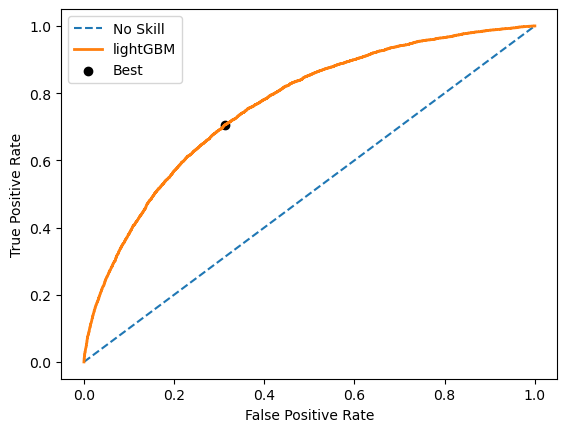

-------------------------
Running predictions with the best threshold
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
-------------------------
AUC: 0.76
Cost ratio score: 0.53
Recall: 0.72
Precision: 0.16
F1 score: 0.26
F beta_10: 0.7
Accuracy: 0.67
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.67      0.79     56619
           1       0.16      0.72      0.26      4884

    accuracy                           0.67     61503
   macro avg       0.56      0.69      0.52     61503
weighted avg       0.90      0.67      0.75     61503

Best Threshold: 0.08


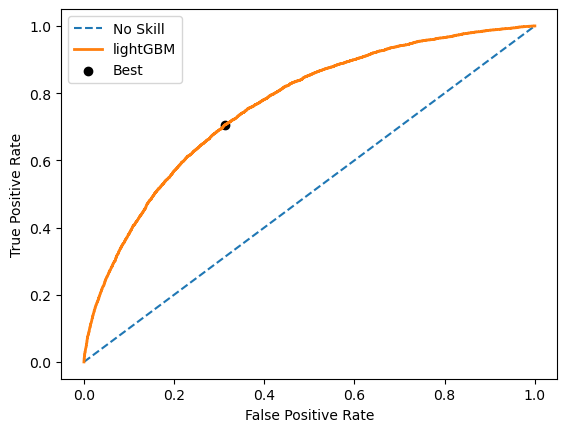

-------------------------


2024/01/08 09:40:47 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


execution time: 18.08 seconds 



In [93]:
smote_config_lgbm = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': True,
        'should_normalize_distribution': False,
        'should_downcast': False,
        'should_select_features': False,
        'features_to_keep': [],
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'num_leaves': 31,
            'min_data_in_leaf': 20,
            'max_depth': -1,
            'learning_rate': 0.1,
            'colsample_bytree': 1.0,
            'subsample': 1.0,
            'lambda_l1': 0,
            'lambda_l2': 0,
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'LightGBM_smote'):
    train('lightGBM', config=smote_config_lgbm, dev_mode=False)

mlflow.end_run()

#### SMOTE-NC

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/08 09:42:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: Yaml file '/Users/natche/Jupiter/Project 7/mlruns/777694632489959665/93978a1c0bd84fe99eb6c5554b1b72f9/inputs/8e68f56e23d415489bf3c0ec8d8c8688/meta.yaml' does not exist.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 226067, number of negative: 226067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22460
[LightGBM] [Info] Number

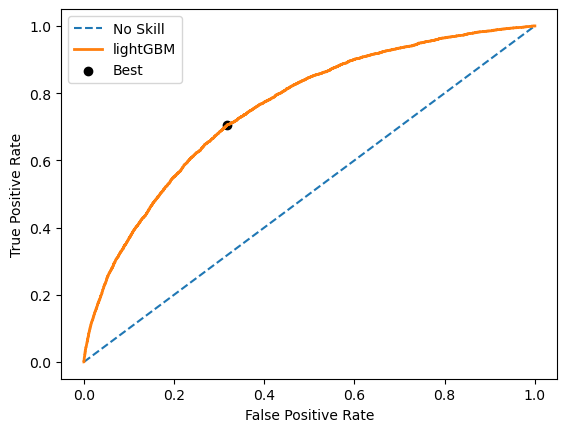

-------------------------
Running predictions with the best threshold
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
-------------------------
AUC: 0.76
Cost ratio score: 0.53
Recall: 0.68
Precision: 0.16
F1 score: 0.27
F beta_10: 0.66
Accuracy: 0.7
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56619
           1       0.16      0.68      0.27      4884

    accuracy                           0.70     61503
   macro avg       0.56      0.69      0.54     61503
weighted avg       0.90      0.70      0.77     61503

Best Threshold: 0.09


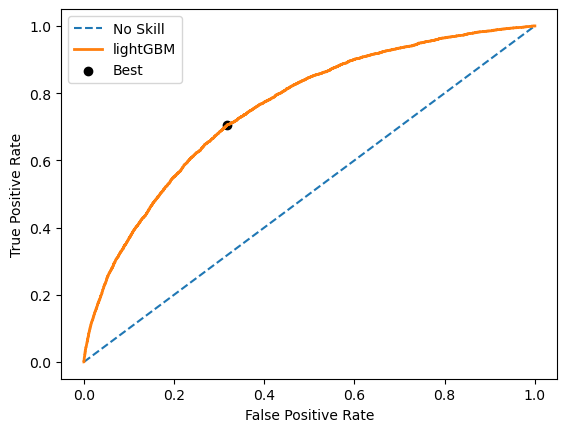

-------------------------


2024/01/08 09:45:14 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


execution time: 163.85 seconds 



In [94]:
smotenc_config_lgbm = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': True,
        'should_normalize_distribution': False,
        'should_downcast': False,
        'should_select_features': False,
        'features_to_keep': [],
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': True
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'num_leaves': 31,
            'min_data_in_leaf': 20,
            'max_depth': -1,
            'learning_rate': 0.1,
            'colsample_bytree': 1.0,
            'subsample': 1.0,
            'lambda_l1': 0,
            'lambda_l2': 0,
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'LightGBM_smotenc'):
    train('lightGBM', config=smotenc_config_lgbm, dev_mode=False)

mlflow.end_run()

#### Class weights

The advantage of using class weights parameter for LightGBM is that we can leave NaN values not filled.

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/08 09:46:41 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19941, number of negative: 226067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13192
[LightGBM] [Info] Number 

2024/01/08 09:46:57 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 09:46:59 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 09:47:00 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 09:47:01 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.77
Cost ratio score: 0.51
Recall: 0.69
Precision: 0.17
F1 score: 0.27
F beta_10: 0.67
Accuracy: 0.71
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     56619
           1       0.17      0.69      0.27      4884

    accuracy                           0.71     61503
   macro avg       0.57      0.70      0.55     61503
weighted avg       0.90      0.71      0.78     61503

Best Threshold: 0.47


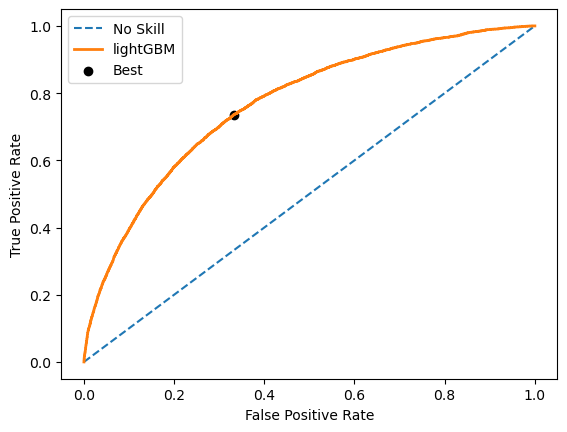

-------------------------
Running predictions with the best threshold
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 09:47:03 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.77
Cost ratio score: 0.52
Recall: 0.73
Precision: 0.16
F1 score: 0.26
F beta_10: 0.7
Accuracy: 0.68
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.67      0.79     56619
           1       0.16      0.73      0.26      4884

    accuracy                           0.68     61503
   macro avg       0.56      0.70      0.53     61503
weighted avg       0.90      0.68      0.75     61503

Best Threshold: 0.47


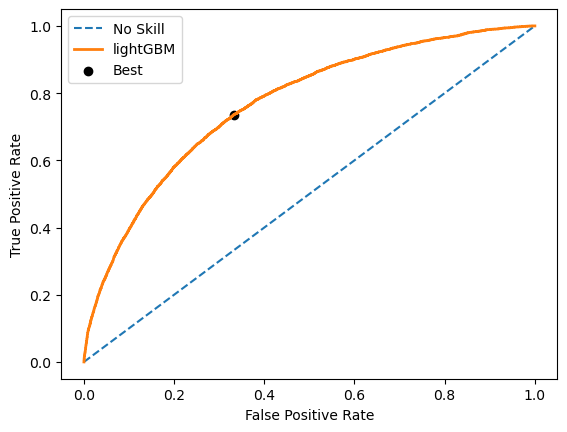

-------------------------


2024/01/08 09:47:04 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


execution time: 27.65 seconds 



In [95]:
class_weights_config_lgbm = {
    'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': True,
        'should_normalize_distribution': False,
        'should_downcast': False,
        'should_select_features': False,
        'features_to_keep': [],
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'num_leaves': 31,
            'min_data_in_leaf': 20,
            'max_depth': -1,
            'learning_rate': 0.1,
            'colsample_bytree': 1.0,
            'subsample': 1.0,
            'lambda_l1': 0,
            'lambda_l2': 0,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'LightGBM_class_weights'):
    train('lightGBM', config=class_weights_config_lgbm, dev_mode=False)

mlflow.end_run()

Using 'class_weights' parameter showed better results that SMOTE and SMOTE-NC. Moreover, it will enable the possibility to leave NaN values to be handled by the model itself, which is not the case for SMOTE and SMOTE-NC. 

### Feature engineering
#### Credit history

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/08 09:53:03 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/08 09:53:04 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19941, number of negative: 226067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 65163
[LightGBM] [Info] Number 

2024/01/08 09:53:41 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 09:53:43 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 09:53:45 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 09:53:47 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.78
Cost ratio score: 0.49
Recall: 0.69
Precision: 0.18
F1 score: 0.29
F beta_10: 0.67
Accuracy: 0.73
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     56619
           1       0.18      0.69      0.29      4884

    accuracy                           0.73     61503
   macro avg       0.57      0.71      0.56     61503
weighted avg       0.90      0.73      0.79     61503

Best Threshold: 0.49


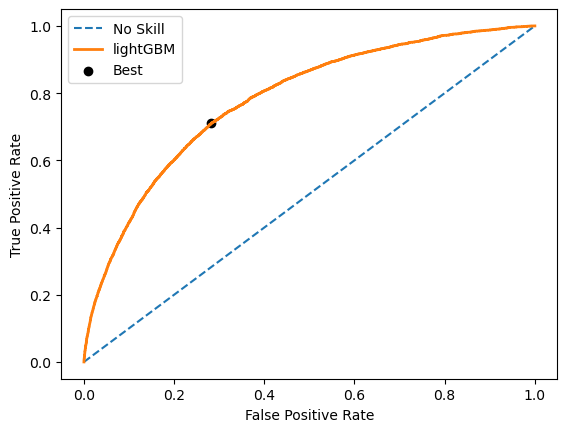

-------------------------
Running predictions with the best threshold
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 09:53:49 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.78
Cost ratio score: 0.49
Recall: 0.71
Precision: 0.18
F1 score: 0.28
F beta_10: 0.69
Accuracy: 0.72
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.72      0.82     56619
           1       0.18      0.71      0.28      4884

    accuracy                           0.72     61503
   macro avg       0.57      0.71      0.55     61503
weighted avg       0.90      0.72      0.78     61503

Best Threshold: 0.49


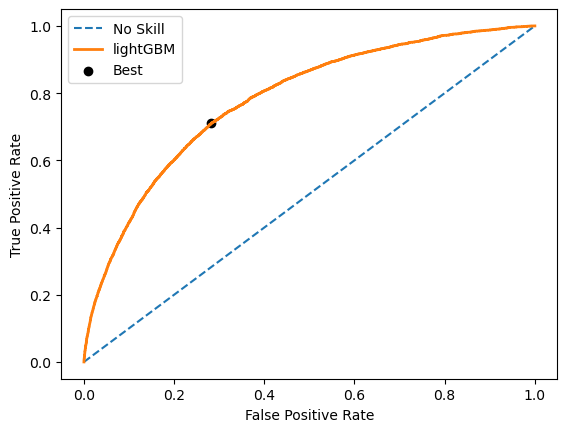

-------------------------


2024/01/08 09:53:50 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


execution time: 69.1 seconds 



In [96]:
credit_history_config_lgbm = {
    'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': True,
        'should_normalize_distribution': False,
        'should_downcast': False,
        'should_select_features': False,
        'features_to_keep': [],
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'num_leaves': 31,
            'min_data_in_leaf': 20,
            'max_depth': -1,
            'learning_rate': 0.1,
            'colsample_bytree': 1.0,
            'subsample': 1.0,
            'lambda_l1': 0,
            'lambda_l2': 0,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'LightGBM_credit_history'):
    train('lightGBM', config=credit_history_config_lgbm, dev_mode=False)

mlflow.end_run()

#### Full history

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/08 09:55:06 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/08 09:55:08 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19941, number of negative: 226067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.161809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 95885
[LightGBM] [Info] Number 

2024/01/08 09:56:02 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 09:56:05 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 09:56:08 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 09:56:09 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.79
Cost ratio score: 0.49
Recall: 0.69
Precision: 0.18
F1 score: 0.29
F beta_10: 0.68
Accuracy: 0.73
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.74      0.83     56619
           1       0.18      0.69      0.29      4884

    accuracy                           0.73     61503
   macro avg       0.57      0.71      0.56     61503
weighted avg       0.90      0.73      0.79     61503

Best Threshold: 0.48


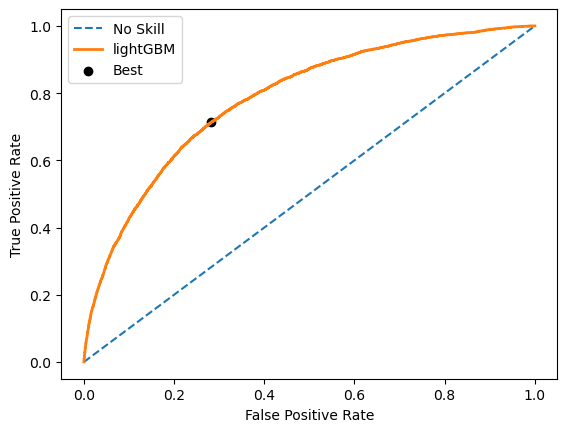

-------------------------
Running predictions with the best threshold
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 09:56:11 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.79
Cost ratio score: 0.49
Recall: 0.72
Precision: 0.18
F1 score: 0.28
F beta_10: 0.7
Accuracy: 0.71
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.71      0.82     56619
           1       0.18      0.72      0.28      4884

    accuracy                           0.71     61503
   macro avg       0.57      0.71      0.55     61503
weighted avg       0.90      0.71      0.78     61503

Best Threshold: 0.48


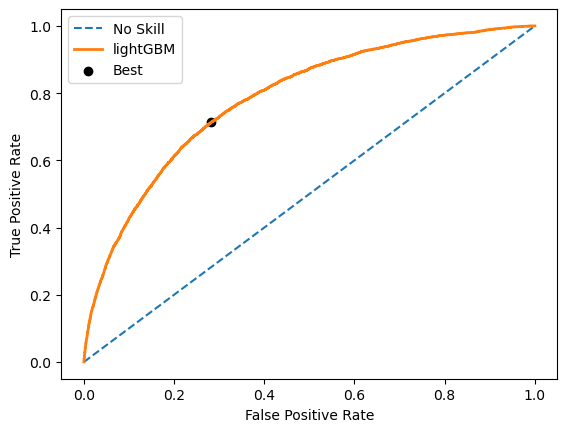

-------------------------


2024/01/08 09:56:13 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


execution time: 117.2 seconds 



In [97]:
full_history_config_lgbm = {
    'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': True,
        'should_normalize_distribution': False,
        'should_downcast': False,
        'should_select_features': False,
        'features_to_keep': [],
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'num_leaves': 31,
            'min_data_in_leaf': 20,
            'max_depth': -1,
            'learning_rate': 0.1,
            'colsample_bytree': 1.0,
            'subsample': 1.0,
            'lambda_l1': 0,
            'lambda_l2': 0,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'LightGBM_full_history'):
    train('lightGBM', config=full_history_config_lgbm, dev_mode=False)

mlflow.end_run()

#### Selected features

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/08 09:57:23 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/08 09:57:24 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19941, number of negative: 226067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4239
[LightGBM] [Info] Number o

2024/01/08 09:58:03 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 09:58:05 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 09:58:08 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 09:58:09 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.73
Cost ratio score: 0.56
Recall: 0.65
Precision: 0.15
F1 score: 0.25
F beta_10: 0.63
Accuracy: 0.68
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56619
           1       0.15      0.65      0.25      4884

    accuracy                           0.68     61503
   macro avg       0.56      0.67      0.52     61503
weighted avg       0.89      0.68      0.76     61503

Best Threshold: 0.48


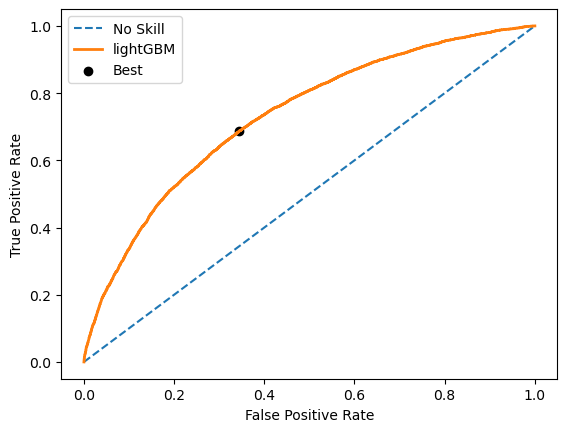

-------------------------
Running predictions with the best threshold
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 09:58:11 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.73
Cost ratio score: 0.57
Recall: 0.69
Precision: 0.15
F1 score: 0.24
F beta_10: 0.66
Accuracy: 0.66
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.65      0.78     56619
           1       0.15      0.69      0.24      4884

    accuracy                           0.66     61503
   macro avg       0.55      0.67      0.51     61503
weighted avg       0.90      0.66      0.74     61503

Best Threshold: 0.48


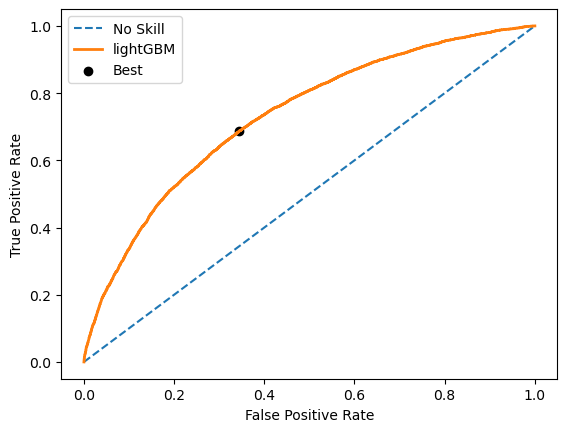

-------------------------


2024/01/08 09:58:13 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


execution time: 98.95 seconds 



In [98]:
best_features_config_lgbm = {
    'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': True,
        'should_normalize_distribution': False,
        'should_downcast': False,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'num_leaves': 31,
            'min_data_in_leaf': 20,
            'max_depth': -1,
            'learning_rate': 0.1,
            'colsample_bytree': 1.0,
            'subsample': 1.0,
            'lambda_l1': 0,
            'lambda_l2': 0,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'LightGBM_best_features'):
    train('lightGBM', config=best_features_config_lgbm, dev_mode=False)

mlflow.end_run()

### Preprocessing

As we stated earlier, LightGBM can handle missing values and it is also robust to outliers. Generally speaking, the algorithm is known to not be very demanding as to the data preprocessing, usually feeding raw data is enough. 

We will still try out the same preprocessing techniques as for other models for the experimental purpose.


#### Filling missing values

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/08 09:59:25 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/08 09:59:27 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19941, number of negative: 226067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3419
[LightGBM] [Info] Number o

2024/01/08 10:00:18 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:00:21 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:00:23 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:00:25 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.72
Cost ratio score: 0.57
Recall: 0.66
Precision: 0.15
F1 score: 0.24
F beta_10: 0.64
Accuracy: 0.67
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.79     56619
           1       0.15      0.66      0.24      4884

    accuracy                           0.67     61503
   macro avg       0.55      0.67      0.52     61503
weighted avg       0.89      0.67      0.75     61503

Best Threshold: 0.5


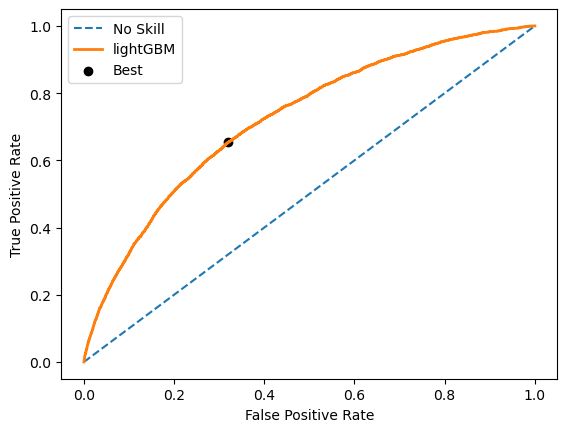

-------------------------
Running predictions with the best threshold
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:00:27 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.72
Cost ratio score: 0.57
Recall: 0.66
Precision: 0.15
F1 score: 0.24
F beta_10: 0.64
Accuracy: 0.67
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.79     56619
           1       0.15      0.66      0.24      4884

    accuracy                           0.67     61503
   macro avg       0.55      0.67      0.52     61503
weighted avg       0.89      0.67      0.75     61503

Best Threshold: 0.5


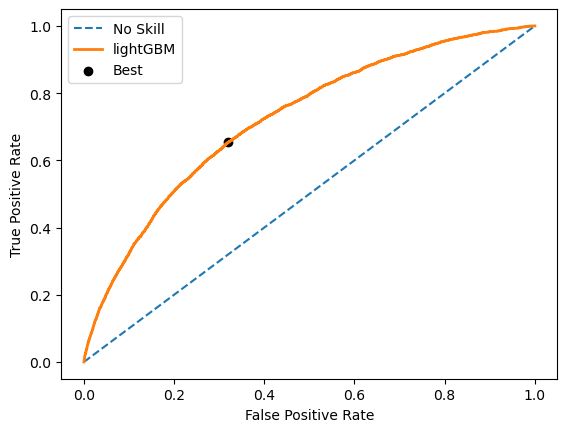

-------------------------


2024/01/08 10:00:28 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


execution time: 112.39 seconds 



In [99]:
fill_nan_config_lgbm = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': True,
        'should_normalize_distribution': False,
        'should_downcast': False,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'num_leaves': 31,
            'min_data_in_leaf': 20,
            'max_depth': -1,
            'learning_rate': 0.1,
            'colsample_bytree': 1.0,
            'subsample': 1.0,
            'lambda_l1': 0,
            'lambda_l2': 0,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'LightGBM_fill_nan'):
    train('lightGBM', config=fill_nan_config_lgbm, dev_mode=False)

mlflow.end_run()

Filling missing values did not impact Cost Ratio Score, but decreased AUC and Fbeta 10 score, therefore, we will leave NaN values to the model.

#### Removing outliers

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/08 10:03:26 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/08 10:03:28 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19941, number of negative: 226067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3643
[LightGBM] [Info] Number o

2024/01/08 10:04:22 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:04:24 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:04:27 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:04:29 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.73
Cost ratio score: 0.57
Recall: 0.66
Precision: 0.15
F1 score: 0.24
F beta_10: 0.64
Accuracy: 0.68
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     56619
           1       0.15      0.66      0.24      4884

    accuracy                           0.68     61503
   macro avg       0.55      0.67      0.52     61503
weighted avg       0.89      0.68      0.75     61503

Best Threshold: 0.49


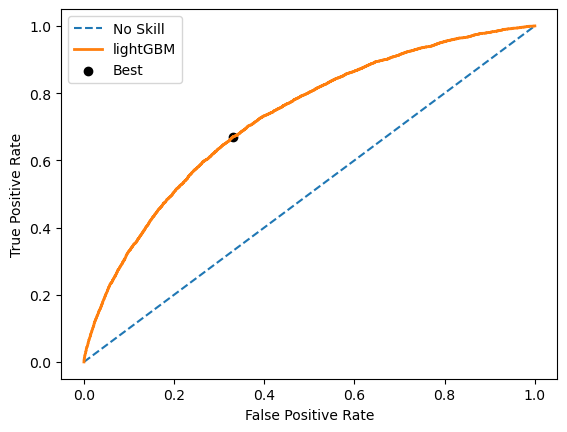

-------------------------
Running predictions with the best threshold
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:04:31 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.73
Cost ratio score: 0.57
Recall: 0.67
Precision: 0.15
F1 score: 0.24
F beta_10: 0.65
Accuracy: 0.66
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.66      0.78     56619
           1       0.15      0.67      0.24      4884

    accuracy                           0.66     61503
   macro avg       0.55      0.67      0.51     61503
weighted avg       0.89      0.66      0.74     61503

Best Threshold: 0.49


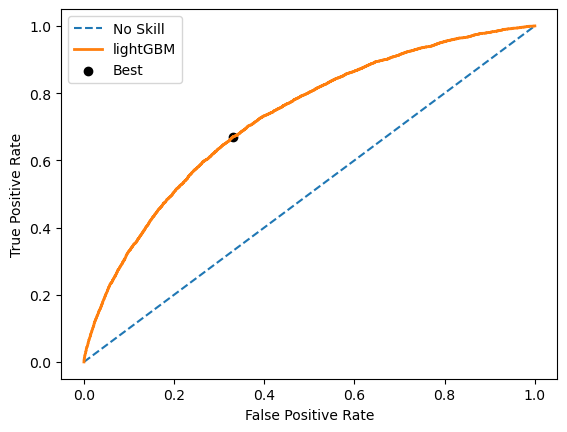

-------------------------


2024/01/08 10:04:33 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


execution time: 115.47 seconds 



In [100]:
remove_outliers1_config_lgbm = {
    'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 1.5,
        'should_normalize_columns': True,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'num_leaves': 31,
            'min_data_in_leaf': 20,
            'max_depth': -1,
            'learning_rate': 0.1,
            'colsample_bytree': 1.0,
            'subsample': 1.0,
            'lambda_l1': 0,
            'lambda_l2': 0,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'LightGBM_outliers1'):
    train('lightGBM', config=remove_outliers1_config_lgbm, dev_mode=False)

mlflow.end_run()

Setting IQR factor to 2.5

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/08 10:06:51 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/08 10:06:53 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19941, number of negative: 226067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number o

2024/01/08 10:07:46 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:07:49 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:07:52 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:07:53 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.73
Cost ratio score: 0.57
Recall: 0.65
Precision: 0.15
F1 score: 0.24
F beta_10: 0.63
Accuracy: 0.68
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     56619
           1       0.15      0.65      0.24      4884

    accuracy                           0.68     61503
   macro avg       0.55      0.67      0.52     61503
weighted avg       0.89      0.68      0.75     61503

Best Threshold: 0.51


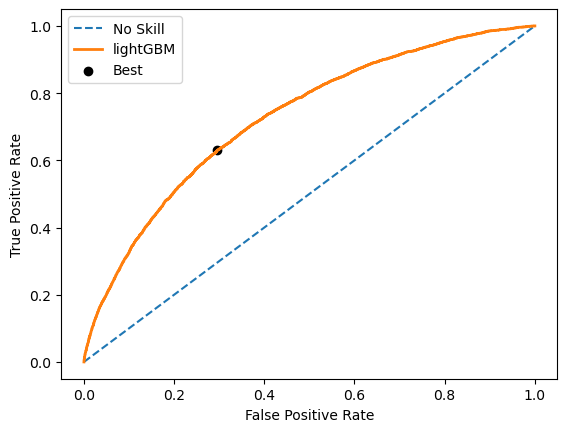

-------------------------
Running predictions with the best threshold
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:07:55 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.73
Cost ratio score: 0.57
Recall: 0.64
Precision: 0.15
F1 score: 0.25
F beta_10: 0.62
Accuracy: 0.69
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56619
           1       0.15      0.64      0.25      4884

    accuracy                           0.69     61503
   macro avg       0.56      0.67      0.53     61503
weighted avg       0.89      0.69      0.76     61503

Best Threshold: 0.51


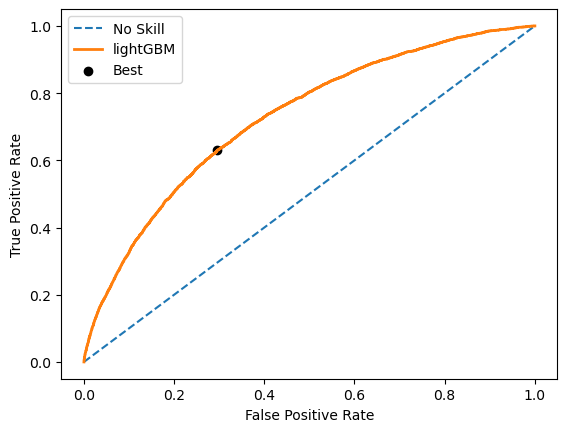

-------------------------


2024/01/08 10:07:57 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


execution time: 114.77 seconds 



In [102]:
remove_outliers2_config_lgbm = {
    'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 2.5,
        'should_normalize_columns': True,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'num_leaves': 31,
            'min_data_in_leaf': 20,
            'max_depth': -1,
            'learning_rate': 0.1,
            'colsample_bytree': 1.0,
            'subsample': 1.0,
            'lambda_l1': 0,
            'lambda_l2': 0,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'LightGBM_outliers2'):
    train('lightGBM', config=remove_outliers2_config_lgbm, dev_mode=False)

mlflow.end_run()

Removing outliers had no impact on Cost Ratio Score and AUC but decreased Fbeta 10 and Recall, therefore we will poursue the training with the outliers left.

#### Scaling

**StandardScaler**

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/08 10:10:37 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/08 10:10:39 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19941, number of negative: 226067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4221
[LightGBM] [Info] Number o

2024/01/08 10:11:32 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:11:35 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:11:37 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:11:39 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.73
Cost ratio score: 0.56
Recall: 0.66
Precision: 0.15
F1 score: 0.25
F beta_10: 0.64
Accuracy: 0.68
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56619
           1       0.15      0.66      0.25      4884

    accuracy                           0.68     61503
   macro avg       0.56      0.67      0.52     61503
weighted avg       0.89      0.68      0.76     61503

Best Threshold: 0.51


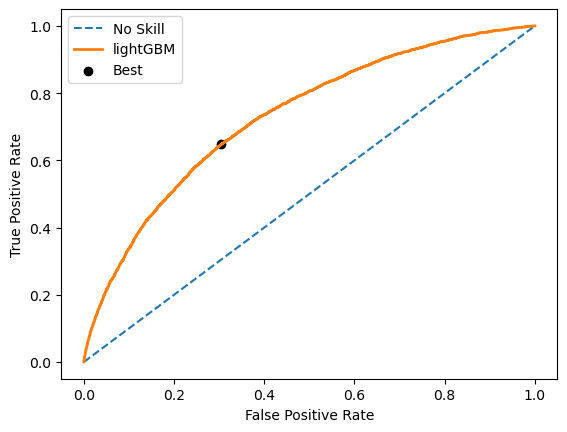

-------------------------
Running predictions with the best threshold
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:11:41 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.73
Cost ratio score: 0.56
Recall: 0.64
Precision: 0.16
F1 score: 0.25
F beta_10: 0.62
Accuracy: 0.7
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56619
           1       0.16      0.64      0.25      4884

    accuracy                           0.70     61503
   macro avg       0.56      0.67      0.53     61503
weighted avg       0.89      0.70      0.77     61503

Best Threshold: 0.51


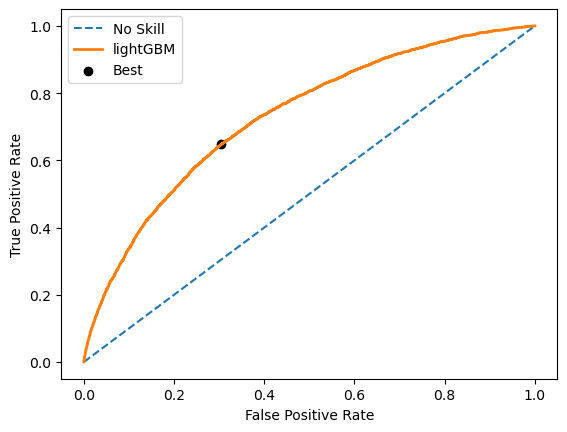

-------------------------


2024/01/08 10:11:43 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


execution time: 114.56 seconds 



In [104]:
standard_scaler_config_lgbm = {
    'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': True,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'num_leaves': 31,
            'min_data_in_leaf': 20,
            'max_depth': -1,
            'learning_rate': 0.1,
            'colsample_bytree': 1.0,
            'subsample': 1.0,
            'lambda_l1': 0,
            'lambda_l2': 0,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'LightGBM_standard_scaler'):
    train('lightGBM', config=standard_scaler_config_lgbm, dev_mode=False)

mlflow.end_run()

**MinMaxScaler**

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/08 10:12:54 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/08 10:12:56 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19941, number of negative: 226067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4237
[LightGBM] [Info] Number o

2024/01/08 10:13:47 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:13:50 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:13:53 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:13:55 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.73
Cost ratio score: 0.56
Recall: 0.65
Precision: 0.15
F1 score: 0.25
F beta_10: 0.63
Accuracy: 0.68
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56619
           1       0.15      0.65      0.25      4884

    accuracy                           0.68     61503
   macro avg       0.56      0.67      0.52     61503
weighted avg       0.89      0.68      0.76     61503

Best Threshold: 0.49


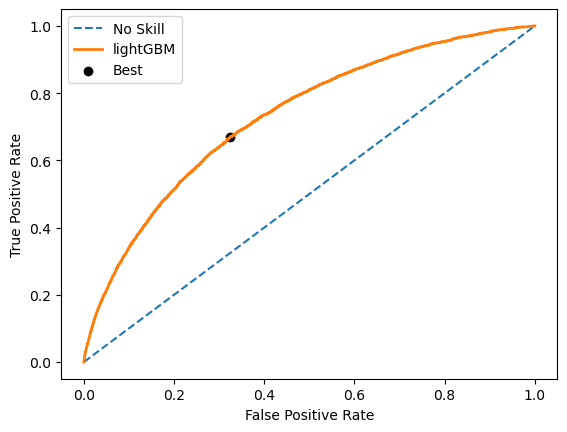

-------------------------
Running predictions with the best threshold
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:13:57 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.73
Cost ratio score: 0.56
Recall: 0.67
Precision: 0.15
F1 score: 0.25
F beta_10: 0.65
Accuracy: 0.67
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     56619
           1       0.15      0.67      0.25      4884

    accuracy                           0.67     61503
   macro avg       0.55      0.67      0.52     61503
weighted avg       0.90      0.67      0.75     61503

Best Threshold: 0.49


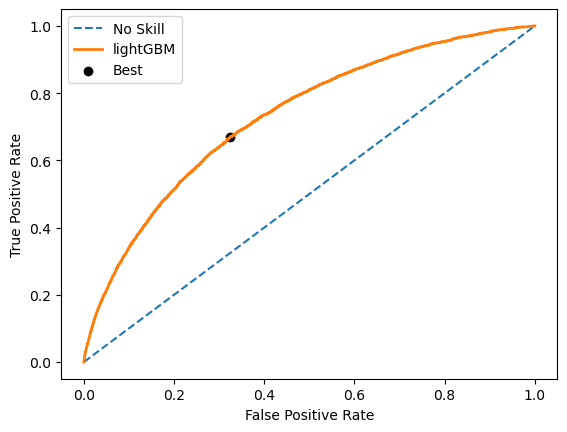

-------------------------


2024/01/08 10:13:58 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


execution time: 113.68 seconds 



In [105]:
minmax_scaler_config_lgbm = {
    'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': MinMaxScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': True,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'num_leaves': 31,
            'min_data_in_leaf': 20,
            'max_depth': -1,
            'learning_rate': 0.1,
            'colsample_bytree': 1.0,
            'subsample': 1.0,
            'lambda_l1': 0,
            'lambda_l2': 0,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'LightGBM_minmax_scaler'):
    train('lightGBM', config=minmax_scaler_config_lgbm, dev_mode=False)

mlflow.end_run()

**RobustScaler**

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/08 10:18:15 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/08 10:18:17 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19941, number of negative: 226067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4243
[LightGBM] [Info] Number o

2024/01/08 10:19:11 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:19:14 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:19:16 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:19:18 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.73
Cost ratio score: 0.56
Recall: 0.66
Precision: 0.15
F1 score: 0.25
F beta_10: 0.64
Accuracy: 0.68
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56619
           1       0.15      0.66      0.25      4884

    accuracy                           0.68     61503
   macro avg       0.56      0.67      0.52     61503
weighted avg       0.89      0.68      0.76     61503

Best Threshold: 0.51


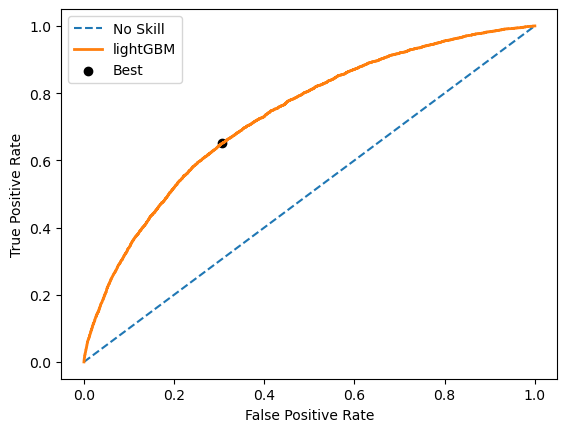

-------------------------
Running predictions with the best threshold
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:19:20 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.73
Cost ratio score: 0.56
Recall: 0.64
Precision: 0.16
F1 score: 0.25
F beta_10: 0.62
Accuracy: 0.7
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56619
           1       0.16      0.64      0.25      4884

    accuracy                           0.70     61503
   macro avg       0.56      0.67      0.53     61503
weighted avg       0.89      0.70      0.77     61503

Best Threshold: 0.51


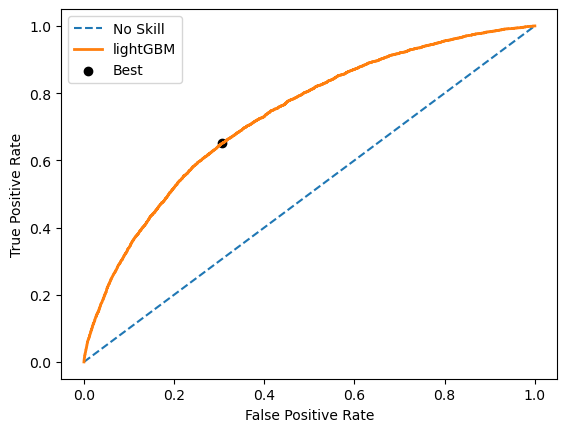

-------------------------


2024/01/08 10:19:21 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


execution time: 116.6 seconds 



In [107]:
robust_scaler_config_lgbm = {
    'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': RobustScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': True,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'num_leaves': 31,
            'min_data_in_leaf': 20,
            'max_depth': -1,
            'learning_rate': 0.1,
            'colsample_bytree': 1.0,
            'subsample': 1.0,
            'lambda_l1': 0,
            'lambda_l2': 0,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'LightGBM_robust_scaler'):
    train('lightGBM', config=robust_scaler_config_lgbm, dev_mode=False)

mlflow.end_run()

Surprisingly, MinMaxScaler improved the Cost Ratio Score.

#### Normalize distribution

With the activated scaler, because `standardize` is set to False in the transformer. Also, we have to fill null values otherwise, the PowerTransformer throws an error.

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/08 10:32:20 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/08 10:32:22 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19941, number of negative: 226067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3397
[LightGBM] [Info] Number o

2024/01/08 10:34:13 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:34:16 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:34:18 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:34:20 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.72
Cost ratio score: 0.57
Recall: 0.65
Precision: 0.15
F1 score: 0.24
F beta_10: 0.63
Accuracy: 0.68
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.79     56619
           1       0.15      0.65      0.24      4884

    accuracy                           0.68     61503
   macro avg       0.55      0.67      0.52     61503
weighted avg       0.89      0.68      0.75     61503

Best Threshold: 0.49


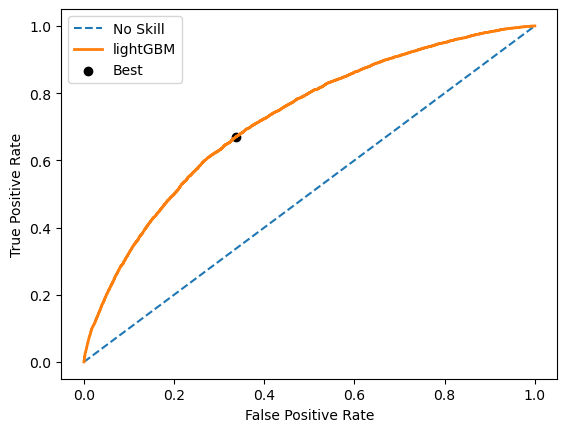

-------------------------
Running predictions with the best threshold
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:34:23 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.72
Cost ratio score: 0.57
Recall: 0.67
Precision: 0.15
F1 score: 0.24
F beta_10: 0.65
Accuracy: 0.66
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.66      0.78     56619
           1       0.15      0.67      0.24      4884

    accuracy                           0.66     61503
   macro avg       0.55      0.67      0.51     61503
weighted avg       0.89      0.66      0.74     61503

Best Threshold: 0.49


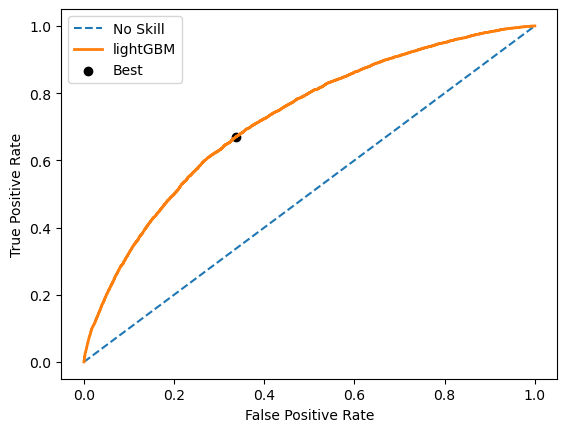

-------------------------


2024/01/08 10:34:25 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


execution time: 174.0 seconds 



In [111]:
norm_dist_config_lgbm = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': MinMaxScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': True,
        'should_normalize_distribution': True,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'num_leaves': 31,
            'min_data_in_leaf': 20,
            'max_depth': -1,
            'learning_rate': 0.1,
            'colsample_bytree': 1.0,
            'subsample': 1.0,
            'lambda_l1': 0,
            'lambda_l2': 0,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'LightGBM_norm_dist'):
    train('lightGBM', config=norm_dist_config_lgbm, dev_mode=False)

mlflow.end_run()

Normalizing distribution degraded the Cost Ratio Score.

#### Full preprocessing
Let's try activating multiple preprocessing options at the same time

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/08 10:35:56 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/08 10:35:58 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19941, number of negative: 226067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3144
[LightGBM] [Info] Number o

2024/01/08 10:37:12 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:37:14 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:37:17 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:37:19 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.72
Cost ratio score: 0.58
Recall: 0.65
Precision: 0.15
F1 score: 0.24
F beta_10: 0.63
Accuracy: 0.67
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     56619
           1       0.15      0.65      0.24      4884

    accuracy                           0.67     61503
   macro avg       0.55      0.66      0.51     61503
weighted avg       0.89      0.67      0.75     61503

Best Threshold: 0.51


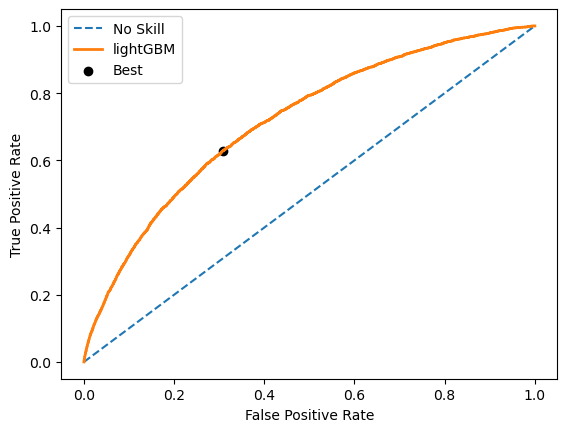

-------------------------
Running predictions with the best threshold
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


2024/01/08 10:37:21 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.72
Cost ratio score: 0.58
Recall: 0.63
Precision: 0.15
F1 score: 0.24
F beta_10: 0.61
Accuracy: 0.68
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56619
           1       0.15      0.63      0.24      4884

    accuracy                           0.68     61503
   macro avg       0.55      0.66      0.52     61503
weighted avg       0.89      0.68      0.76     61503

Best Threshold: 0.51


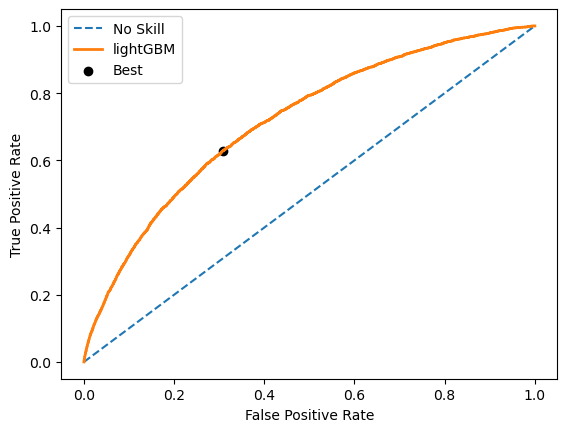

-------------------------


2024/01/08 10:37:23 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


execution time: 135.7 seconds 



In [112]:
full_preprocess_config_lgbm = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': MinMaxScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 2.5,
        'should_normalize_columns': True,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'num_leaves': 31,
            'min_data_in_leaf': 20,
            'max_depth': -1,
            'learning_rate': 0.1,
            'colsample_bytree': 1.0,
            'subsample': 1.0,
            'lambda_l1': 0,
            'lambda_l2': 0,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'LightGBM_full_preprocess'):
    train('lightGBM', config=full_preprocess_config_lgbm, dev_mode=False)

mlflow.end_run()

Applying multiple preprocessing techniques gave the worst results. We could poursue with different other combinations of preprocessing settings, but for now, we will keep the following options that gave the best scores:

- 'should_fill_na': False
- 'should_scale': True
- 'scaler': MinMaxScaler()
- 'should_remove_outliers': False
- 'should_normalize_distribution': False

In [118]:
lgbm_preprocess_config = {
    'should_fill_na': False,
    'num_imputer': SimpleImputer(strategy='median'),
    'cat_imputer': SimpleImputer(strategy='most_frequent'),
    'should_scale': True,
    'scaler': MinMaxScaler(),
    'should_remove_outliers': False,
    'iqr_factor': 1.5,
    'should_normalize_columns': True,
    'should_normalize_distribution': False,
    'should_downcast': True,
    'should_select_features': True,
    'features_to_keep': best_features,
    'use_bureau_and_balance': True,
    'use_previous_applications': True,
    'use_pos_cash_balance': True,
    'use_installments_payments': True,
    'use_credit_card_balance': True,
}

### Fine-tuning

LightGBM has a very rich set of hyperparameters, optimizing them all via GridSearch or RandomizedSearch will be very time consuming, therefore, we will opt for a Bayesian Hyperparameter Optimization technique with the Hyperopt library.

**Bayesian Hyperparameter Optimization**

Bayesian optimization is a probabilistic model based approach for finding the minimum of any function that returns a real-value metric, it  is intuitive: choose the next input values to evaluate based on the past results to concentrate the search on more promising values. The end outcome is a reduction in the total number of search iterations compared to uninformed random or grid search methods.

For Bayesian optimization, we need the following four parts:

1. <u>Objective function:</u> will take in the hyperparameters and return a value to minimize (Hyperopt works to minimize a function)
2. <u>Domain space:</u> probability distributions for each hyperparameter, where each variable has a have and a few parameters specifying the type and extent of the distribution.
3. <u>Hyperparameter optimization algorithm:</u>  We will use the Tree Parzen Estimator which is one method for constructing the surrogate function and choosing the next hyperparameters to evaluate.
4. <u>History of results:</u> we will use a Trials object that stores the dictionary returned from the objective function.


We will optimize the following parameters:

1. **n_estimators:** number of boosting iterations
2. **num_leaves:** max number of leaves in one tree
3. **colsample_bytree:** alias of feature_fraction, LightGBM will randomly select a subset of features on each iteration (tree) if this param is smaller than 1.0. For example, if set to 0.8, LightGBM will select 80% of features before training each tree.
- can be used to speed up training
- can be used to deal with over-fitting
4. **min_data_in_leaf:** minimal number of data in one leaf. Can be used to deal with over-fitting
5. **max_depth:** limit the max depth for tree model. This is used to deal with over-fitting when data is small. Tree still grows leaf-wise
6. **learning_rate:** shrinkage rate
7. **subsample_for_bin:** number of data that sampled to construct feature discrete bins. Setting this to larger value will give better training result, but may increase data loading time. Set this to larger value if data is very sparse
8. **lambda_l1:** L1 regularization
9. **lambda_l2:** L2 regularization

In [287]:
data = process.load_application(dev_mode=False)

X = data.drop(process.TARGET_COLUMN, axis=1)
y = data[process.TARGET_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      shuffle=False)

In [139]:
space = {
    'classifier__n_estimators':  hp.choice('n_estimators', range(100, 500)),
    'classifier__num_leaves': hp.quniform('num_leaves', 10, 150, 1),
    'classifier__min_data_in_leaf':  hp.quniform('min_data_in_leaf', 20, 500, 5),
    'classifier__max_depth':  hp.choice('max_depth', range(1, 30, 5)),
    'classifier__learning_rate':  hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'classifier__colsample_bytree':  hp.uniform('colsample_bytree', 0.1, 1.0),
    'classifier__subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'classifier__lambda_l1':  hp.uniform('lambda_l1', 0.0, 1),
    'classifier__lambda_l2':  hp.uniform('lambda_l2', 0.0, 1),
    'classifier__class_weight':  ['balanced']
}

hyperopt_config = {
   'preprocessing': lgbm_preprocess_config,
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'cv_splits': 5,
        'param_grid': space,
        'params': {}
    }
}

def objective(params):
    pipeline = PIPELINES['lightGBM'](config=hyperopt_config, dev_mode=False)
    cv = StratifiedKFold(n_splits=5, shuffle=False)
    
    scores = cross_val_score(
        estimator=pipeline,
        X=X_train,
        y=y_train,
        cv=cv, 
        scoring=cost_ratio_scorer,
        n_jobs=-1
    )
    
    return min(scores)
   
    
tpe_algorithm = tpe.suggest

# Trials object to track progress
bayes_trials = Trials()

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 10, trials = bayes_trials)
print(best)

  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(
/Users/natche/opt/anacon

 10%|▉        | 1/10 [01:25<12:52, 85.85s/trial, best loss: -0.8075078248851673]

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


 20%|█▊       | 2/10 [02:55<11:44, 88.10s/trial, best loss: -0.8075078248851673]

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15952, number of negative: 180854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4239
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081054 -> initscore=-2.428106
[LightGBM] [Info] Start training from score -2.428106
[LightGBM] [Info] Number of positive: 15953, number of negative: 180854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4238
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 25
[LightGBM] [In

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


 50%|████▌    | 5/10 [07:18<07:16, 87.37s/trial, best loss: -0.8075078248851673][LightGBM] [Info] Number of positive: 15953, number of negative: 180853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081060 -> initscore=-2.428038
[LightGBM] [Info] Start training from score -2.428038
[LightGBM] [Info] Number of positive: 15953, number of negative: 180853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4238
[LightGBM] [Info] Number of 

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


 70%|██████▎  | 7/10 [10:12<04:21, 87.09s/trial, best loss: -0.8075078248851673][LightGBM] [Info] Number of positive: 15953, number of negative: 180854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4237
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081059 -> initscore=-2.428043
[LightGBM] [Info] Start training from score -2.428043
[LightGBM] [Info] Number of positive: 15953, number of negative: 180853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4238
[LightGBM] [Info] Number of 

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


100%|████████| 10/10 [14:38<00:00, 87.90s/trial, best loss: -0.8075078248851673]
{'lambda_l1': 0.7899116304431179, 'lambda_l2': 0.06954273422128565, 'learning_rate': 0.04889948110423217, 'max_depth': 5, 'min_data_in_leaf': 220.0, 'n_estimators': 391, 'num_leaves': 11.0, 'subsample_for_bin': 160000.0}
[LightGBM] [Info] Number of positive: 15953, number of negative: 180853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4238
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081060 -> initscore=-2.428038
[LightGBM] [Info] Start training from score -2.428038
[LightGBM] [Info] Number of positive: 15952, number of negative: 180854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the over

In [141]:
best

{'lambda_l1': 0.7899116304431179,
 'lambda_l2': 0.06954273422128565,
 'learning_rate': 0.04889948110423217,
 'max_depth': 5,
 'min_data_in_leaf': 220.0,
 'n_estimators': 391,
 'num_leaves': 11.0,
 'subsample_for_bin': 160000.0}

**Hyperopt best params**

In [293]:
hyperopt_best_params = {
    'colsample_bytree': 0.5889781971601602,
    'lambda_l1': 0.706184239474385,
    'lambda_l2': 0.19463527299726424,
    'learning_rate': 0.08852590743511789,
    'max_depth': 4,
    'min_data_in_leaf': 135.0,
    'n_estimators': 158,
    'num_leaves': 111.0,
    'subsample_for_bin': 20000.0
}

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/13 11:29:00 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/13 11:29:02 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

[LightGBM] [Warning] lambda_l1 is set=0.706184239474385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.706184239474385
[LightGBM] [Warning] lambda_l2 is set=0.19463527299726424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19463527299726424
[LightGBM] [Warning] min_data_in_leaf is set=135, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=135
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] lambda_l1 is set=0.706184239474385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.706184239474385
[LightGBM] [Warning] lambda_l2 is set=0.19463527299726424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19463527299726424
[LightGBM] [Warning] min_data_in_leaf is set=135, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=135
[LightGBM] [Info] Number of positive: 19941, number of negative: 226067
[LightGBM] [Info] Auto-choosi

2024/01/13 11:29:53 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0.706184239474385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.706184239474385
[LightGBM] [Warning] lambda_l2 is set=0.19463527299726424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19463527299726424
[LightGBM] [Warning] min_data_in_leaf is set=135, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=135


2024/01/13 11:29:56 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


[LightGBM] [Warning] lambda_l1 is set=0.706184239474385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.706184239474385
[LightGBM] [Warning] lambda_l2 is set=0.19463527299726424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19463527299726424
[LightGBM] [Warning] min_data_in_leaf is set=135, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=135


2024/01/13 11:29:59 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0.706184239474385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.706184239474385
[LightGBM] [Warning] lambda_l2 is set=0.19463527299726424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19463527299726424
[LightGBM] [Warning] min_data_in_leaf is set=135, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=135


2024/01/13 11:30:00 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.73
Cost ratio score: 0.56
Recall: 0.66
Precision: 0.15
F1 score: 0.25
F beta_10: 0.64
Accuracy: 0.68
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     56619
           1       0.15      0.66      0.25      4884

    accuracy                           0.68     61503
   macro avg       0.56      0.67      0.52     61503
weighted avg       0.89      0.68      0.75     61503

Best Threshold: 0.5


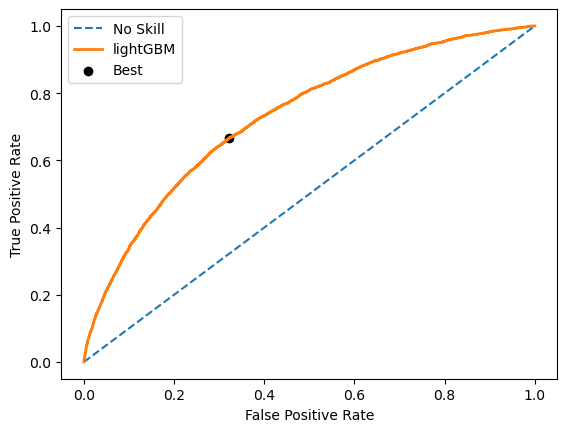

-------------------------
Running predictions with the best threshold
[LightGBM] [Warning] lambda_l1 is set=0.706184239474385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.706184239474385
[LightGBM] [Warning] lambda_l2 is set=0.19463527299726424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19463527299726424
[LightGBM] [Warning] min_data_in_leaf is set=135, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=135


2024/01/13 11:30:02 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.73
Cost ratio score: 0.56
Recall: 0.66
Precision: 0.15
F1 score: 0.25
F beta_10: 0.64
Accuracy: 0.68
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     56619
           1       0.15      0.66      0.25      4884

    accuracy                           0.68     61503
   macro avg       0.56      0.67      0.52     61503
weighted avg       0.89      0.68      0.75     61503

Best Threshold: 0.5


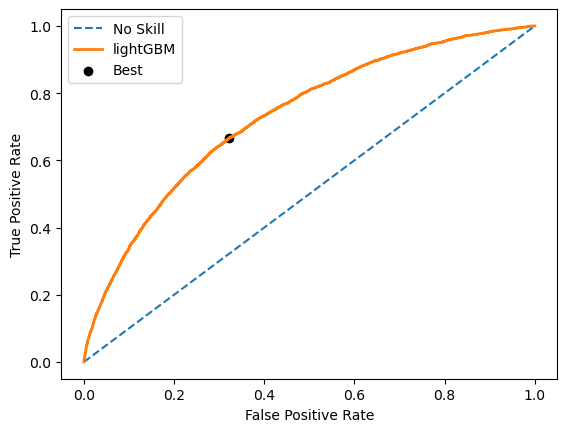

-------------------------


2024/01/13 11:30:04 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


execution time: 114.78 seconds 



In [294]:
cv_hyperopt_best_config = {
   'preprocessing': lgbm_preprocess_config,
    'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        'params': {
            'n_estimators': hyperopt_best_params['n_estimators'],
            'num_leaves': int(hyperopt_best_params['num_leaves']),
            'colsample_bytree': hyperopt_best_params['colsample_bytree'],
            'min_data_in_leaf': int(hyperopt_best_params['min_data_in_leaf']),
            'max_depth': hyperopt_best_params['max_depth'],
            'learning_rate': hyperopt_best_params['learning_rate'],
            'subsample_for_bin': int(hyperopt_best_params['subsample_for_bin']),
            'lambda_l1': hyperopt_best_params['lambda_l1'],
            'lambda_l2': hyperopt_best_params['lambda_l2'],
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'LightGBM_hyperopt_best_config'):
    train('lightGBM', config=cv_hyperopt_best_config, dev_mode=False, should_save_model=False)

mlflow.end_run()

In [125]:
mlflow.end_run()

## XGBoost

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

In [182]:
# Set the experiment
mlflow.set_experiment("XGBoost")

# Track models automatically
mlflow.sklearn.autolog()

### Baseline

Training the model


2024/01/09 10:00:56 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('encoder', ApplicationEncoder()),
                ('downcaster', FeatureDowncaster())])), ('classifier', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, ...`
2024/01/09 10:00:56 WARNING mlflow.utils: Truncated the value of the key `classifier`. Truncated value: `XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=

Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/09 10:00:58 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/09 10:01:55 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/09 10:01:59 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/09 10:02:00 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values ha

-------------------------
AUC: 0.76
Cost ratio score: 0.76
Recall: 0.05
Precision: 0.44
F1 score: 0.08
F beta_10: 0.05
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.44      0.05      0.08      4884

    accuracy                           0.92     61503
   macro avg       0.68      0.52      0.52     61503
weighted avg       0.89      0.92      0.89     61503

Best Threshold: 0.07000000029802322


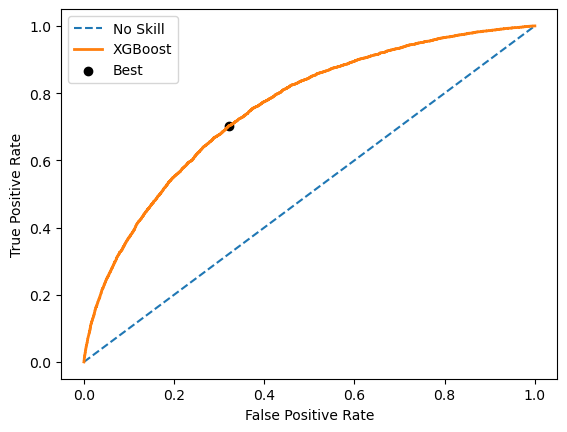

-------------------------
Running predictions with the best threshold


2024/01/09 10:02:02 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.76
Cost ratio score: 0.53
Recall: 0.71
Precision: 0.16
F1 score: 0.26
F beta_10: 0.68
Accuracy: 0.67
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     56619
           1       0.16      0.71      0.26      4884

    accuracy                           0.67     61503
   macro avg       0.56      0.69      0.52     61503
weighted avg       0.90      0.67      0.75     61503

Best Threshold: 0.07000000029802322


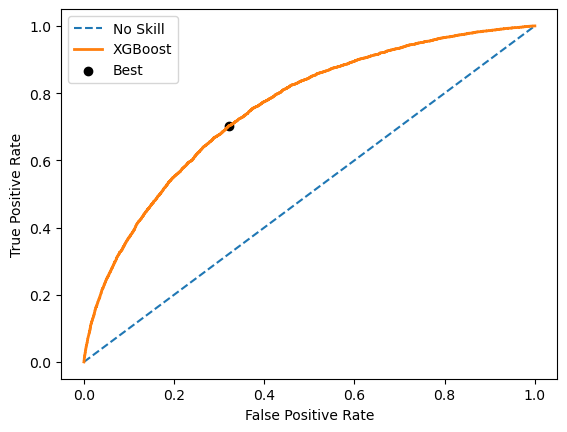

-------------------------
execution time: 70.11 seconds 



In [144]:
baseline_config_xgb = {
    'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': False,
        'features_to_keep': [],
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'eta': 0.3,
            'max_depth': 6,
            'colsample_bytree': 1.0,
            'subsample': 1,
            'scale_pos_weight': 1
        }
    }
}

with mlflow.start_run(run_name = 'XGBoost_baseline'):
    train('XGBoost', config=baseline_config_xgb, dev_mode=False)

mlflow.end_run()

### Class balancing configuration

We will use directly the class weights model parameter to handle the imbalanced data given that SMOTE/SMOTE-NC techniques require the NaN values to be filled. XGBoost can automatically learn how to best handle missing data, it was designed to work with sparse data, like the one hot encoded data, and missing data is handled the same way that sparse or zero values are handled, by minimizing the loss function.

#### Class weights

We can control the balance of positive and negative weights with the `scale_pos_weight` parameter. The XGBoost documentation suggests a fast way to estimate this value using the training dataset as the total number of examples in the majority class divided by the total number of examples in the minority class:

`scale_pos_weight = total_negative_examples / total_positive_examples`

In our case this would be equal to ~11

Training the model


2024/01/09 10:24:06 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('encoder', ApplicationEncoder()),
                ('downcaster', FeatureDowncaster())])), ('classifier', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, ...`
2024/01/09 10:24:06 WARNING mlflow.utils: Truncated the value of the key `classifier`. Truncated value: `XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=

Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/09 10:24:08 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/09 10:25:06 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/09 10:25:10 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/01/09 10:25:12 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values ha

-------------------------
AUC: 0.75
Cost ratio score: 0.55
Recall: 0.52
Precision: 0.2
F1 score: 0.28
F beta_10: 0.52
Accuracy: 0.79
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.88     56619
           1       0.20      0.52      0.28      4884

    accuracy                           0.79     61503
   macro avg       0.57      0.67      0.58     61503
weighted avg       0.89      0.79      0.83     61503

Best Threshold: 0.3799999952316284


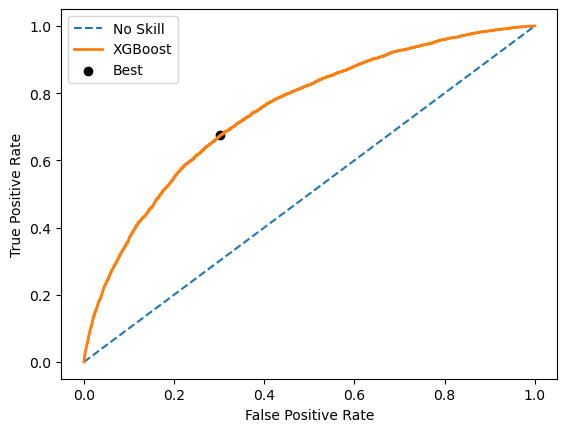

-------------------------
Running predictions with the best threshold


2024/01/09 10:25:14 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.75
Cost ratio score: 0.54
Recall: 0.68
Precision: 0.16
F1 score: 0.26
F beta_10: 0.66
Accuracy: 0.69
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56619
           1       0.16      0.68      0.26      4884

    accuracy                           0.69     61503
   macro avg       0.56      0.69      0.53     61503
weighted avg       0.90      0.69      0.76     61503

Best Threshold: 0.3799999952316284


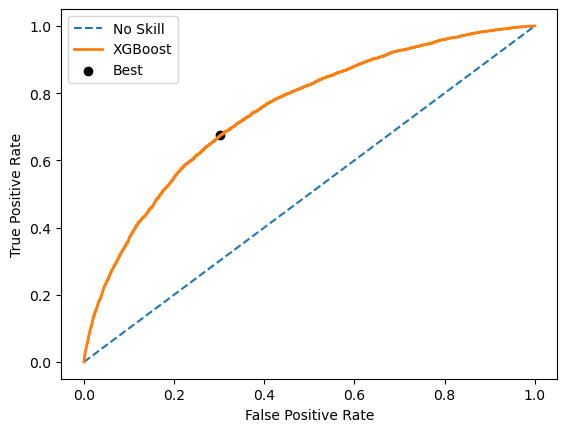

-------------------------
execution time: 71.22 seconds 



In [149]:
class_weights_config_xgb = {
    'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': False,
        'features_to_keep': [],
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'eta': 0.3,
            'max_depth': 6,
            'colsample_bytree': 1.0,
            'subsample': 1,
            'scale_pos_weight': 11
        }
    }
}

with mlflow.start_run(run_name = 'XGBoost_class_weigths'):
    train('XGBoost', config=class_weights_config_xgb, dev_mode=False)

mlflow.end_run()

### Feature engineering
#### Credit history

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/09 10:28:38 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/09 10:28:39 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.76
Cost ratio score: 0.52
Recall: 0.6
Precision: 0.19
F1 score: 0.29
F beta_10: 0.59
Accuracy: 0.77
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.79      0.86     56619
           1       0.19      0.60      0.29      4884

    accuracy                           0.77     61503
   macro avg       0.58      0.69      0.58     61503
weighted avg       0.90      0.77      0.82     61503

Best Threshold: 0.4099999964237213


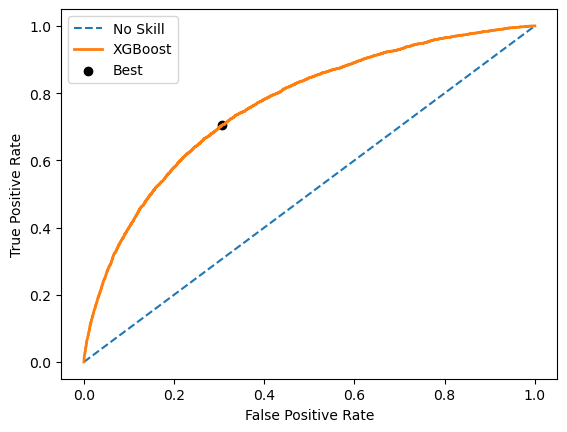

-------------------------
Running predictions with the best threshold


2024/01/09 10:31:41 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.76
Cost ratio score: 0.52
Recall: 0.7
Precision: 0.17
F1 score: 0.27
F beta_10: 0.68
Accuracy: 0.69
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.69      0.81     56619
           1       0.17      0.70      0.27      4884

    accuracy                           0.69     61503
   macro avg       0.56      0.70      0.54     61503
weighted avg       0.90      0.69      0.76     61503

Best Threshold: 0.4099999964237213


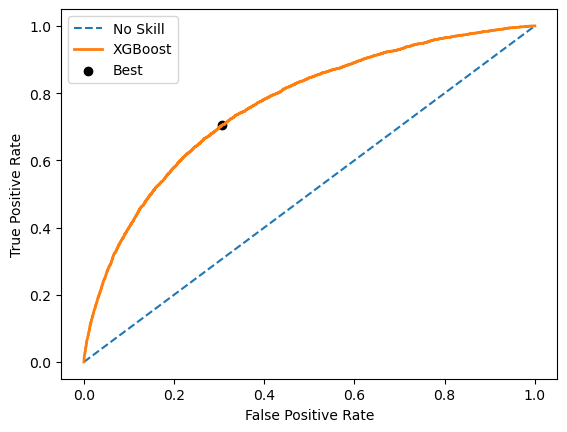

-------------------------
execution time: 207.05 seconds 



In [150]:
credit_history_config_xgb = {
    'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': False,
        'features_to_keep': [],
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'eta': 0.3,
            'max_depth': 6,
            'colsample_bytree': 1.0,
            'subsample': 1,
            'scale_pos_weight': 11
        }
    }
}

with mlflow.start_run(run_name = 'XGBoost_credit_history'):
    train('XGBoost', config=credit_history_config_xgb, dev_mode=False)

mlflow.end_run()

#### Full history

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/09 10:33:17 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/09 10:33:19 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.77
Cost ratio score: 0.52
Recall: 0.59
Precision: 0.2
F1 score: 0.29
F beta_10: 0.58
Accuracy: 0.78
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.79      0.87     56619
           1       0.20      0.59      0.29      4884

    accuracy                           0.78     61503
   macro avg       0.58      0.69      0.58     61503
weighted avg       0.90      0.78      0.82     61503

Best Threshold: 0.38999998569488525


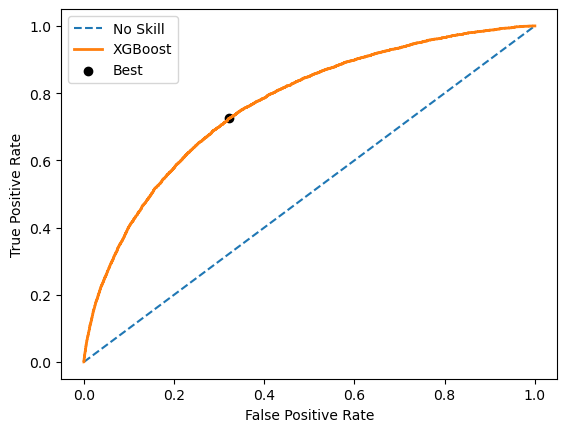

-------------------------
Running predictions with the best threshold


2024/01/09 10:37:20 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.77
Cost ratio score: 0.51
Recall: 0.72
Precision: 0.16
F1 score: 0.27
F beta_10: 0.7
Accuracy: 0.68
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.68      0.80     56619
           1       0.16      0.72      0.27      4884

    accuracy                           0.68     61503
   macro avg       0.56      0.70      0.53     61503
weighted avg       0.90      0.68      0.76     61503

Best Threshold: 0.38999998569488525


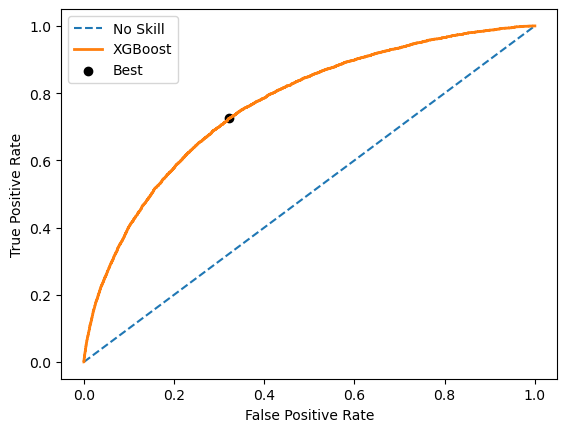

-------------------------
execution time: 293.88 seconds 



In [151]:
full_history_config_xgb = {
    'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': False,
        'features_to_keep': [],
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'eta': 0.3,
            'max_depth': 6,
            'colsample_bytree': 1.0,
            'subsample': 1,
            'scale_pos_weight': 11
        }
    }
}

with mlflow.start_run(run_name = 'XGBoost_full_history'):
    train('XGBoost', config=full_history_config_xgb, dev_mode=False)

mlflow.end_run()

#### Selected features

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/09 10:38:43 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/09 10:38:44 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.72
Cost ratio score: 0.58
Recall: 0.58
Precision: 0.16
F1 score: 0.25
F beta_10: 0.57
Accuracy: 0.72
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.73      0.83     56619
           1       0.16      0.58      0.25      4884

    accuracy                           0.72     61503
   macro avg       0.56      0.66      0.54     61503
weighted avg       0.89      0.72      0.78     61503

Best Threshold: 0.44999998807907104


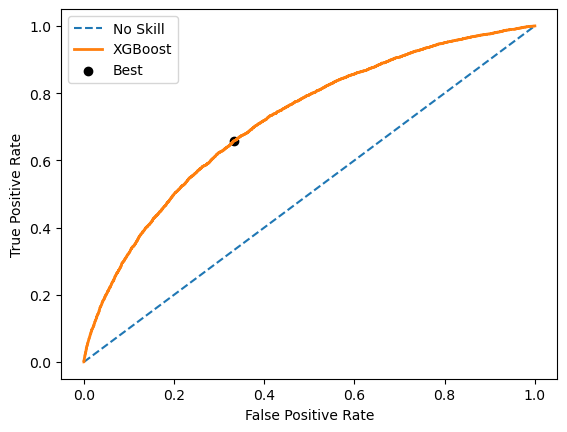

-------------------------
Running predictions with the best threshold


2024/01/09 10:39:38 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.72
Cost ratio score: 0.58
Recall: 0.66
Precision: 0.15
F1 score: 0.24
F beta_10: 0.64
Accuracy: 0.67
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     56619
           1       0.15      0.66      0.24      4884

    accuracy                           0.67     61503
   macro avg       0.55      0.66      0.51     61503
weighted avg       0.89      0.67      0.74     61503

Best Threshold: 0.44999998807907104


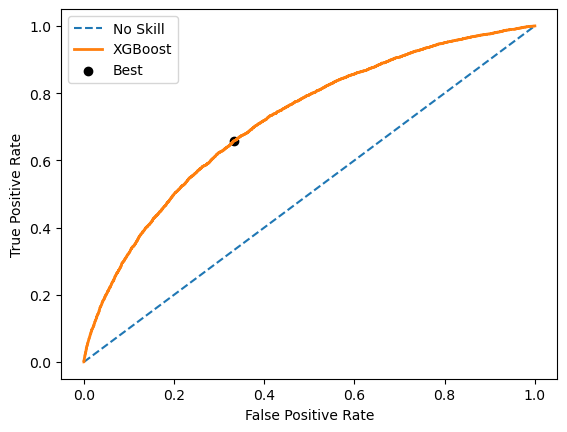

-------------------------
execution time: 106.21 seconds 



In [152]:
selected_features_config_xgb = {
    'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'eta': 0.3,
            'max_depth': 6,
            'colsample_bytree': 1.0,
            'subsample': 1,
            'scale_pos_weight': 11
        }
    }
}

with mlflow.start_run(run_name = 'XGBoost_best_features'):
    train('XGBoost', config=selected_features_config_xgb, dev_mode=False)

mlflow.end_run()

### Preprocessing
#### Filling missing values

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/09 10:41:06 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/09 10:41:07 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.71
Cost ratio score: 0.59
Recall: 0.58
Precision: 0.15
F1 score: 0.24
F beta_10: 0.57
Accuracy: 0.71
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     56619
           1       0.15      0.58      0.24      4884

    accuracy                           0.71     61503
   macro avg       0.55      0.65      0.53     61503
weighted avg       0.89      0.71      0.77     61503

Best Threshold: 0.47999998927116394


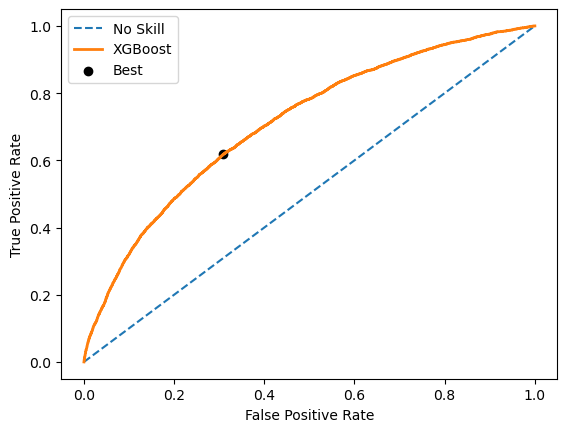

-------------------------
Running predictions with the best threshold


2024/01/09 10:42:11 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.71
Cost ratio score: 0.59
Recall: 0.62
Precision: 0.15
F1 score: 0.24
F beta_10: 0.6
Accuracy: 0.69
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.69      0.80     56619
           1       0.15      0.62      0.24      4884

    accuracy                           0.69     61503
   macro avg       0.55      0.65      0.52     61503
weighted avg       0.89      0.69      0.76     61503

Best Threshold: 0.47999998927116394


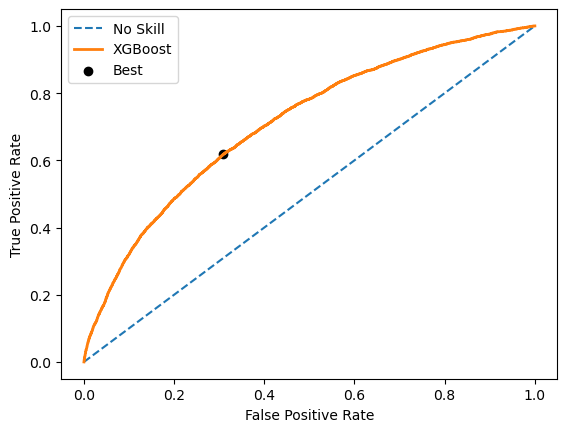

-------------------------
execution time: 118.1 seconds 



In [153]:
fill_nan_config_xgb = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'eta': 0.3,
            'max_depth': 6,
            'colsample_bytree': 1.0,
            'subsample': 1,
            'scale_pos_weight': 11
        }
    }
}

with mlflow.start_run(run_name = 'XGBoost_fill_nan'):
    train('XGBoost', config=fill_nan_config_xgb, dev_mode=False)

mlflow.end_run()

Filling null values degraded the main score, AUC and Fbeta 10.

#### Removing outliers

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/09 10:45:17 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/09 10:45:19 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.71
Cost ratio score: 0.58
Recall: 0.57
Precision: 0.16
F1 score: 0.25
F beta_10: 0.56
Accuracy: 0.72
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.73      0.83     56619
           1       0.16      0.57      0.25      4884

    accuracy                           0.72     61503
   macro avg       0.55      0.65      0.54     61503
weighted avg       0.89      0.72      0.78     61503

Best Threshold: 0.46000000834465027


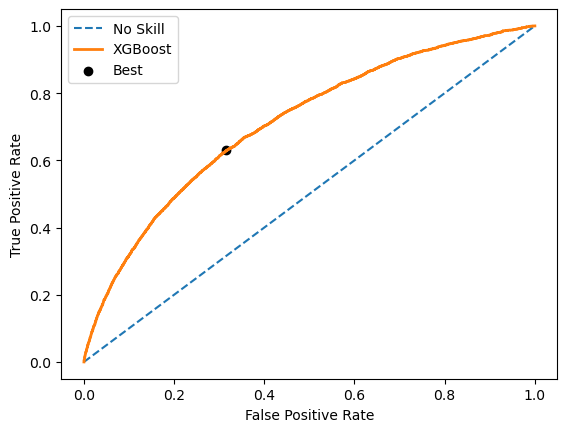

-------------------------
Running predictions with the best threshold


2024/01/09 10:46:25 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.71
Cost ratio score: 0.59
Recall: 0.63
Precision: 0.15
F1 score: 0.24
F beta_10: 0.61
Accuracy: 0.68
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     56619
           1       0.15      0.63      0.24      4884

    accuracy                           0.68     61503
   macro avg       0.55      0.66      0.52     61503
weighted avg       0.89      0.68      0.75     61503

Best Threshold: 0.46000000834465027


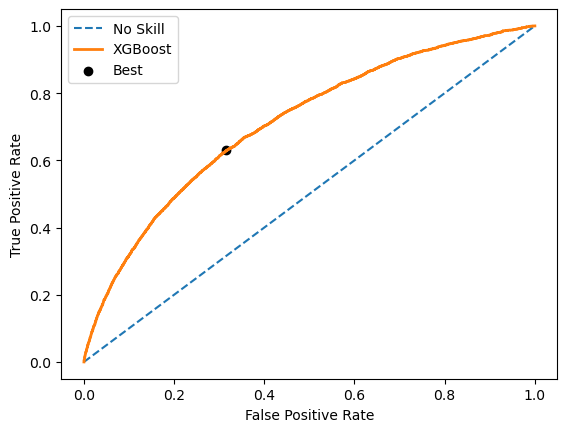

-------------------------
execution time: 120.22 seconds 



In [154]:
remove_outliers1_config_xgb = {
    'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'eta': 0.3,
            'max_depth': 6,
            'colsample_bytree': 1.0,
            'subsample': 1,
            'scale_pos_weight': 11
        }
    }
}

with mlflow.start_run(run_name = 'XGBoost_remove_outliers1'):
    train('XGBoost', config=remove_outliers1_config_xgb, dev_mode=False)

mlflow.end_run()

With IQR factor = 2.5

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/09 10:47:57 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/09 10:47:59 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.71
Cost ratio score: 0.58
Recall: 0.58
Precision: 0.16
F1 score: 0.25
F beta_10: 0.56
Accuracy: 0.72
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.73      0.83     56619
           1       0.16      0.58      0.25      4884

    accuracy                           0.72     61503
   macro avg       0.56      0.66      0.54     61503
weighted avg       0.89      0.72      0.78     61503

Best Threshold: 0.46000000834465027


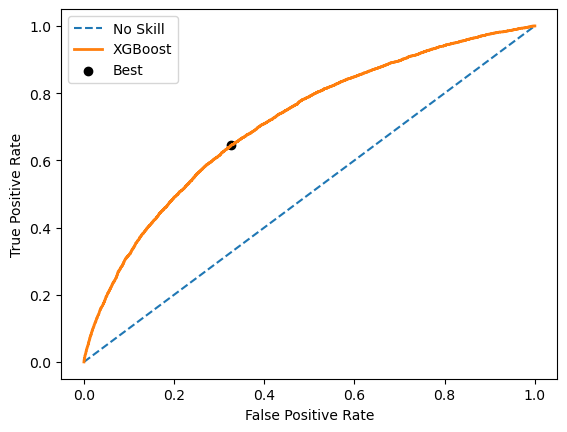

-------------------------
Running predictions with the best threshold


2024/01/09 10:49:06 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.71
Cost ratio score: 0.58
Recall: 0.64
Precision: 0.15
F1 score: 0.24
F beta_10: 0.62
Accuracy: 0.68
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.79     56619
           1       0.15      0.64      0.24      4884

    accuracy                           0.68     61503
   macro avg       0.55      0.66      0.52     61503
weighted avg       0.89      0.68      0.75     61503

Best Threshold: 0.46000000834465027


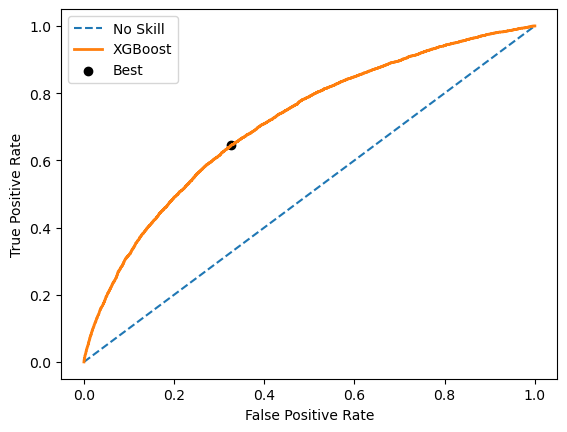

-------------------------
execution time: 120.51 seconds 



In [155]:
remove_outliers2_config_xgb = {
    'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 2.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'eta': 0.3,
            'max_depth': 6,
            'colsample_bytree': 1.0,
            'subsample': 1,
            'scale_pos_weight': 11
        }
    }
}

with mlflow.start_run(run_name = 'XGBoost_remove_outliers2'):
    train('XGBoost', config=remove_outliers2_config_xgb, dev_mode=False)

mlflow.end_run()

Removing outliers did not improve the score but degraded AUC and Fbeta 10.

#### Scaling
**StandardScaler**

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/09 10:51:43 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/09 10:51:44 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.72
Cost ratio score: 0.58
Recall: 0.58
Precision: 0.16
F1 score: 0.25
F beta_10: 0.57
Accuracy: 0.72
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.73      0.83     56619
           1       0.16      0.58      0.25      4884

    accuracy                           0.72     61503
   macro avg       0.56      0.66      0.54     61503
weighted avg       0.89      0.72      0.78     61503

Best Threshold: 0.44999998807907104


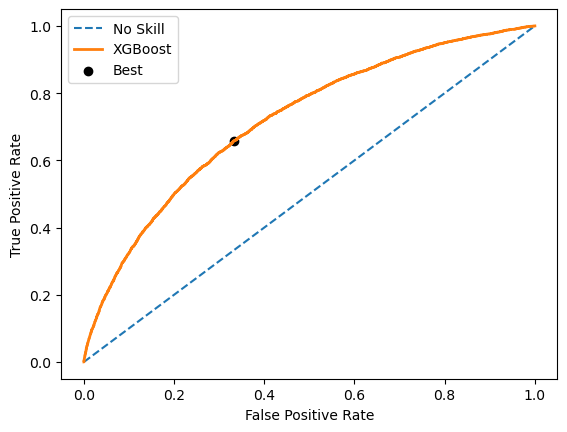

-------------------------
Running predictions with the best threshold


2024/01/09 10:52:53 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.72
Cost ratio score: 0.58
Recall: 0.66
Precision: 0.15
F1 score: 0.24
F beta_10: 0.64
Accuracy: 0.67
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     56619
           1       0.15      0.66      0.24      4884

    accuracy                           0.67     61503
   macro avg       0.55      0.66      0.51     61503
weighted avg       0.89      0.67      0.74     61503

Best Threshold: 0.44999998807907104


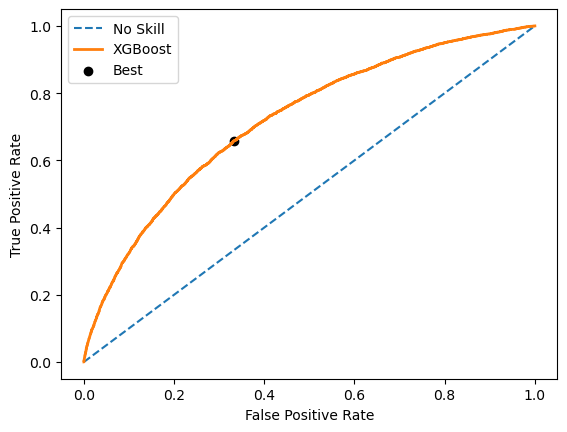

-------------------------
execution time: 121.7 seconds 



In [156]:
standard_scaler_config_xgb = {
    'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'eta': 0.3,
            'max_depth': 6,
            'colsample_bytree': 1.0,
            'subsample': 1,
            'scale_pos_weight': 11
        }
    }
}

with mlflow.start_run(run_name = 'XGBoost_standard_scaler'):
    train('XGBoost', config=standard_scaler_config_xgb, dev_mode=False)

mlflow.end_run()

**MinMaxScaler**

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/09 10:54:47 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/09 10:54:48 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.72
Cost ratio score: 0.58
Recall: 0.58
Precision: 0.16
F1 score: 0.25
F beta_10: 0.56
Accuracy: 0.73
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.74      0.83     56619
           1       0.16      0.58      0.25      4884

    accuracy                           0.73     61503
   macro avg       0.56      0.66      0.54     61503
weighted avg       0.89      0.73      0.79     61503

Best Threshold: 0.46000000834465027


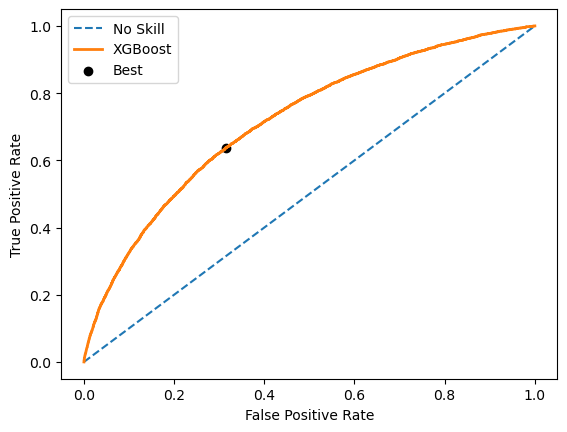

-------------------------
Running predictions with the best threshold


2024/01/09 10:55:53 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.72
Cost ratio score: 0.58
Recall: 0.64
Precision: 0.15
F1 score: 0.24
F beta_10: 0.62
Accuracy: 0.68
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     56619
           1       0.15      0.64      0.24      4884

    accuracy                           0.68     61503
   macro avg       0.55      0.66      0.52     61503
weighted avg       0.89      0.68      0.75     61503

Best Threshold: 0.46000000834465027


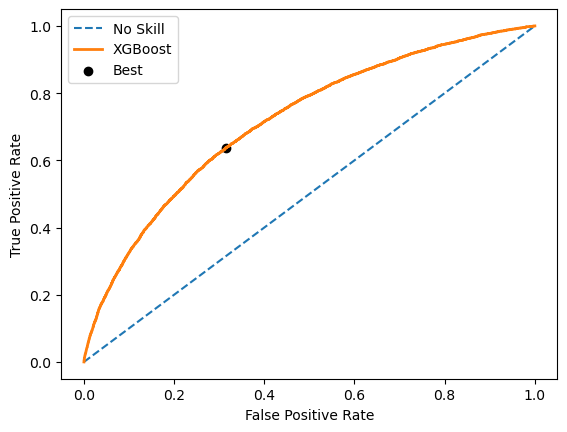

-------------------------
execution time: 118.18 seconds 



In [157]:
minmax_scaler_config_xgb = {
    'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': MinMaxScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'eta': 0.3,
            'max_depth': 6,
            'colsample_bytree': 1.0,
            'subsample': 1,
            'scale_pos_weight': 11
        }
    }
}

with mlflow.start_run(run_name = 'XGBoost_minmax_scaler'):
    train('XGBoost', config=minmax_scaler_config_xgb, dev_mode=False)

mlflow.end_run()

**RobustScaler**

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/09 10:59:13 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/09 10:59:15 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.72
Cost ratio score: 0.58
Recall: 0.58
Precision: 0.16
F1 score: 0.25
F beta_10: 0.57
Accuracy: 0.72
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.73      0.83     56619
           1       0.16      0.58      0.25      4884

    accuracy                           0.72     61503
   macro avg       0.56      0.66      0.54     61503
weighted avg       0.89      0.72      0.78     61503

Best Threshold: 0.44999998807907104


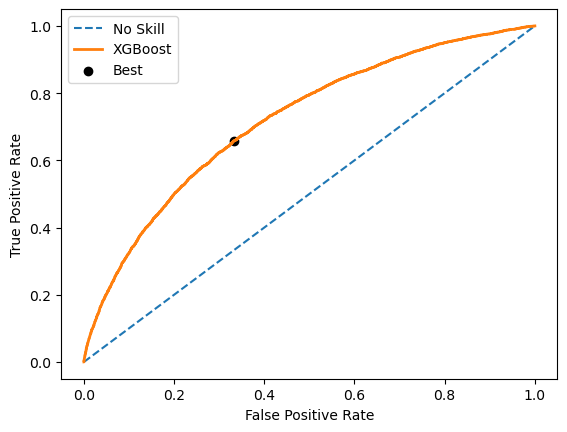

-------------------------
Running predictions with the best threshold


2024/01/09 11:00:24 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.72
Cost ratio score: 0.58
Recall: 0.66
Precision: 0.15
F1 score: 0.24
F beta_10: 0.64
Accuracy: 0.67
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     56619
           1       0.15      0.66      0.24      4884

    accuracy                           0.67     61503
   macro avg       0.55      0.66      0.51     61503
weighted avg       0.89      0.67      0.74     61503

Best Threshold: 0.44999998807907104


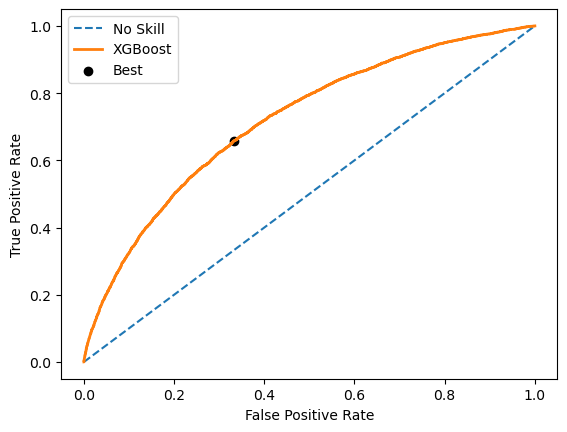

-------------------------
execution time: 121.55 seconds 



In [158]:
robust_scaler_config_xgb = {
    'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': RobustScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'eta': 0.3,
            'max_depth': 6,
            'colsample_bytree': 1.0,
            'subsample': 1,
            'scale_pos_weight': 11
        }
    }
}

with mlflow.start_run(run_name = 'XGBoost_robust_scaler'):
    train('XGBoost', config=robust_scaler_config_xgb, dev_mode=False)

mlflow.end_run()

Scaling did not improve the scores.

#### Normalize distribution

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/09 11:05:28 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/09 11:05:30 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.71
Cost ratio score: 0.59
Recall: 0.58
Precision: 0.15
F1 score: 0.24
F beta_10: 0.56
Accuracy: 0.71
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     56619
           1       0.15      0.58      0.24      4884

    accuracy                           0.71     61503
   macro avg       0.55      0.65      0.53     61503
weighted avg       0.89      0.71      0.78     61503

Best Threshold: 0.46000000834465027


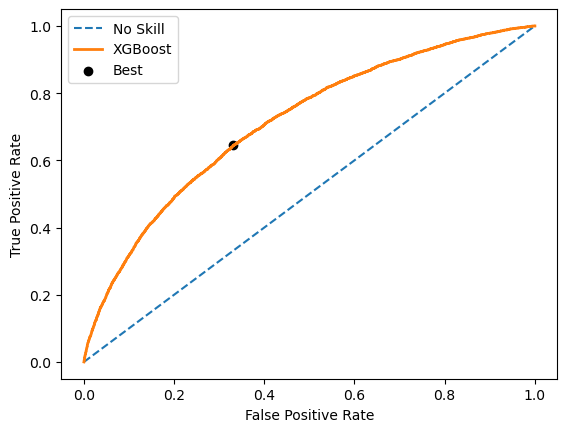

-------------------------
Running predictions with the best threshold


2024/01/09 11:08:02 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.71
Cost ratio score: 0.59
Recall: 0.65
Precision: 0.14
F1 score: 0.23
F beta_10: 0.63
Accuracy: 0.66
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.67      0.78     56619
           1       0.14      0.65      0.23      4884

    accuracy                           0.66     61503
   macro avg       0.55      0.66      0.51     61503
weighted avg       0.89      0.66      0.74     61503

Best Threshold: 0.46000000834465027


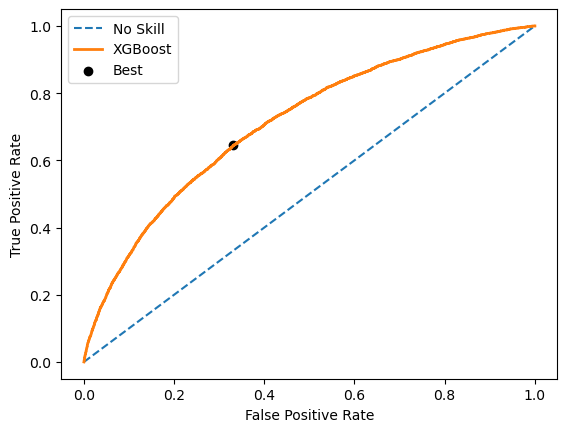

-------------------------
execution time: 205.23 seconds 



In [159]:
norm_dist_config_xgb = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_normalize_distribution': True,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'eta': 0.3,
            'max_depth': 6,
            'colsample_bytree': 1.0,
            'subsample': 1,
            'scale_pos_weight': 11
        }
    }
}

with mlflow.start_run(run_name = 'XGBoost_norm_dist'):
    train('XGBoost', config=norm_dist_config_xgb, dev_mode=False)

mlflow.end_run()

Normalizing distribution degraded the Cost Ratio Score, AUC and Fbeta 10.

In [160]:
xgb_preprocessing_config = {
    'should_fill_na': False,
    'num_imputer': SimpleImputer(strategy='median'),
    'cat_imputer': SimpleImputer(strategy='most_frequent'),
    'should_scale': False,
    'scaler': None,
    'should_remove_outliers': False,
    'iqr_factor': 1.5,
    'should_normalize_columns': False,
    'should_normalize_distribution': False,
    'should_downcast': True,
    'should_select_features': True,
    'features_to_keep': best_features,
    'use_bureau_and_balance': True,
    'use_previous_applications': True,
    'use_pos_cash_balance': True,
    'use_installments_payments': True,
    'use_credit_card_balance': True,
}

### Fine-tuning

As for the LightGBM, we will also opt for HyperOpt to fine tune the hyperparameters.

We will optimize the following hyperparameters:

- **eta:** alias 'learning_rate', step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
- **n_estimators:** determines the number of boosting rounds or trees to build. It directly impacts the model’s complexity.
- **gamma:** minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be
- **max_depth:** maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
- **min_child_weight:** minimum sum of instance weight (hessian) needed in a child
- **subsample:** subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.
- **lambda:** L2 regularization term on weights. Increasing this value will make model more conservative.
- **alpha:** L1 regularization term on weights. Increasing this value will make model more conservative.


In [249]:
data = process.load_application(dev_mode=False)

X = data.drop(process.TARGET_COLUMN, axis=1)
y = data[process.TARGET_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      shuffle=False)

In [250]:
space = {
    'classifier__eta':  hp.quniform('eta', 0.025, 0.5, 0.025),
    'classifier__n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'classifier__gamma':  hp.uniform('gamma', 1, 9),
    'classifier__max_depth': hp.quniform("max_depth", 3, 18, 1),
    'classifier__min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'classifier__subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'classifier__lambda':  hp.uniform('lambda', 0.0, 1),
    'classifier__alpha':  hp.quniform('alpha', 40, 180, 1),
    'classifier__scale_pos_weight': 11
}

hyperopt_config_xgb = {
   'preprocessing': xgb_preprocessing_config,
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'cv_splits': 5,
        'param_grid': space,
        'params': {}
    }
}

def objective(params):
    pipeline = PIPELINES['XGBoost'](config=hyperopt_config_xgb, dev_mode=False)
    cv = StratifiedKFold(n_splits=5, shuffle=False)
    
    scores = cross_val_score(
        estimator=pipeline,
        X=X_train,
        y=y_train,
        cv=cv, 
        scoring=cost_ratio_scorer,
        n_jobs=-1
    )
    
    return min(scores)
   
    
tpe_algorithm = tpe.suggest

# Trials object to track progress
bayes_trials = Trials()

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 10, trials = bayes_trials)
print(best)

  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inste

 10%|▊       | 1/10 [01:55<17:18, 115.38s/trial, best loss: -0.7991951546685094]

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inste

 20%|█▌      | 2/10 [03:46<15:04, 113.04s/trial, best loss: -0.7991951546685094]

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inste

 30%|██▍     | 3/10 [05:38<13:07, 112.47s/trial, best loss: -0.7991951546685094]

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inste

 40%|███▏    | 4/10 [07:28<11:09, 111.65s/trial, best loss: -0.7991951546685094]

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inste

 50%|████    | 5/10 [09:20<09:18, 111.62s/trial, best loss: -0.7991951546685094]

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inste

 60%|████▊   | 6/10 [11:10<07:24, 111.09s/trial, best loss: -0.7991951546685094]

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inste

 70%|█████▌  | 7/10 [12:59<05:31, 110.46s/trial, best loss: -0.7991951546685094]

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inste

 80%|██████▍ | 8/10 [14:50<03:41, 110.59s/trial, best loss: -0.7991951546685094]

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inste

 90%|███████▏| 9/10 [16:43<01:51, 111.35s/trial, best loss: -0.7991951546685094]

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inste

100%|███████| 10/10 [18:36<00:00, 111.66s/trial, best loss: -0.7991951546685094]
{'alpha': 141.0, 'eta': 0.225, 'gamma': 6.441402984201104, 'lambda': 0.9666114292666362, 'max_depth': 17.0, 'min_child_weight': 2.0, 'n_estimators': 707.0, 'subsample': 0.8}


In [251]:
best

{'alpha': 141.0,
 'eta': 0.225,
 'gamma': 6.441402984201104,
 'lambda': 0.9666114292666362,
 'max_depth': 17.0,
 'min_child_weight': 2.0,
 'n_estimators': 707.0,
 'subsample': 0.8}

Fit with the best hyperopt parameters

Training the model
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2024/01/09 16:51:08 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/09 16:51:09 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.71
Cost ratio score: 0.6
Recall: 0.44
Precision: 0.18
F1 score: 0.26
F beta_10: 0.44
Accuracy: 0.8
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.83      0.88     56619
           1       0.18      0.44      0.26      4884

    accuracy                           0.80     61503
   macro avg       0.56      0.64      0.57     61503
weighted avg       0.88      0.80      0.83     61503

Best Threshold: 0.3199999928474426


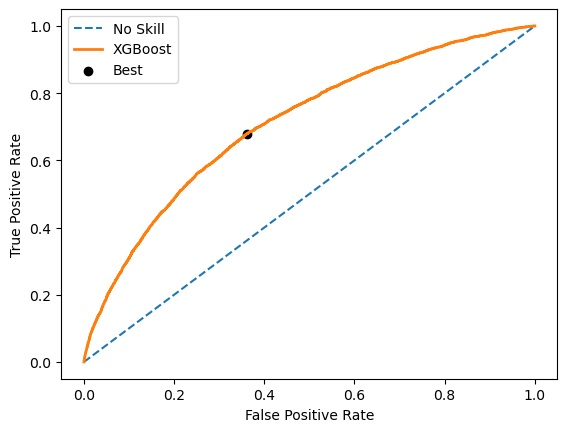

-------------------------
Running predictions with the best threshold


2024/01/09 16:54:46 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.71
Cost ratio score: 0.59
Recall: 0.68
Precision: 0.14
F1 score: 0.23
F beta_10: 0.65
Accuracy: 0.64
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.64      0.77     56619
           1       0.14      0.68      0.23      4884

    accuracy                           0.64     61503
   macro avg       0.55      0.66      0.50     61503
weighted avg       0.89      0.64      0.73     61503

Best Threshold: 0.3199999928474426


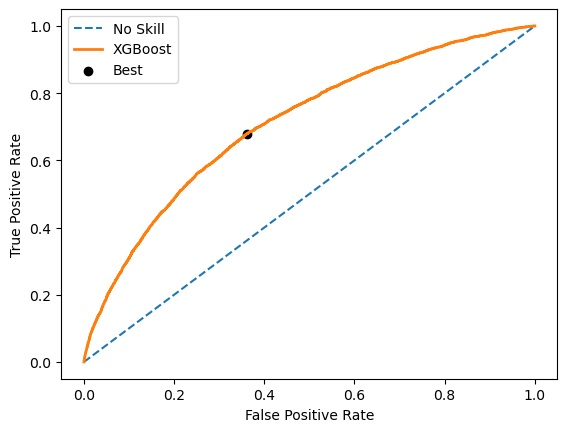

-------------------------
execution time: 270.45 seconds 



In [253]:
hyperopt_best_config_xgb = {
    'preprocessing': xgb_preprocessing_config,
    'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        'params': {
            'eta': best['eta'],
            'n_estimators': int(best['n_estimators']),
            'gamma': best['gamma'],
            'max_depth': int(best['max_depth']),
            'min_child_weight': best['min_child_weight'],
            'subsample': best['subsample'],
            'lambda': best['lambda'],
            'alpha': best['alpha'],
            'scale_pos_weight': 11
        }
    }
}

with mlflow.start_run(run_name = 'XGBoost_hyperopt_best_config'):
    train('XGBoost', config=hyperopt_best_config_xgb, dev_mode=False, should_save_model=False)

mlflow.end_run()

# Feature importance

Feature importance refers to a class of techniques for assigning scores to input features to a model that indicates the relative importance of each feature when making a prediction. A higher score means that the specific feature will have a larger effect on the model that is being used to predict a certain variable.

There are different methods to calculate feature importance, in this project we will focus on 2 of them:
1. Feature importance property of lightGBM model
2. SHAP library

In [189]:
dev_mode = False
time_start = time.time()

data = process.load_application(dev_mode=dev_mode)

X = data.drop(process.TARGET_COLUMN, axis=1)
y = data[process.TARGET_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      shuffle=False)

print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(y_train.shape))

lgbm_pipeline = PIPELINES['lightGBM'](config=cv_hyperopt_best_config, dev_mode=dev_mode)

print('Start pipeline fit and transform')
lgbm_pipeline.fit(X_train, y_train)

# features coef
lgbm_model = lgbm_pipeline.named_steps["classifier"]
lgbm_feature_names = lgbm_pipeline.named_steps["preprocessor"].transform(X_train).columns
    
exec_time = round((time.time() - time_start), 2)
print(f'execution time: {exec_time} seconds \n')


Train shape: (246008, 121)
Valid shape: (246008,)


2024/01/09 14:51:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0e45c56363634ff88f8878b0fcff6fa6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Start pipeline fit and transform


2024/01/09 14:51:29 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2024/01/09 14:51:31 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

[LightGBM] [Warning] lambda_l1 is set=0.706184239474385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.706184239474385
[LightGBM] [Warning] lambda_l2 is set=0.19463527299726424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19463527299726424
[LightGBM] [Warning] min_data_in_leaf is set=135, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=135
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] lambda_l1 is set=0.706184239474385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.706184239474385
[LightGBM] [Warning] lambda_l2 is set=0.19463527299726424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19463527299726424
[LightGBM] [Warning] min_data_in_leaf is set=135, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=135
[LightGBM] [Info] Number of positive: 19941, number of negative: 226067
[LightGBM] [Info] Auto-choosi

2024/01/09 14:52:22 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[LightGBM] [Warning] lambda_l1 is set=0.706184239474385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.706184239474385
[LightGBM] [Warning] lambda_l2 is set=0.19463527299726424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19463527299726424
[LightGBM] [Warning] min_data_in_leaf is set=135, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=135


2024/01/09 14:52:25 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyarrow-hotfix'}


execution time: 113.12 seconds 



## Model feature importance

We can get the feature importance by calling the feature_importances_ parameter of the LightGBM model.

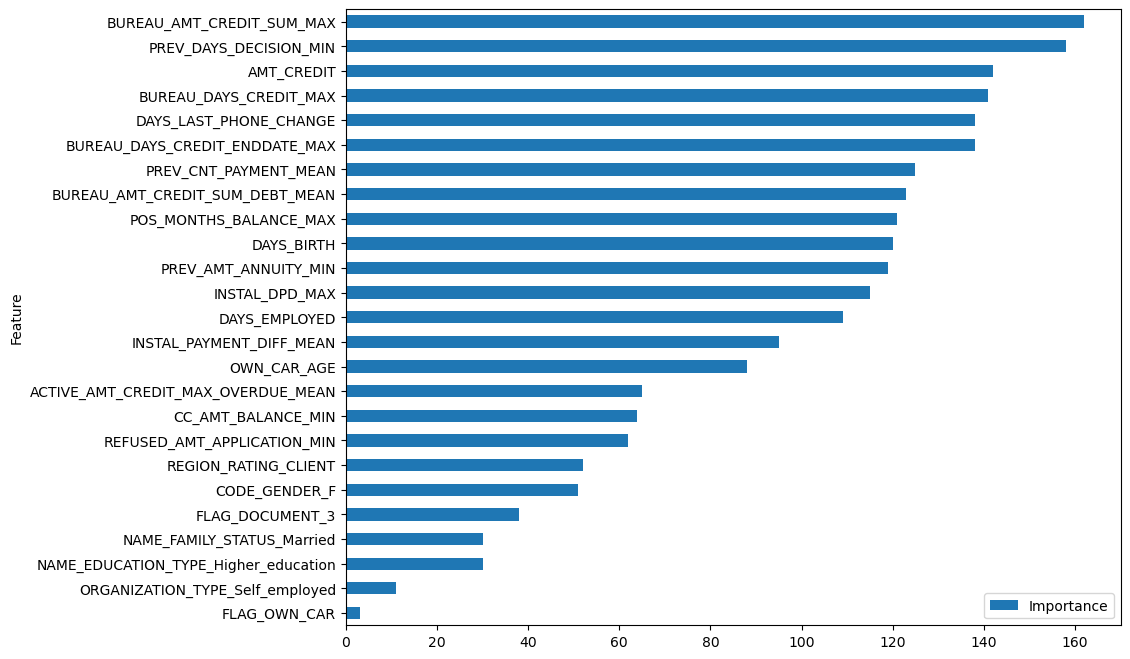

In [190]:
feature_importance = pd.DataFrame({'Feature': lgbm_feature_names, 'Importance': lgbm_model.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 8))
plt.show()

## SHAP

The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. SHAP feature importance is an alternative to permutation feature importance. There is a big difference between both importance measures: Permutation feature importance is based on the decrease in model performance. SHAP is based on magnitude of feature attributions.

In [191]:
# explain the model
explainer = shap.TreeExplainer(lgbm_model)
X_test_processed = lgbm_pipeline.named_steps["preprocessor"].transform(X_test)
shap_values_all = explainer(X_test_processed)
shap_values_all

.values =
array([[[ 0.155818  , -0.155818  ],
        [-0.0999241 ,  0.0999241 ],
        [-0.06588064,  0.06588064],
        ...,
        [ 0.00745156, -0.00745156],
        [-0.00207523,  0.00207523],
        [-0.04439922,  0.04439922]],

       [[ 0.12404951, -0.12404951],
        [ 0.39187954, -0.39187954],
        [-0.07531096,  0.07531096],
        ...,
        [ 0.01924049, -0.01924049],
        [ 0.00161003, -0.00161003],
        [-0.05070882,  0.05070882]],

       [[ 0.19104191, -0.19104191],
        [-0.08729465,  0.08729465],
        [-0.08408528,  0.08408528],
        ...,
        [ 0.01603165, -0.01603165],
        [-0.00207523,  0.00207523],
        [-0.03691783,  0.03691783]],

       ...,

       [[ 0.14695951, -0.14695951],
        [ 0.2460971 , -0.2460971 ],
        [-0.06545802,  0.06545802],
        ...,
        [ 0.00653677, -0.00653677],
        [-0.00155219,  0.00155219],
        [-0.0391272 ,  0.0391272 ]],

       [[ 0.11435433, -0.11435433],
        [-0.11072

**Mean reference value**

In [192]:
shap_values_all.base_values[0]

array([ 0.32090141, -0.32090141])

In [193]:
shap_values = explainer.shap_values(X_test_processed)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Values for the class 1

In [194]:
shap_values[1]

array([[-0.155818  ,  0.0999241 ,  0.06588064, ..., -0.00745156,
         0.00207523,  0.04439922],
       [-0.12404951, -0.39187954,  0.07531096, ..., -0.01924049,
        -0.00161003,  0.05070882],
       [-0.19104191,  0.08729465,  0.08408528, ..., -0.01603165,
         0.00207523,  0.03691783],
       ...,
       [-0.14695951, -0.2460971 ,  0.06545802, ..., -0.00653677,
         0.00155219,  0.0391272 ],
       [-0.11435433,  0.11072276, -0.04043687, ..., -0.01709411,
         0.00304225,  0.05350726],
       [-0.08706072, -0.2341534 , -0.02000445, ..., -0.02313981,
         0.00308068,  0.07280997]])

In [195]:
shap_values_df = pd.DataFrame(data=shap_values[1], columns=X_test_processed.columns)
shap_values_df.shape

(61503, 25)

In [196]:
shap_values_df.head()

CODE_GENDER_F  NAME_EDUCATION_TYPE_Higher_education  \
0        -0.1558                                0.0999   
1        -0.1240                               -0.3919   
2        -0.1910                                0.0873   
3        -0.1324                                0.0739   
4        -0.1068                                0.1063   

   NAME_FAMILY_STATUS_Married  ORGANIZATION_TYPE_Self_employed  AMT_CREDIT  \
0                      0.0659                          -0.0063      0.1703   
1                      0.0753                          -0.0063      0.0437   
2                      0.0841                           0.0676      0.0704   
3                     -0.0608                           0.0101      0.0934   
4                     -0.0190                          -0.0072     -0.1106   

   DAYS_BIRTH  DAYS_EMPLOYED  OWN_CAR_AGE  REGION_RATING_CLIENT  \
0      0.0411         0.1092       0.0556               -0.0007   
1      0.1065        -0.3909      -0.2994               -0.0129   
2     -0.0178         0.2614       0.0950                0.0126   
3     -0.0472         0.1991       0.0705               -0.3503   
4      0.2945         0.1816      -0.1280               -0.0107   

   DAYS_LAST_PHONE_CHANGE  ...  PREV_AMT_ANNUITY_MIN  PREV_DAYS_DECISION_MIN  \
0                 -0.0453  ...               -0.0910                  0.0830   
1                  0.1217  ...               -0.1058                  0.2908   
2                  0.2438  ...               -0.0159                  0.0256   
3                 -0.2725  ...                0.0191                 -0.1136   
4                 -0.1041  ...                0.0326                  0.0446   

   PREV_CNT_PAYMENT_MEAN  REFUSED_AMT_APPLICATION_MIN  POS_MONTHS_BALANCE_MAX  \
0                -0.0099                       0.1885                 -0.1506   
1                 0.1599                      -0.1079                 -0.0893   
2                 0.0104                      -0.0570                 -0.0273   
3                -0.0926                      -0.0816                  0.3771   
4                -0.1275                      -0.0880                 -0.0895   

   INSTAL_DPD_MAX  INSTAL_PAYMENT_DIFF_MEAN  CC_AMT_BALANCE_MIN  FLAG_OWN_CAR  \
0         -0.1309                   -0.1315             -0.0075        0.0021   
1         -0.1555                   -0.0692             -0.0192       -0.0016   
2         -0.0258                   -0.0402             -0.0160        0.0021   
3         -0.1208                   -0.0570             -0.0062        0.0019   
4          0.2339                    0.2533             -0.0099       -0.0013   

   FLAG_DOCUMENT_3  
0           0.0444  
1           0.0507  
2           0.0369  
3           0.0439  
4           0.0613  

[5 rows x 25 columns]

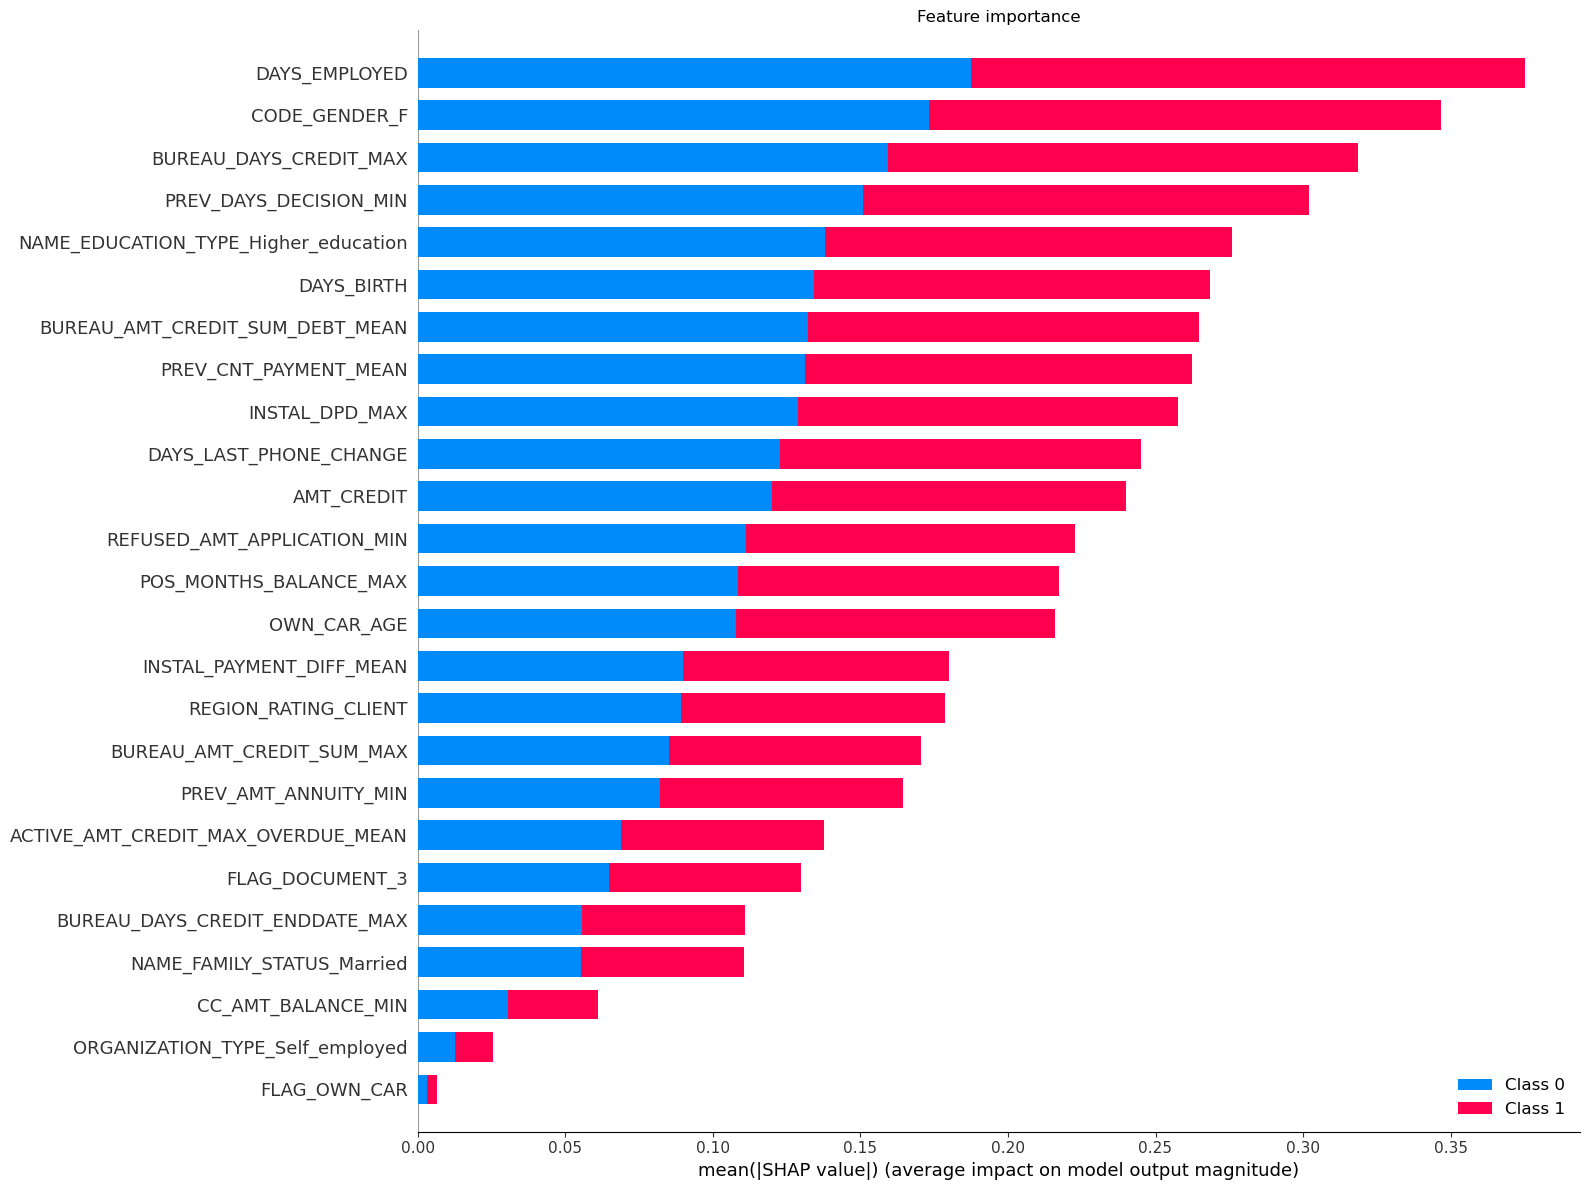

In [203]:
shap.summary_plot(shap_values, 
                  feature_names=X_test_processed.columns,
                  plot_size=(16, 12),
                  plot_type="bar",
                  max_display=50,
                  show = False)
plt.title("Feature importance")
plt.tight_layout()
plt.show()


**Summary plot**

<Figure size 480x480 with 0 Axes>

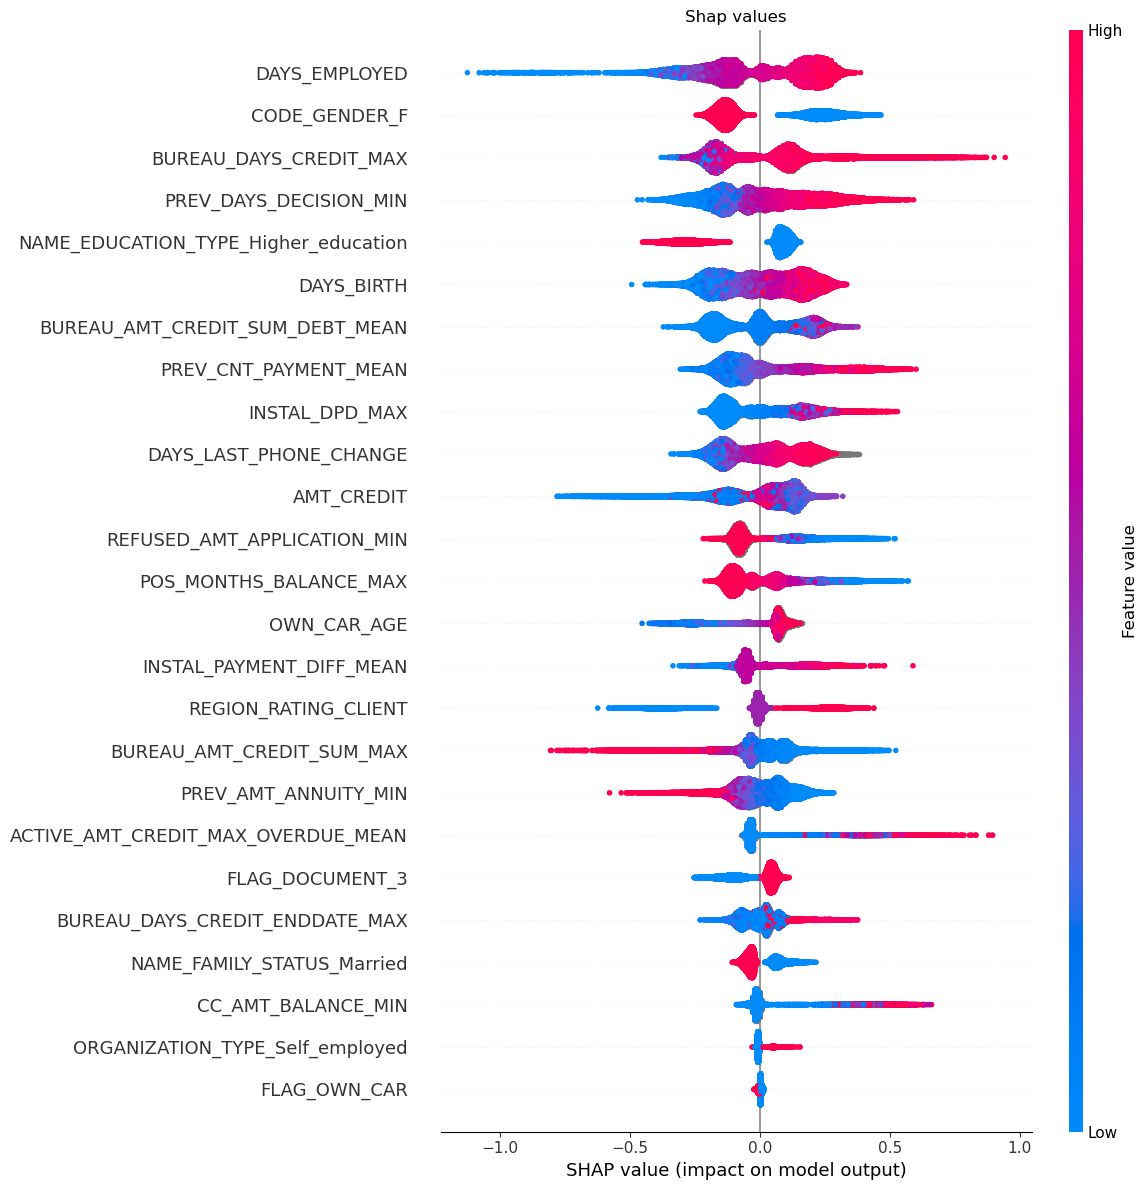

In [213]:
shap.initjs()
plt.figure(figsize=(12, 12))
shap.summary_plot(shap_values[1], 
                  features=X_test_processed,
                  feature_names=X_test_processed.columns,
                  plot_size=(12, 12),
                  plot_type="dot",
                  max_display=50,
                  show = False)
plt.title("Shap values")
plt.tight_layout()
plt.savefig('./assets/shap_tight.jpg',dpi=100)
plt.show()

The summary plot combines feature importance with feature effects. 
Each point on the summary plot is a Shapley value for a feature and an instance. 
The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. 
The color represents the value of the feature from low to high. The features are ordered according to their importance.

### Local feature importance

Let's see how feature imortance can be applied to a particular observation:

In [244]:
X_sample = X_test.sample(1)

local_explainer = shap.TreeExplainer(lgbm_model)
X_local_processed = lgbm_pipeline.named_steps["preprocessor"].transform(X_sample)
local_shap_values = local_explainer.shap_values(X_local_processed)
local_shap_values

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[array([[-0.21592159,  0.33568061,  0.03401381,  0.00425957, -0.12569829,
         -0.08985385, -0.0905005 ,  0.2476341 ,  0.00525174,  0.02983513,
         -0.0884275 , -0.03292813, -0.08897627,  0.03037745,  0.03389771,
          0.30121554, -0.23124367, -0.15688042,  0.08332851,  0.12006698,
         -0.0346241 , -0.34659007,  0.02646131,  0.00177497,  0.15992103]]),
 array([[ 0.21592159, -0.33568061, -0.03401381, -0.00425957,  0.12569829,
          0.08985385,  0.0905005 , -0.2476341 , -0.00525174, -0.02983513,
          0.0884275 ,  0.03292813,  0.08897627, -0.03037745, -0.03389771,
         -0.30121554,  0.23124367,  0.15688042, -0.08332851, -0.12006698,
          0.0346241 ,  0.34659007, -0.02646131, -0.00177497, -0.15992103]])]

Baseline value (the average of all predictions)

In [245]:
local_explainer.expected_value[1]

-0.32090140872772527

In [246]:
predict = lgbm_model.predict_proba(X_local_processed)
predict[::,1]

[LightGBM] [Warning] lambda_l1 is set=0.706184239474385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.706184239474385
[LightGBM] [Warning] lambda_l2 is set=0.19463527299726424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19463527299726424
[LightGBM] [Warning] min_data_in_leaf is set=135, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=135


array([0.44201815])

In [247]:
shap.force_plot(base_value=local_explainer.expected_value[1],
                shap_values=local_shap_values[1],
                features=X_local_processed.values[0],
                feature_names=list(X_local_processed.columns),
                figsize=(10, 6))

Each feature value is a force that either increases or decreases the prediction. The prediction starts from the baseline.  In the plot, each Shapley value is an arrow that pushes to increase (positive value) or decrease (negative value) the prediction. These forces balance each other out at the actual prediction of the data instance. For example, `INSTAL_PAYMENT_DIFF_MEAN` (Mean difference between the installment value and the amount paid in each installment of the previous credit) contributes to raise the risk of default, whereas `NAME_EDUCATION_TYPE_Higher_education` being set to 1 lowers the risk.

Another way to visualize the local feature importance is with the decision plot:

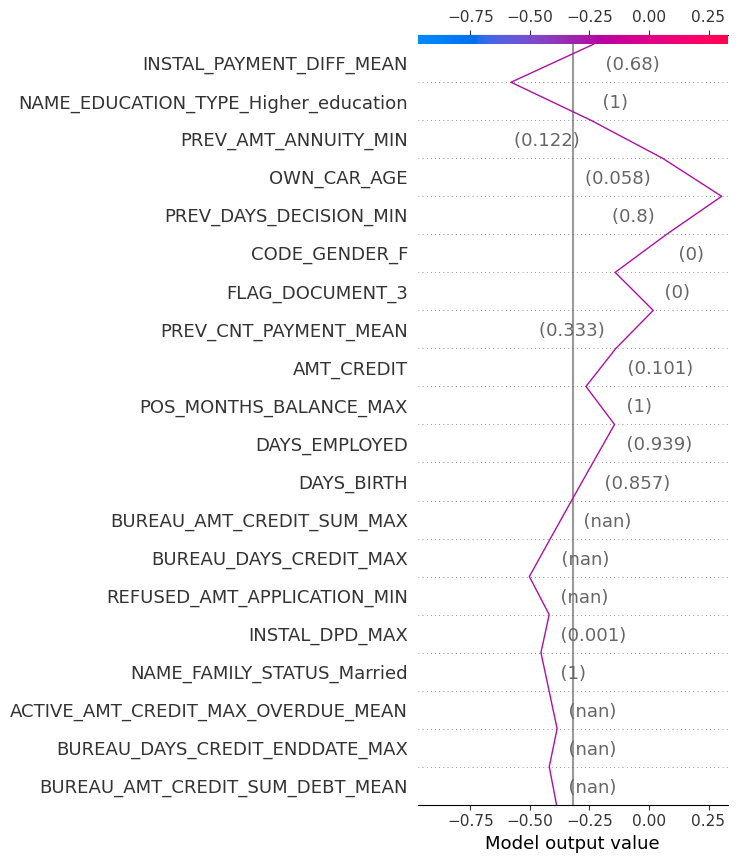

<Figure size 640x480 with 0 Axes>

In [267]:
fig, ax = plt.subplots(figsize=(4, 10))
shap.decision_plot(local_explainer.expected_value[1], 
                            local_shap_values[1], 
                            X_local_processed, 
                            feature_names=list(X_local_processed.columns),
                            auto_size_plot=False,
                            feature_order='importance')
ax.tick_params(axis='y', labelsize=6)
ax.tick_params(axis='x', labelsize=6)
ax.set_xlabel(None)
plt.tight_layout()
plt.show()

In [261]:
plt.savefig('./assets/shap_local.jpg',dpi=100)

# Prepare data for the dashboard

In order to optimize the performance of the predict API and the dashboard application, we will preprocess the data beforehand and store it in a csv file, so the API will run the model predict method on already preprocessed data. We will need 2 kinds of dataset: the transformed  with non-scaled values for displaying on the dashboard and the one with the scaled values to pass to the model predict.

**Non scaled config**

In [268]:
non_scaled_config = {
     'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': None,
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': True,
        'should_normalize_distribution': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': best_features,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
        },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
}

non_scaled_preprocess_pipeline = pipelines.get_preprocessing_pipeline(config=non_scaled_config, dev_mode=False)

In [269]:
train_data = process.load_application(dev_mode=False)
test_data = process.load_application_test(dev_mode=False)

print(train_data.shape)
print(test_data.shape)

(307511, 122)
(48744, 121)


Fit and transform the train data with `non_scaled_preprocess_pipeline`

In [277]:
train_data_processed = train_data.drop(columns=['TARGET'], axis=1)
train_data_processed = non_scaled_preprocess_pipeline.fit_transform(train_data_processed)
train_data_processed.head(10)

2024/01/13 10:48:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f838eaef150d4da0883fd9ea696cd186', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/01/13 10:48:53 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('cleaner', ApplicationCleaner()), ('feature_extractor', ApplicationFeaturesExtractor()), ('merge_bureau_and_balance', ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100003                       -2586                    -606   
100004                 ...`
2024/01/13 10:48:53 WARNING mlflow.utils: Truncated the value of the key `merge_bureau_and_balance`. Truncated value: `ApplicationFeature

CODE_GENDER_F  NAME_EDUCATION_TYPE_Higher_education  \
0              0                                     0   
1              1                                     1   
2              0                                     0   
3              1                                     0   
4              0                                     0   
5              0                                     0   
6              1                                     1   
7              0                                     1   
8              1                                     0   
9              0                                     0   

   NAME_FAMILY_STATUS_Married  ORGANIZATION_TYPE_Self_employed  FLAG_OWN_CAR  \
0                           0                                0             0   
1                           1                                0             0   
2                           0                                0             1   
3                           0                                0             0   
4                           0                                0             0   
5                           1                                0             0   
6                           1                                0             1   
7                           1                                0             1   
8                           1                                0             0   
9                           0                                0             0   

    AMT_CREDIT  DAYS_BIRTH  DAYS_EMPLOYED  OWN_CAR_AGE  REGION_RATING_CLIENT  \
0  406597.5000       -9461      -637.0000          NaN                     2   
1 1293502.5000      -16765     -1188.0000          NaN                     1   
2  135000.0000      -19046      -225.0000      26.0000                     2   
3  312682.5000      -19005     -3039.0000          NaN                     2   
4  513000.0000      -19932     -3038.0000          NaN                     2   
5  490495.5000      -16941     -1588.0000          NaN                     2   
6 1560726.0000      -13778     -3130.0000      17.0000                     2   
7 1530000.0000      -18850      -449.0000       8.0000                     3   
8 1019610.0000      -20099            NaN          NaN                     2   
9  405000.0000      -14469     -2019.0000          NaN                     2   

   ...  BUREAU_AMT_CREDIT_SUM_DEBT_MEAN  ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN  \
0  ...                       49156.2000                             40.5000   
1  ...                           0.0000                              0.0000   
2  ...                           0.0000                                 NaN   
3  ...                              NaN                                 NaN   
4  ...                           0.0000                                 NaN   
5  ...                       80019.0000                              0.0000   
6  ...                       76953.5357                                 NaN   
7  ...                      174003.7500                                 NaN   
8  ...                           0.0000                                 NaN   
9  ...                              NaN                                 NaN   

   PREV_AMT_ANNUITY_MIN  PREV_DAYS_DECISION_MIN  PREV_CNT_PAYMENT_MEAN  \
0             9251.7750               -606.0000                24.0000   
1             6737.3100              -2341.0000                10.0000   
2             5357.2500               -815.0000                 4.0000   
3             2482.9200               -617.0000                23.0000   
4             1834.2900              -2357.0000                20.6667   
5             8019.0900              -2536.0000                14.0000   
6             7435.8450              -1562.0000                 8.0000   
7            27463.4100              -1070.0000                10.0000   
8             9000.0000              -2508.0000                14.

Apply `transform` to the test data:

In [278]:
test_data_processed = non_scaled_preprocess_pipeline.transform(test_data)
test_data_processed.head(10)

2024/01/13 10:49:15 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


CODE_GENDER_F  NAME_EDUCATION_TYPE_Higher_education  \
0              1                                     1   
1              0                                     0   
2              0                                     1   
3              1                                     0   
4              0                                     0   
5              1                                     0   
6              0                                     1   
7              0                                     1   
8              1                                     1   
9              1                                     1   

   NAME_FAMILY_STATUS_Married  ORGANIZATION_TYPE_Self_employed  FLAG_OWN_CAR  \
0                           1                                0             0   
1                           1                                1             0   
2                           1                                0             1   
3                           1                                0             0   
4                           1                                0             1   
5                           1                                0             1   
6                           1                                0             1   
7                           0                                1             0   
8                           1                                0             0   
9                           0                                0             1   

    AMT_CREDIT  DAYS_BIRTH  DAYS_EMPLOYED  OWN_CAR_AGE  REGION_RATING_CLIENT  \
0  568800.0000      -19241     -2329.0000          NaN                     2   
1  222768.0000      -18064     -4469.0000          NaN                     2   
2  663264.0000      -20038     -4458.0000       5.0000                     2   
3 1575000.0000      -13976     -1866.0000          NaN                     2   
4  625500.0000      -13040     -2191.0000      16.0000                     2   
5  959688.0000      -18604    -12009.0000      10.0000                     2   
6  499221.0000      -16685     -2580.0000       3.0000                     2   
7  180000.0000       -9516     -1387.0000          NaN                     2   
8  364896.0000      -12744     -1013.0000          NaN                     1   
9   45000.0000      -10395     -2625.0000       5.0000                     2   

   ...  BUREAU_AMT_CREDIT_SUM_DEBT_MEAN  ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN  \
0  ...                       85240.9286                                 NaN   
1  ...                      189469.5000                              0.0000   
2  ...                           0.0000                                 NaN   
3  ...                       18630.4500                              0.0000   
4  ...                              NaN                                 NaN   
5  ...                      256180.2412                            499.5000   
6  ...                           0.0000                                 NaN   
7  ...                       60030.3900                              0.0000   
8  ...                       60562.5000                                 NaN   
9  ...                       84069.3214                              0.0000   

   PREV_AMT_ANNUITY_MIN  PREV_DAYS_DECISION_MIN  PREV_CNT_PAYMENT_MEAN  \
0             3951.0000              -1740.0000                 8.0000   
1             4813.2000               -757.0000                12.0000   
2             4742.4150              -1999.0000                17.3333   
3             6028.0200              -1805.0000                11.3333   
4            11100.6000               -821.0000                24.0000   
5             4500.0000              -2750.0000                21.1111   
6             4747.5900              -1182.0000                 8.3333   
7            18150.7050              -1182.0000                 5.0000   
8             2250.0000               -829.0000                21.

Add TARGET for data vizualization on training set and SK_ID_CURR column for search

In [279]:
train_data_processed['SK_ID_CURR'] = train_data['SK_ID_CURR']
train_data_processed['TARGET'] = train_data['TARGET']
train_data_processed.head()

CODE_GENDER_F  NAME_EDUCATION_TYPE_Higher_education  \
0              0                                     0   
1              1                                     1   
2              0                                     0   
3              1                                     0   
4              0                                     0   

   NAME_FAMILY_STATUS_Married  ORGANIZATION_TYPE_Self_employed  FLAG_OWN_CAR  \
0                           0                                0             0   
1                           1                                0             0   
2                           0                                0             1   
3                           0                                0             0   
4                           0                                0             0   

    AMT_CREDIT  DAYS_BIRTH  DAYS_EMPLOYED  OWN_CAR_AGE  REGION_RATING_CLIENT  \
0  406597.5000       -9461      -637.0000          NaN                     2   
1 1293502.5000      -16765     -1188.0000          NaN                     1   
2  135000.0000      -19046      -225.0000      26.0000                     2   
3  312682.5000      -19005     -3039.0000          NaN                     2   
4  513000.0000      -19932     -3038.0000          NaN                     2   

   ...  PREV_AMT_ANNUITY_MIN  PREV_DAYS_DECISION_MIN  PREV_CNT_PAYMENT_MEAN  \
0  ...             9251.7750               -606.0000                24.0000   
1  ...             6737.3100              -2341.0000                10.0000   
2  ...             5357.2500               -815.0000                 4.0000   
3  ...             2482.9200               -617.0000                23.0000   
4  ...             1834.2900              -2357.0000                20.6667   

   REFUSED_AMT_APPLICATION_MIN  POS_MONTHS_BALANCE_MAX  INSTAL_DPD_MAX  \
0                          NaN                 -1.0000          0.0000   
1                          NaN                -18.0000          0.0000   
2                          NaN                -24.0000          0.0000   
3                  688500.0000                 -1.0000          0.0000   
4                          NaN                 -1.0000         12.0000   

   INSTAL_PAYMENT_DIFF_MEAN  CC_AMT_BALANCE_MIN  SK_ID_CURR  TARGET  
0                    0.0000                 NaN      100002       1  
1                    0.0000                 NaN      100003       0  
2                    0.0000                 NaN      100004       0  
3                    0.0000              0.0000      100006       0  
4                  452.3843                 NaN      100007       0  

[5 rows x 27 columns]

In [280]:
test_data_processed['SK_ID_CURR'] = test_data['SK_ID_CURR']
test_data_processed.head()

CODE_GENDER_F  NAME_EDUCATION_TYPE_Higher_education  \
0              1                                     1   
1              0                                     0   
2              0                                     1   
3              1                                     0   
4              0                                     0   

   NAME_FAMILY_STATUS_Married  ORGANIZATION_TYPE_Self_employed  FLAG_OWN_CAR  \
0                           1                                0             0   
1                           1                                1             0   
2                           1                                0             1   
3                           1                                0             0   
4                           1                                0             1   

    AMT_CREDIT  DAYS_BIRTH  DAYS_EMPLOYED  OWN_CAR_AGE  REGION_RATING_CLIENT  \
0  568800.0000      -19241     -2329.0000          NaN                     2   
1  222768.0000      -18064     -4469.0000          NaN                     2   
2  663264.0000      -20038     -4458.0000       5.0000                     2   
3 1575000.0000      -13976     -1866.0000          NaN                     2   
4  625500.0000      -13040     -2191.0000      16.0000                     2   

   ...  ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN  PREV_AMT_ANNUITY_MIN  \
0  ...                                 NaN             3951.0000   
1  ...                              0.0000             4813.2000   
2  ...                                 NaN             4742.4150   
3  ...                              0.0000             6028.0200   
4  ...                                 NaN            11100.6000   

   PREV_DAYS_DECISION_MIN  PREV_CNT_PAYMENT_MEAN  REFUSED_AMT_APPLICATION_MIN  \
0              -1740.0000                 8.0000                          NaN   
1               -757.0000                12.0000                          NaN   
2              -1999.0000                17.3333                          NaN   
3              -1805.0000                11.3333                          NaN   
4               -821.0000                24.0000                          NaN   

   POS_MONTHS_BALANCE_MAX  INSTAL_DPD_MAX  INSTAL_PAYMENT_DIFF_MEAN  \
0                -53.0000         11.0000                    0.0000   
1                -15.0000          1.0000                    0.0000   
2                 -3.0000         21.0000                 1157.6627   
3                -20.0000          7.0000                  622.5507   
4                -15.0000          0.0000                    0.0000   

   CC_AMT_BALANCE_MIN  SK_ID_CURR  
0                 NaN      100001  
1                 NaN      100005  
2              0.0000      100013  
3              0.0000      100028  
4                 NaN      100038  

[5 rows x 26 columns]

Export to csv:

In [281]:
train_data_processed.to_csv('data/cleaned/train_processed.csv', index=False)
test_data_processed.to_csv('data/cleaned/test_processed.csv', index=False)

**Scaled dataset**

In [385]:
scaled_config = {
    'preprocessing': lgbm_preprocess_config,
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
}

scaled_preprocess_pipeline = pipelines.get_preprocessing_pipeline(config=scaled_config, dev_mode=False)

First, fit and transform on training data

In [386]:
train_data_scaled = train_data.drop(columns=['TARGET'], axis=1)
train_data_scaled = scaled_preprocess_pipeline.fit_transform(train_data_scaled)
train_data_scaled.head()

2024/01/13 12:54:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f191a41ce36e4a2eabdc9f0615ee64f9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/01/13 12:54:01 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('cleaner', ApplicationCleaner()), ('feature_extractor', ApplicationFeaturesExtractor()), ('merge_bureau_and_balance', ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100003                       -2586                    -606   
100004                 ...`
2024/01/13 12:54:01 WARNING mlflow.utils: Truncated the value of the key `merge_bureau_and_balance`. Truncated value: `ApplicationFeature

CODE_GENDER_F  NAME_EDUCATION_TYPE_Higher_education  \
0              0                                     0   
1              1                                     1   
2              0                                     0   
3              1                                     0   
4              0                                     0   

   NAME_FAMILY_STATUS_Married  ORGANIZATION_TYPE_Self_employed  AMT_CREDIT  \
0                           0                                0      0.0903   
1                           1                                0      0.3117   
2                           0                                0      0.0225   
3                           0                                0      0.0668   
4                           0                                0      0.1169   

   DAYS_BIRTH  DAYS_EMPLOYED  OWN_CAR_AGE  REGION_RATING_CLIENT  \
0      0.8888         0.9644          NaN                0.5000   
1      0.4771         0.9337          NaN                0.0000   
2      0.3485         0.9874       0.2857                0.5000   
3      0.3508         0.8303          NaN                0.5000   
4      0.2986         0.8304          NaN                0.5000   

   DAYS_LAST_PHONE_CHANGE  ...  PREV_AMT_ANNUITY_MIN  PREV_DAYS_DECISION_MIN  \
0                  0.7360  ...                0.0308                  0.7932   
1                  0.8073  ...                0.0224                  0.1990   
2                  0.8103  ...                0.0178                  0.7216   
3                  0.8564  ...                0.0083                  0.7894   
4                  0.7425  ...                0.0061                  0.1935   

   PREV_CNT_PAYMENT_MEAN  REFUSED_AMT_APPLICATION_MIN  POS_MONTHS_BALANCE_MAX  \
0                 0.3333                          NaN                  1.0000   
1                 0.1389                          NaN                  0.8211   
2                 0.0556                          NaN                  0.7579   
3                 0.3194                       0.1545                  1.0000   
4                 0.2870                          NaN                  1.0000   

   INSTAL_DPD_MAX  INSTAL_PAYMENT_DIFF_MEAN  CC_AMT_BALANCE_MIN  FLAG_OWN_CAR  \
0          0.0000                    0.6978                 NaN             0   
1          0.0000                    0.6978                 NaN             0   
2          0.0000                    0.6978                 NaN             1   
3          0.0000                    0.6978              0.3257             0   
4          0.0042                    0.6988                 NaN             0   

   FLAG_DOCUMENT_3  
0                1  
1                1  
2                0  
3                1  
4                0  

[5 rows x 25 columns]

Then, transform on test data

In [387]:
test_data_scaled = scaled_preprocess_pipeline.transform(test_data)
test_data_scaled.head()

2024/01/13 12:54:36 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


CODE_GENDER_F  NAME_EDUCATION_TYPE_Higher_education  \
0              1                                     1   
1              0                                     0   
2              0                                     1   
3              1                                     0   
4              0                                     0   

   NAME_FAMILY_STATUS_Married  ORGANIZATION_TYPE_Self_employed  AMT_CREDIT  \
0                           1                                0      0.1308   
1                           1                                1      0.0444   
2                           1                                0      0.1544   
3                           1                                0      0.3820   
4                           1                                0      0.1449   

   DAYS_BIRTH  DAYS_EMPLOYED  OWN_CAR_AGE  REGION_RATING_CLIENT  \
0      0.3375         0.8700          NaN                0.5000   
1      0.4039         0.7505          NaN                0.5000   
2      0.2926         0.7511       0.0549                0.5000   
3      0.6343         0.8958          NaN                0.5000   
4      0.6871         0.8777       0.1758                0.5000   

   DAYS_LAST_PHONE_CHANGE  ...  PREV_AMT_ANNUITY_MIN  PREV_DAYS_DECISION_MIN  \
0                  0.5947  ...                0.0132                  0.4048   
1                     NaN  ...                0.0160                  0.7414   
2                  0.8007  ...                0.0158                  0.3161   
3                  0.5796  ...                0.0201                  0.3825   
4                  0.8089  ...                0.0369                  0.7195   

   PREV_CNT_PAYMENT_MEAN  REFUSED_AMT_APPLICATION_MIN  POS_MONTHS_BALANCE_MAX  \
0                 0.1111                          NaN                  0.4526   
1                 0.1667                          NaN                  0.8526   
2                 0.2407                          NaN                  0.9789   
3                 0.1574                          NaN                  0.8000   
4                 0.3333                          NaN                  0.8526   

   INSTAL_DPD_MAX  INSTAL_PAYMENT_DIFF_MEAN  CC_AMT_BALANCE_MIN  FLAG_OWN_CAR  \
0          0.0038                    0.6978                 NaN             0   
1          0.0003                    0.6978                 NaN             0   
2          0.0073                    0.7002              0.3257             1   
3          0.0024                    0.6991              0.3257             0   
4          0.0000                    0.6978                 NaN             1   

   FLAG_DOCUMENT_3  
0                1  
1                1  
2                0  
3                1  
4                1  

[5 rows x 25 columns]

In [388]:
test_data_scaled['SK_ID_CURR'] = test_data['SK_ID_CURR']
test_data_scaled.head()

CODE_GENDER_F  NAME_EDUCATION_TYPE_Higher_education  \
0              1                                     1   
1              0                                     0   
2              0                                     1   
3              1                                     0   
4              0                                     0   

   NAME_FAMILY_STATUS_Married  ORGANIZATION_TYPE_Self_employed  AMT_CREDIT  \
0                           1                                0      0.1308   
1                           1                                1      0.0444   
2                           1                                0      0.1544   
3                           1                                0      0.3820   
4                           1                                0      0.1449   

   DAYS_BIRTH  DAYS_EMPLOYED  OWN_CAR_AGE  REGION_RATING_CLIENT  \
0      0.3375         0.8700          NaN                0.5000   
1      0.4039         0.7505          NaN                0.5000   
2      0.2926         0.7511       0.0549                0.5000   
3      0.6343         0.8958          NaN                0.5000   
4      0.6871         0.8777       0.1758                0.5000   

   DAYS_LAST_PHONE_CHANGE  ...  PREV_DAYS_DECISION_MIN  PREV_CNT_PAYMENT_MEAN  \
0                  0.5947  ...                  0.4048                 0.1111   
1                     NaN  ...                  0.7414                 0.1667   
2                  0.8007  ...                  0.3161                 0.2407   
3                  0.5796  ...                  0.3825                 0.1574   
4                  0.8089  ...                  0.7195                 0.3333   

   REFUSED_AMT_APPLICATION_MIN  POS_MONTHS_BALANCE_MAX  INSTAL_DPD_MAX  \
0                          NaN                  0.4526          0.0038   
1                          NaN                  0.8526          0.0003   
2                          NaN                  0.9789          0.0073   
3                          NaN                  0.8000          0.0024   
4                          NaN                  0.8526          0.0000   

   INSTAL_PAYMENT_DIFF_MEAN  CC_AMT_BALANCE_MIN  FLAG_OWN_CAR  \
0                    0.6978                 NaN             0   
1                    0.6978                 NaN             0   
2                    0.7002              0.3257             1   
3                    0.6991              0.3257             0   
4                    0.6978                 NaN             1   

   FLAG_DOCUMENT_3  SK_ID_CURR  
0                1      100001  
1                1      100005  
2                0      100013  
3                1      100028  
4                1      100038  

[5 rows x 26 columns]

Export to csv:

In [389]:
test_data_scaled.to_csv('data/cleaned/test_scaled.csv', index=False)

Train and export the Scaler transformer for the simulation feature in the Dashboard:

In [438]:
scaler_transformer = transformers.ApplicationScaler(scaler=lgbm_preprocess_config['scaler'])

train_data_scaled = train_data_processed.drop(columns=['TARGET', 'SK_ID_CURR'], axis=1)
train_data_scaled = scaler_transformer.fit_transform(train_data_scaled)
train_data_scaled.head()

AMT_CREDIT  DAYS_BIRTH  DAYS_EMPLOYED  OWN_CAR_AGE  REGION_RATING_CLIENT  \
0      0.0903      0.8888         0.9644          NaN                0.5000   
1      0.3117      0.4771         0.9337          NaN                0.0000   
2      0.0225      0.3485         0.9874       0.2857                0.5000   
3      0.0668      0.3508         0.8303          NaN                0.5000   
4      0.1169      0.2986         0.8304          NaN                0.5000   

   DAYS_LAST_PHONE_CHANGE  BUREAU_DAYS_CREDIT_MAX  \
0                  0.7360                  0.9648   
1                  0.8073                  0.7926   
2                  0.8103                  0.8604   
3                  0.8564                     NaN   
4                  0.7425                  0.6068   

   BUREAU_DAYS_CREDIT_ENDDATE_MAX  BUREAU_AMT_CREDIT_SUM_MAX  \
0                          0.5837                     0.0011   
1                          0.5897                     0.0020   
2                          0.5678                     0.0002   
3                             NaN                        NaN   
4                          0.5623                     0.0004   

   BUREAU_AMT_CREDIT_SUM_DEBT_MEAN  ...  POS_MONTHS_BALANCE_MAX  \
0                           0.0253  ...                  1.0000   
1                           0.0242  ...                  0.8211   
2                           0.0242  ...                  0.7579   
3                              NaN  ...                  1.0000   
4                           0.0242  ...                  1.0000   

   INSTAL_DPD_MAX  INSTAL_PAYMENT_DIFF_MEAN  CC_AMT_BALANCE_MIN  \
0          0.0000                    0.6978                 NaN   
1          0.0000                    0.6978                 NaN   
2          0.0000                    0.6978                 NaN   
3          0.0000                    0.6978              0.3257   
4          0.0042                    0.6988                 NaN   

   CODE_GENDER_F  NAME_EDUCATION_TYPE_Higher_education  \
0              0                                     0   
1              1                                     1   
2              0                                     0   
3              1                                     0   
4              0                                     0   

   NAME_FAMILY_STATUS_Married  ORGANIZATION_TYPE_Self_employed  FLAG_OWN_CAR  \
0                           0                                0             0   
1                           1                                0             0   
2                           0                                0             1   
3                           0                                0             0   
4                           0                                0             0   

   FLAG_DOCUMENT_3  
0                1  
1                1  
2                0  
3                1  
4                0  

[5 rows x 25 columns]

In [439]:
scaler_filename = f'./model/scaler.pkl'
joblib.dump(scaler_transformer, scaler_filename)

['./model/scaler.pkl']